In [16]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import os
from sklearn.preprocessing import StandardScaler
from scipy.stats import boxcox
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Load red tide data

In [17]:
# Get the current folder path
current_folder = os.getcwd()

# Specify the relative path to the file
akashio_path = os.path.join(current_folder, 'AKASHIO', 'akashio.xlsx')

# Read the Excel file into a Pandas DataFrame
df_red = pd.read_excel(akashio_path)

# Display the DataFrame
display(df_red)
#display(df_red.dtypes)
#null_values = df_red.isnull().sum()
#print(null_values)


date  red_tide_days  damage_to_fisheries
0   2003-01-01              1                    0
1   2003-02-01              1                    0
2   2003-03-01              1                    0
3   2003-04-01             11                    0
4   2003-05-01             19                    0
..         ...            ...                  ...
235 2022-08-01              8                    0
236 2022-09-01              6                    0
237 2022-10-01             15                    0
238 2022-11-01              0                    0
239 2022-12-01              1                    0

[240 rows x 3 columns]

# Visualization: Red tides

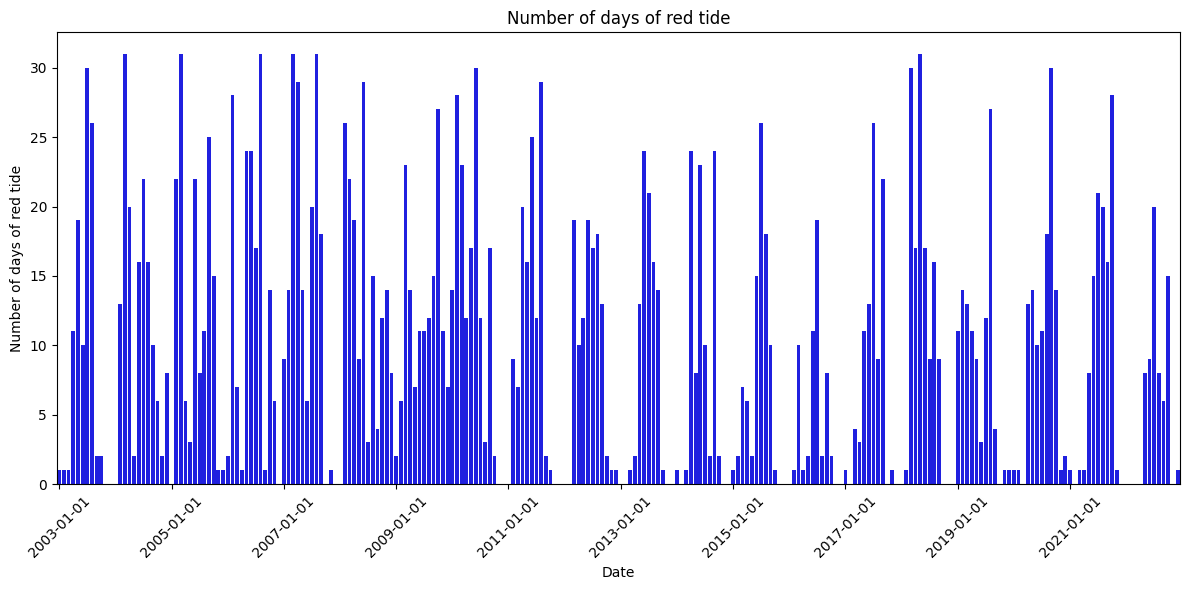

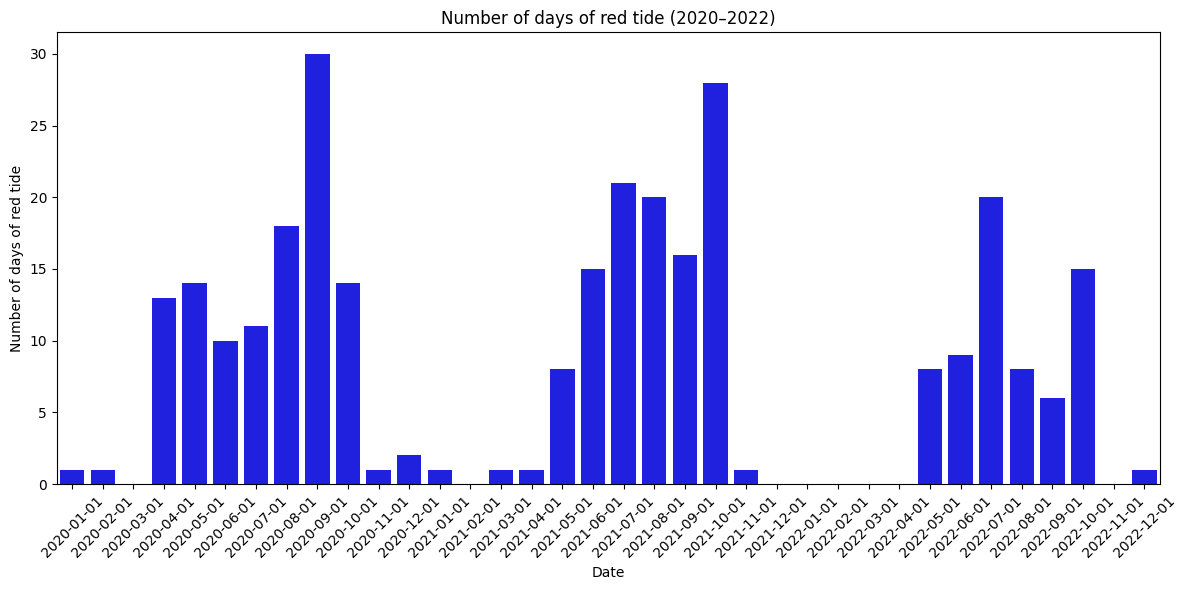

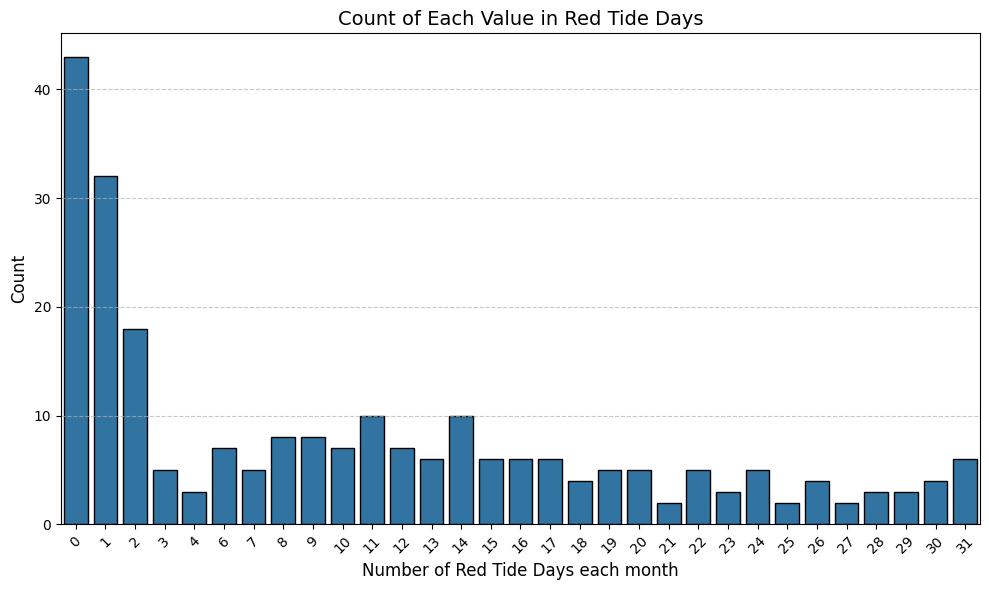

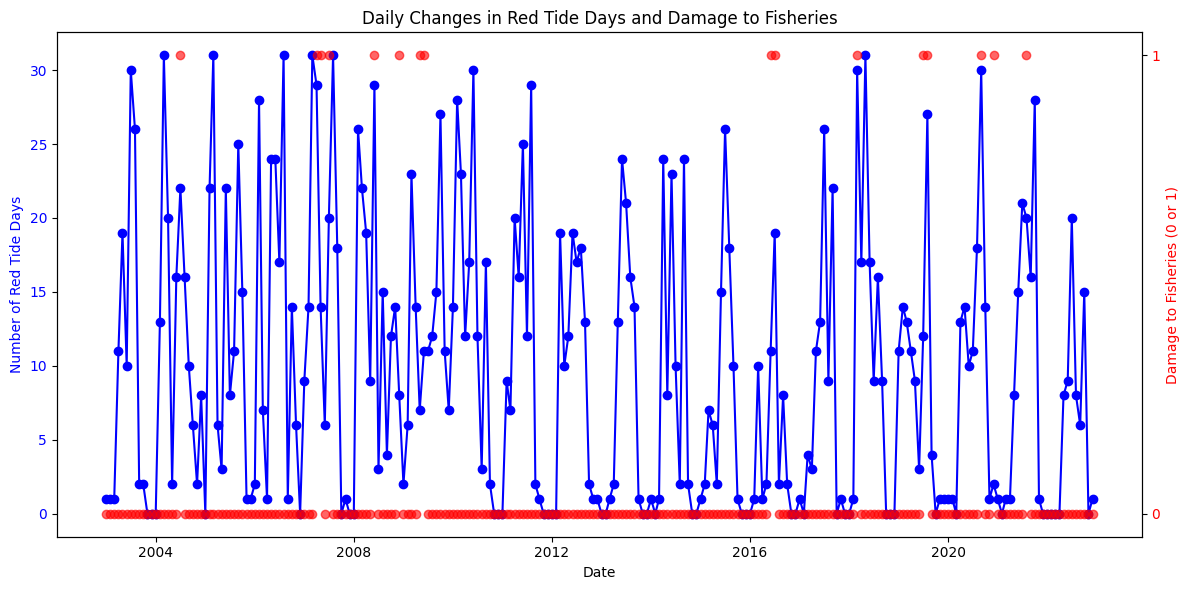

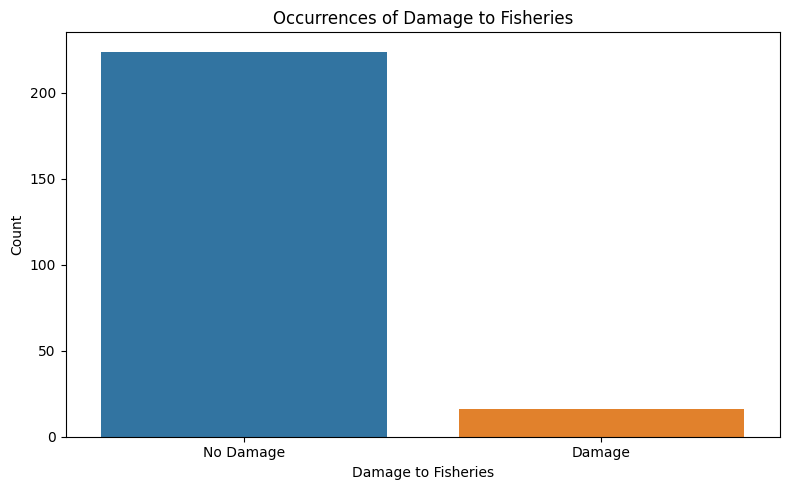

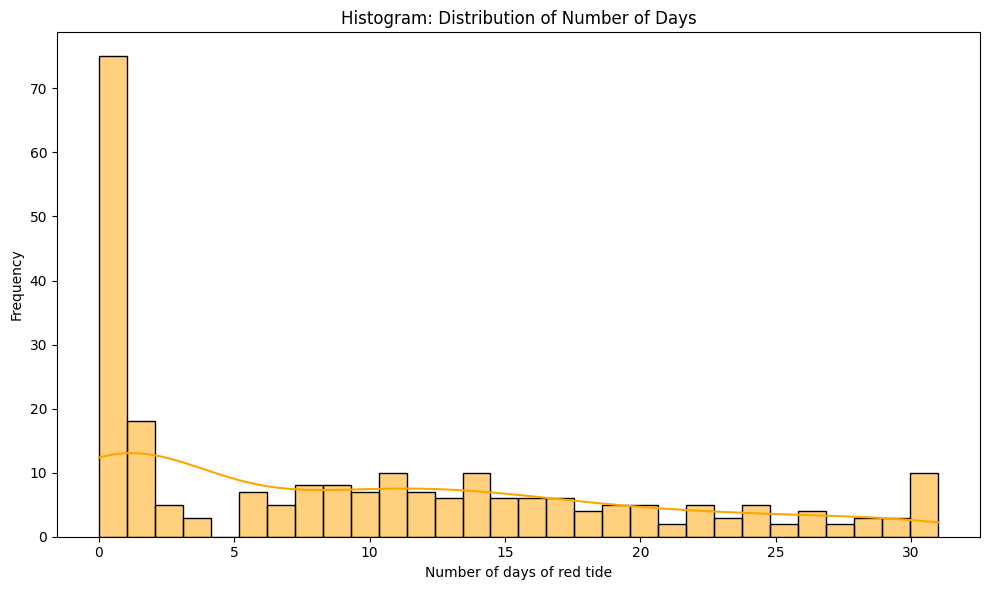

In [18]:
# Bar Graph: Plotting the "number_of_days" for each "date"
plt.figure(figsize=(12, 6))
sns.barplot(x='date', y='red_tide_days', data=df_red, color='blue', errorbar=None)
# Rotate x-axis labels and reduce the number of ticks
plt.xticks(ticks=range(0, len(df_red['date']), len(df_red['date']) // 10), rotation=45)
plt.title('Number of days of red tide')
plt.xlabel('Date')
plt.ylabel('Number of days of red tide')
plt.tight_layout()
plt.show()

# Filter the DataFrame for the years 2020, 2021, and 2022
df_filtered = df_red[df_red['date'].dt.year.isin([2020, 2021, 2022])]
# Bar Graph: Plotting the "number_of_days" for filtered years
plt.figure(figsize=(12, 6))
sns.barplot(x='date', y='red_tide_days', data=df_filtered, color='blue', errorbar=None)
# Rotate x-axis labels for better readability
plt.xticks(rotation=45)
plt.title('Number of days of red tide (2020–2022)')
plt.xlabel('Date')
plt.ylabel('Number of days of red tide')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.countplot(x='red_tide_days', data=df_red, color='#1f77b4', edgecolor='black')  # Dark blue bars, black edges
plt.title('Count of Each Value in Red Tide Days', fontsize=14)
plt.xlabel('Number of Red Tide Days each month', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Light grid for readability
plt.tight_layout()
plt.show()

fig, ax1 = plt.subplots(figsize=(12, 6))
# Primary y-axis for "red_tide_days"
ax1.set_xlabel('Date')
ax1.set_ylabel('Number of Red Tide Days', color='blue')
ax1.plot(df_red['date'], df_red['red_tide_days'], color='blue', marker='o', label='Red Tide Days')
ax1.tick_params(axis='y', labelcolor='blue')
# Secondary y-axis for "damage_to_fisheries"
ax2 = ax1.twinx()
ax2.set_ylabel('Damage to Fisheries (0 or 1)', color='red')
ax2.scatter(df_red['date'], df_red['damage_to_fisheries'], color='red', label='Damage to Fisheries', alpha=0.6)
ax2.tick_params(axis='y', labelcolor='red')
ax2.set_yticks([0, 1])  # Since it's binary
# Titles and legend
plt.title('Daily Changes in Red Tide Days and Damage to Fisheries')
fig.tight_layout()
plt.show()

# Count Plot: Displaying occurrences of damage to fisheries (binary values)
plt.figure(figsize=(8, 5))
sns.countplot(x='damage_to_fisheries', data=df_red, hue='damage_to_fisheries', legend=False)
plt.xticks([0, 1], ['No Damage', 'Damage'])  # Label the categories
plt.title('Occurrences of Damage to Fisheries')
plt.xlabel('Damage to Fisheries')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# Histogram: Distribution of "number_of_days"
plt.figure(figsize=(10, 6))
sns.histplot(df_red['red_tide_days'], bins=30, kde=True, color='orange')
plt.title('Histogram: Distribution of Number of Days')
plt.xlabel('Number of days of red tide')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


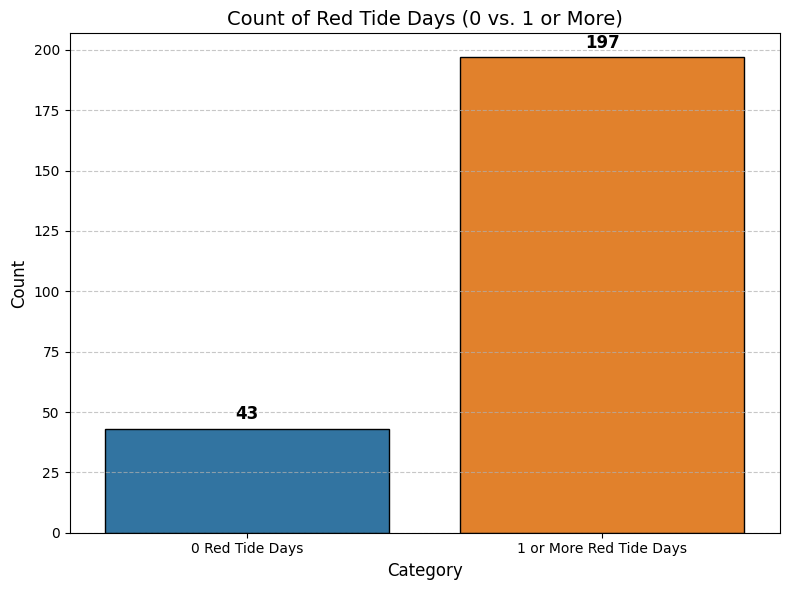

In [19]:
# Count occurrences
zero_count = (df_red['red_tide_days'] == 0).sum()
one_or_more_count = (df_red['red_tide_days'] >= 1).sum()

# Data for plotting
categories = ['0 Red Tide Days', '1 or More Red Tide Days']
counts = [zero_count, one_or_more_count]

# Create bar plot
plt.figure(figsize=(8, 6))
sns.barplot(x=categories, y=counts, hue=categories, edgecolor='black', legend=False)

# Titles and labels
plt.title('Count of Red Tide Days (0 vs. 1 or More)', fontsize=14)
plt.xlabel('Category', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show values on top of bars
for i, count in enumerate(counts):
    plt.text(i, count + max(counts) * 0.02, str(count), ha='center', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()


# Time series analysis for red tides data

date  red_tide_days  damage_to_fisheries
0 2003-01-01              1                    0
1 2003-02-01              1                    0
2 2003-03-01              1                    0
3 2003-04-01             11                    0
4 2003-05-01             19                    0

<Figure size 1000x800 with 0 Axes>

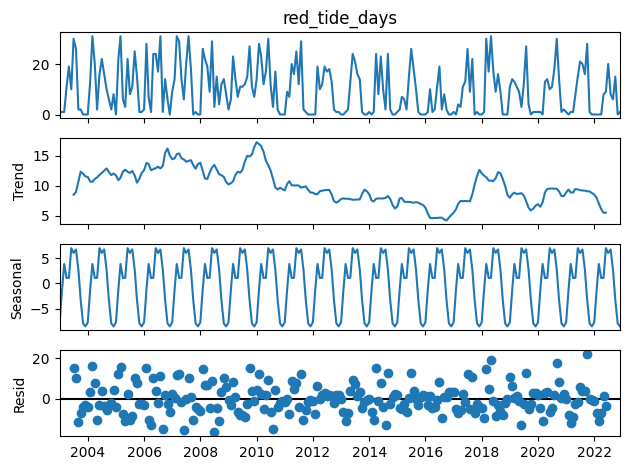

In [20]:
df_decomp = df_red.copy()
display(df_decomp.head())
df_decomp['date'] = pd.to_datetime(df_decomp['date'])
df_decomp.set_index('date', inplace=True)

# Decompose the 'red_tide_days' column
result_decomp_add = seasonal_decompose(df_decomp['red_tide_days'], model='additive')

# Plot the decomposition
plt.figure(figsize=(10, 8))
result_decomp_add.plot()
plt.tight_layout()
plt.show()

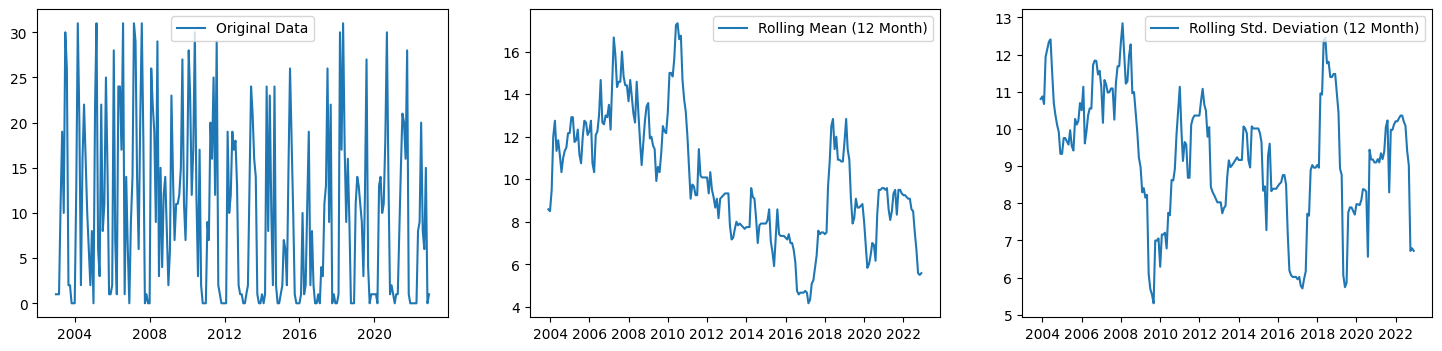

In [21]:
# Evaluate stationarity with a 1-year window (12 months)
rolling_mean12 = df_decomp['red_tide_days'].rolling(window=12).mean()
rolling_std12 = df_decomp['red_tide_days'].rolling(window=12).std()

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 4))
ax[0].plot(df_decomp['red_tide_days'], label='Original Data')
ax[0].legend()
ax[1].plot(rolling_mean12, label='Rolling Mean (12 Month)')
ax[1].legend()
ax[2].plot(rolling_std12, label='Rolling Std. Deviation (12 Month)')
ax[2].legend()
plt.show()

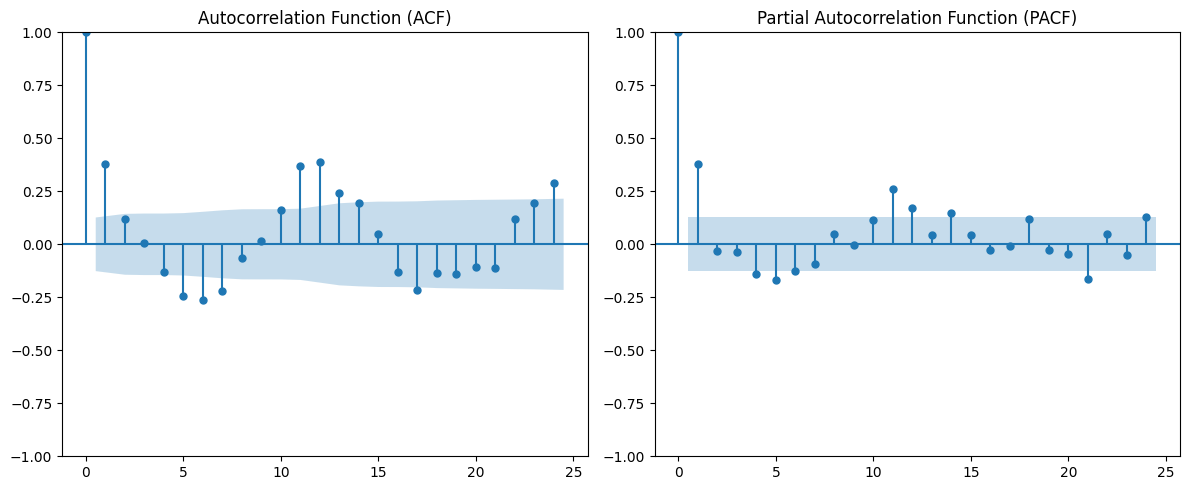

In [22]:
# Plot ACF and PACF for 'red_tide_days'
plt.figure(figsize=(12, 5))
plt.subplot(121)
plot_acf(df_decomp['red_tide_days'].dropna(), lags=24, ax=plt.gca())
plt.title('Autocorrelation Function (ACF)')

plt.subplot(122)
plot_pacf(df_decomp['red_tide_days'].dropna(), lags=24, method='ywm', ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()

# Load water temperature data

In [23]:
# Specify the relative path to the file
wtemp_path = os.path.join(current_folder, 'WTEMP', 'wtemp.xlsx')

# Read the Excel file into a Pandas DataFrame
df_wtemp = pd.read_excel(wtemp_path)

# Display the DataFrame
#display(df_wtemp)
#display(df_wtemp.dtypes)
#null_values = df_wtemp.isnull().sum()
#print(null_values)

# Calculate the average of columns 'wtemp_1' to 'wtemp_9' and add it as a new column 'wtemp_ave'
df_wtemp['wtemp_ave'] = df_wtemp.loc[:, 'wtemp_1':'wtemp_9'].mean(axis=1)
df_wtemp['wtemp_std'] = df_wtemp.loc[:, 'wtemp_1':'wtemp_9'].std(axis=1)
print("Min std: ", df_wtemp['wtemp_std'].min())
print("Max std: ", df_wtemp['wtemp_std'].max())

# Display the updated DataFrame
display(df_wtemp)
display(df_wtemp.describe().T)


Min std:  0.1232995449212111
Max std:  2.955987332704779


date  wtemp_1  wtemp_2  wtemp_3  wtemp_4  wtemp_5  wtemp_6  wtemp_7  \
0   2003-01-01    13.70    14.02    14.10    12.33    13.08    13.10    10.87   
1   2003-02-01    11.83    12.27    12.38    10.90    10.81    10.89     9.57   
2   2003-03-01    11.57    11.79    11.98    11.53    10.57    10.62    11.00   
3   2003-04-01    13.67    13.15    13.20    13.33    12.13    12.14    13.97   
4   2003-05-01    16.07    15.94    15.88    16.70    15.45    15.42    17.23   
..         ...      ...      ...      ...      ...      ...      ...      ...   
235 2022-08-01    26.27    22.92    20.14    27.60    23.45    22.86    29.67   
236 2022-09-01    26.23    24.72    22.71    25.77    24.80    24.76    27.27   
237 2022-10-01    23.57    23.60    23.59    23.57    23.79    23.80    23.43   
238 2022-11-01    20.93    21.43    21.55    20.37    21.06    21.16    20.07   
239 2022-12-01    17.87    18.36    18.44    17.10    17.45    17.44    16.20   

     wtemp_8  wtemp_9  wtemp_ave  wtemp_std  
0      12.62    13.77  13.065556   1.027206  
1      10.43    11.29  11.152222   0.902064  
2      10.33    10.37  11.084444   0.642381  
3      11.84    11.70  12.792222   0.844449  
4      15.63    14.47  15.865556   0.788973  
..       ...      ...        ...        ...  
235    24.21    22.22  24.371111   2.955987  
236    26.05    24.85  25.240000   1.288672  
237    23.75    23.70  23.644444   0.123300  
238    21.52    21.82  21.101111   0.573813  
239    17.14    18.00  17.555556   0.704275  

[240 rows x 12 columns]

count                 mean                  min  \
date         240  2012-12-15 17:00:00  2003-01-01 00:00:00   
wtemp_1    240.0            18.725833                11.57   
wtemp_2    240.0              18.1875                11.79   
wtemp_3    240.0            17.693333                11.98   
wtemp_4    240.0            18.755833                 10.9   
wtemp_5    240.0            17.705833                10.57   
wtemp_6    240.0               17.605                10.62   
wtemp_7    240.0            19.034167                 9.57   
wtemp_8    240.0            17.883333                10.33   
wtemp_9    240.0              17.4575                10.37   
wtemp_ave  240.0            18.116481            11.084444   
wtemp_std  240.0             1.150919               0.1233   

                           25%                  50%                  75%  \
date       2007-12-24 06:00:00  2012-12-16 12:00:00  2017-12-08 18:00:00   
wtemp_1                13.6925                19.15                22.82   
wtemp_2                13.8025               18.485                21.81   
wtemp_3                 13.875               18.445              20.4925   
wtemp_4                  13.08               18.735               23.845   
wtemp_5                12.8425               17.885              22.0325   
wtemp_6                  12.86               17.785               21.585   
wtemp_7                13.2275                18.65              24.0725   
wtemp_8                 12.425               17.685               23.075   
wtemp_9                13.2525               17.275                21.92   
wtemp_ave            12.997222            18.391667            22.634444   
wtemp_std             0.688801             0.873257             1.458483   

                           max       std  
date       2022-12-01 00:00:00       NaN  
wtemp_1                  26.27  5.147188  
wtemp_2                  24.72  4.475939  
wtemp_3                  23.59  3.924615  
wtemp_4                   27.6  5.681777  
wtemp_5                   24.8  5.034917  
wtemp_6                  24.76  4.926804  
wtemp_7                  29.67  6.624098  
wtemp_8                  26.05  5.500946  
wtemp_9                  24.85  4.936682  
wtemp_ave                25.24  5.054025  
wtemp_std             2.955987  0.754426

# Visualization: Water temperature

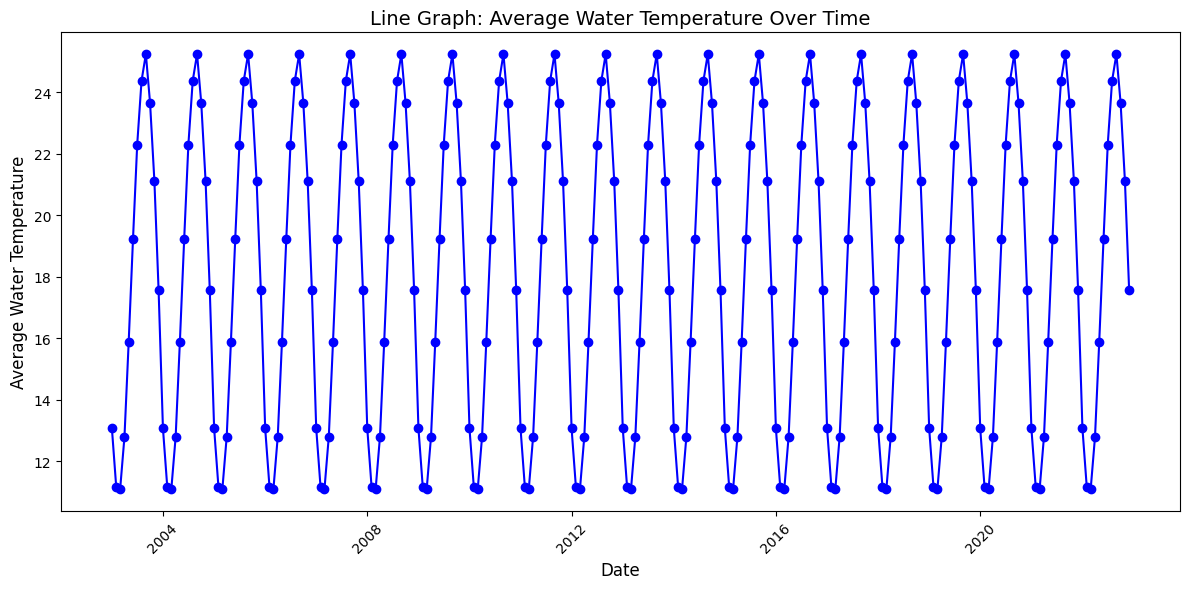

In [24]:
# Line Graph: Plotting "wtemp_ave" over "date"
plt.figure(figsize=(12, 6))
plt.plot(df_wtemp['date'], df_wtemp['wtemp_ave'], marker='o', linestyle='-', color='blue', label='Average Water Temperature')

# Adding titles and labels
plt.title('Line Graph: Average Water Temperature Over Time', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Average Water Temperature', fontsize=12)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Adding a legend
#plt.legend()

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


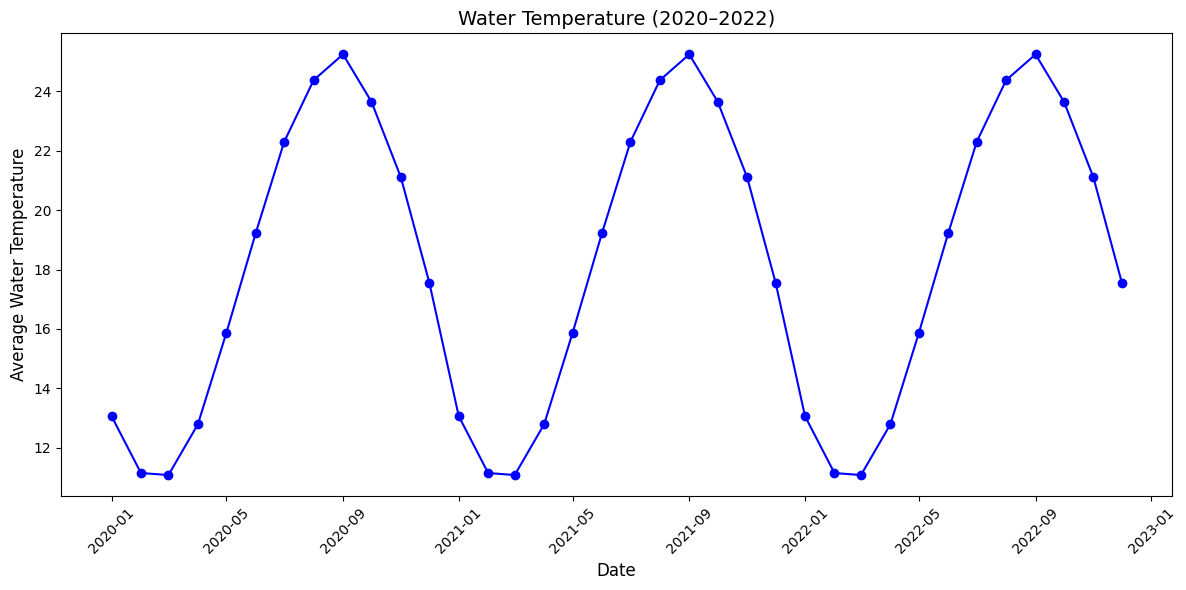

In [25]:
# Determine the last three years in the dataset
last_year = df_wtemp['date'].dt.year.max()
last_three_years = [last_year - 2, last_year - 1, last_year]

# Filter data for the last three years
df_filtered = df_wtemp[df_wtemp['date'].dt.year.isin(last_three_years)]

# Line Graph: Plotting "wtemp_ave" for the last three years
plt.figure(figsize=(12, 6))
plt.plot(df_filtered['date'], df_filtered['wtemp_ave'], marker='o', linestyle='-', color='blue', label='Average Water Temperature')

# Adding titles and labels
plt.title(f'Water Temperature ({last_three_years[0]}–{last_three_years[-1]})', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Average Water Temperature', fontsize=12)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Adding a legend
#plt.legend()

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

# Load COD data

In [26]:
# Path to the "COD" folder
folder_path = os.path.join(current_folder, "COD")

# List to store DataFrames
df_list = []

# Loop through the files from 2002 to 2022
for year in range(2002, 2023):  # 2023 is excluded
    file_name = f"{year}_cod.csv"
    file_path = os.path.join(folder_path, file_name)
    
    # Read the CSV file and append it to the list
    df = pd.read_csv(file_path)
    df_list.append(df)

# Combine all DataFrames into a single DataFrame
combined_df = pd.concat(df_list, ignore_index=True)

# Display the combined DataFrame
#display(combined_df)
#print(combined_df.dtypes)
#null_values = combined_df.isnull().sum()
#print(null_values)

# Rename columns to match the expected format
combined_df = combined_df.rename(columns={'FISCALYEAR': 'year', 'MONTH': 'month'})

# Add a 'day' column with a default value of 1
combined_df['day'] = 1

# Create the "date" column
combined_df['date'] = pd.to_datetime(combined_df[['year', 'month', 'day']])

# Select the "date" column and the "COD2" column, renaming "COD2" to "cod"
df_cod = combined_df[['date', 'COD2']].rename(columns={'COD2': 'cod'})
#display(df_cod)

# Create a new DataFrame by dropping rows where 'cod' is NaN
df_cod_cleaned = df_cod.dropna(subset=['cod'])

# Display the cleaned DataFrame
#display(df_cod_cleaned)

# Calculate the average value of 'cod' for each 'date'
df_cod_ave = df_cod_cleaned.groupby('date', as_index=False).agg(cod_ave=('cod', 'mean'))
df_cod_ave = df_cod_ave[(df_cod_ave['date'] >= '2003-01-01') & (df_cod_ave['date'] <= '2022-12-01')]

# Display the resulting DataFrame
display(df_cod_ave)


date   cod_ave
9   2003-01-01  2.878788
10  2003-02-01  3.157143
11  2003-03-01  2.515152
12  2003-04-01  3.296970
13  2003-05-01  3.697143
..         ...       ...
244 2022-08-01  3.494286
245 2022-09-01  2.887879
246 2022-10-01  2.524242
247 2022-11-01  2.162857
248 2022-12-01  2.351515

[240 rows x 2 columns]

# Visualization: COD

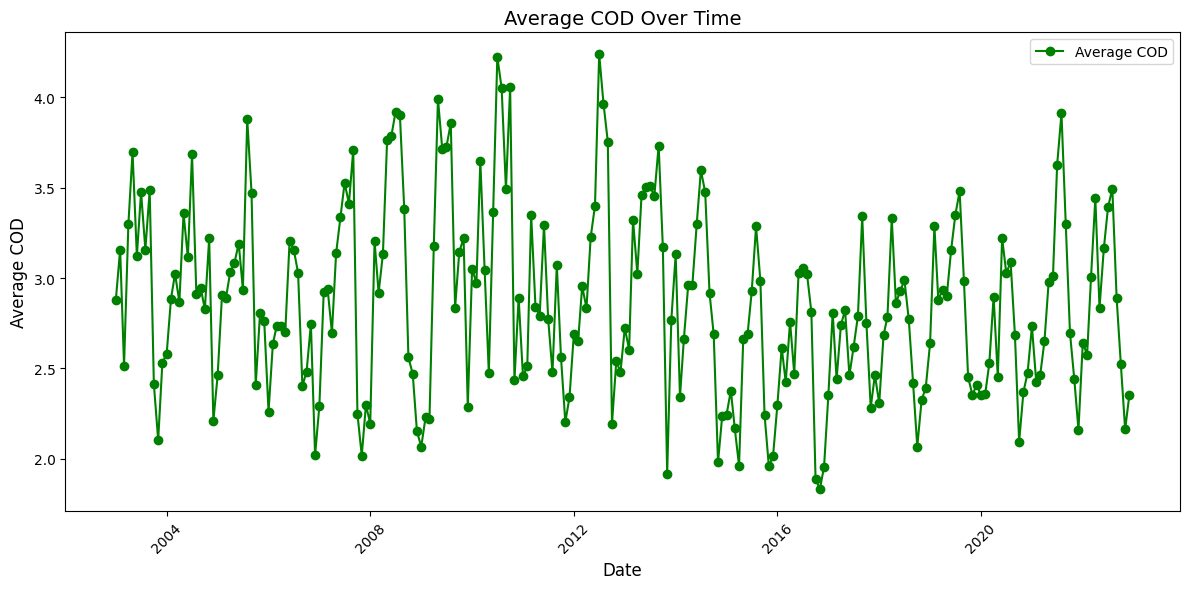

In [27]:
# Line Graph: Plotting "cod_ave" over "date"
plt.figure(figsize=(12, 6))
plt.plot(df_cod_ave['date'], df_cod_ave['cod_ave'], marker='o', linestyle='-', color='green', label='Average COD')

# Adding titles and labels
plt.title('Average COD Over Time', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Average COD', fontsize=12)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Adding a legend
plt.legend()

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


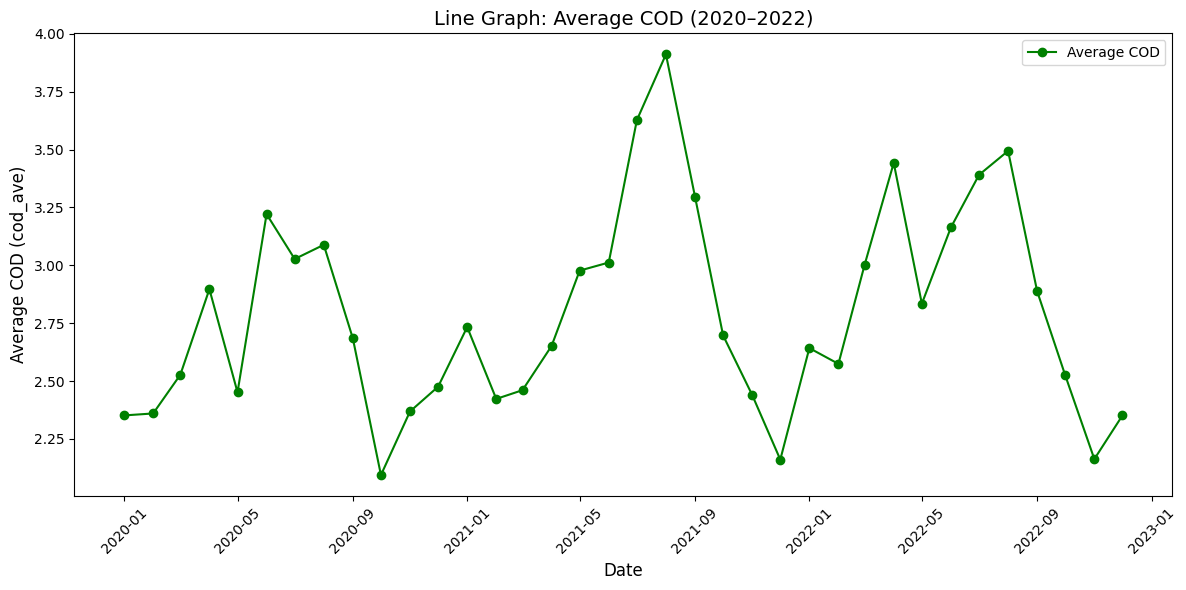

In [28]:
# Determine the last three years in the dataset
last_year = df_cod_ave['date'].dt.year.max()
last_three_years = [last_year - 2, last_year - 1, last_year]

# Filter data for the last three years
df_filtered = df_cod_ave[df_cod_ave['date'].dt.year.isin(last_three_years)]

# Line Graph: Plotting "cod_ave" for the last three years
plt.figure(figsize=(12, 6))
plt.plot(df_filtered['date'], df_filtered['cod_ave'], marker='o', linestyle='-', color='green', label='Average COD')

# Adding titles and labels
plt.title(f'Line Graph: Average COD ({last_three_years[0]}–{last_three_years[-1]})', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Average COD (cod_ave)', fontsize=12)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Adding a legend
plt.legend()

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


# Load total nitrogen and total phosphorus

In [29]:
folder_path = os.path.join(current_folder, "TNTP")

# List to store DataFrames
df_list = []

# Loop through the files from 2002 to 2022
for year in range(2002, 2023):  # 2023 is excluded
    file_name = f"{year}_tntp.csv"
    file_path = os.path.join(folder_path, file_name)
    
    # Read the CSV file and append it to the list
    df = pd.read_csv(file_path)
    df_list.append(df)

# Combine all DataFrames into a single DataFrame
combined_df = pd.concat(df_list, ignore_index=True)

# Display the combined DataFrame
#display(combined_df)
#print(combined_df.dtypes)
#null_values = combined_df.isnull().sum()
#print(null_values)

# Rename columns to match the expected format
combined_df = combined_df.rename(columns={'FISCALYEAR': 'year', 'MONTH': 'month'})

# Add a 'day' column with a default value of 1
combined_df['day'] = 1

# Create the "date" column
combined_df['date'] = pd.to_datetime(combined_df[['year', 'month', 'day']])

# Select the "date" column and the "COD2" column, renaming "COD2" to "cod"
df_tntp = combined_df[['date', 'TN2', 'TP2']].rename(columns={'TN2': 'tn', 'TP2': 'tp'})
display(df_tntp)

# Group the DataFrame by 'date' and calculate average values for 'tn' and 'tp'
df_tntp_ave = df_tntp.groupby('date', as_index=False).agg(
    tn_ave=('tn', 'mean'),
    tp_ave=('tp', 'mean')
)
df_tntp_ave = df_tntp_ave[(df_tntp_ave['date'] >= '2003-01-01') & (df_tntp_ave['date'] <= '2022-12-01')]

# Display the resulting DataFrame
display(df_tntp_ave)

date    tn     tp
0    2003-03-01  0.57  0.042
1    2003-03-01  0.35  0.035
2    2002-04-01  0.58  0.045
3    2002-04-01  0.40  0.081
4    2002-05-01  0.53  0.044
...         ...   ...    ...
6967 2023-02-01  0.18  0.021
6968 2022-05-01  0.14  0.018
6969 2022-08-01  0.24  0.024
6970 2022-11-01  0.25  0.035
6971 2023-02-01  0.21  0.024

[6972 rows x 3 columns]

date    tn_ave    tp_ave
9   2003-01-01  0.463750  0.035292
10  2003-02-01  0.725143  0.055143
11  2003-03-01  0.416667  0.033458
12  2003-04-01  0.378333  0.033417
13  2003-05-01  0.654857  0.058771
..         ...       ...       ...
244 2022-08-01  0.491714  0.054886
245 2022-09-01  0.231667  0.029833
246 2022-10-01  0.273750  0.034750
247 2022-11-01  0.464857  0.046771
248 2022-12-01  0.337917  0.034625

[240 rows x 3 columns]

# Visualization: tn and tp

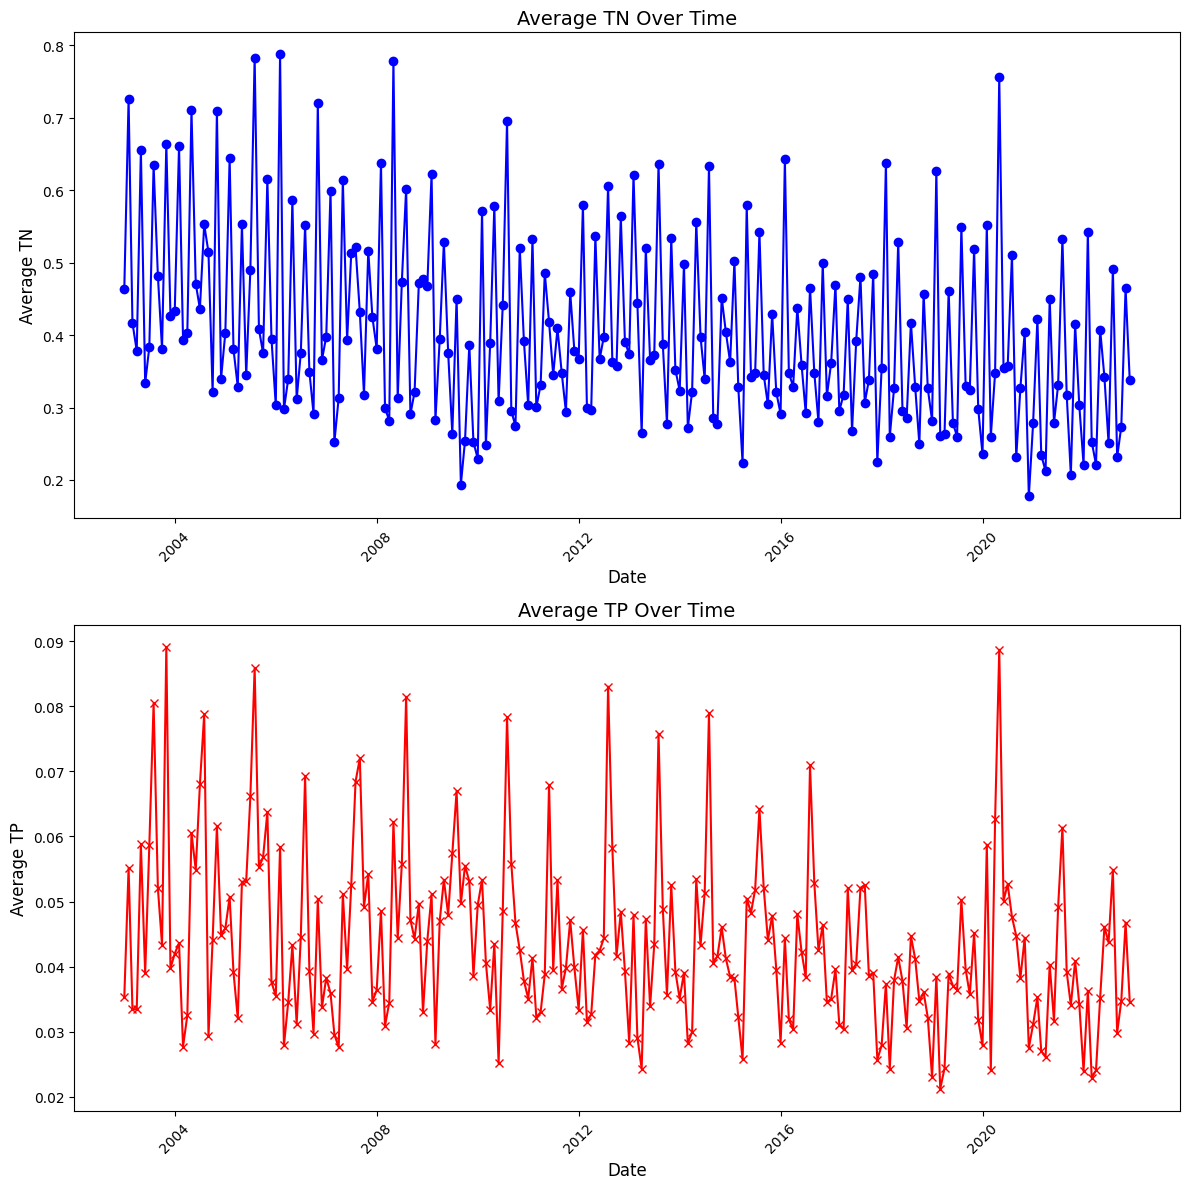

In [30]:
# Create a figure and subplots
fig, axes = plt.subplots(2, 1, figsize=(12, 12))

# Plotting "tn" on the first subplot
axes[0].plot(df_tntp_ave['date'], df_tntp_ave['tn_ave'], marker='o', linestyle='-', color='blue', label='Average TN')
axes[0].set_title('Average TN Over Time', fontsize=14)
axes[0].set_xlabel('Date', fontsize=12)
axes[0].set_ylabel('Average TN', fontsize=12)
#axes[0].legend()
axes[0].tick_params(axis='x', rotation=45)

# Plotting "tp" on the second subplot
axes[1].plot(df_tntp_ave['date'], df_tntp_ave['tp_ave'], marker='x', linestyle='-', color='red', label='Average TP')
axes[1].set_title('Average TP Over Time', fontsize=14)
axes[1].set_xlabel('Date', fontsize=12)
axes[1].set_ylabel('Average TP', fontsize=12)
#axes[1].legend()
axes[1].tick_params(axis='x', rotation=45)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


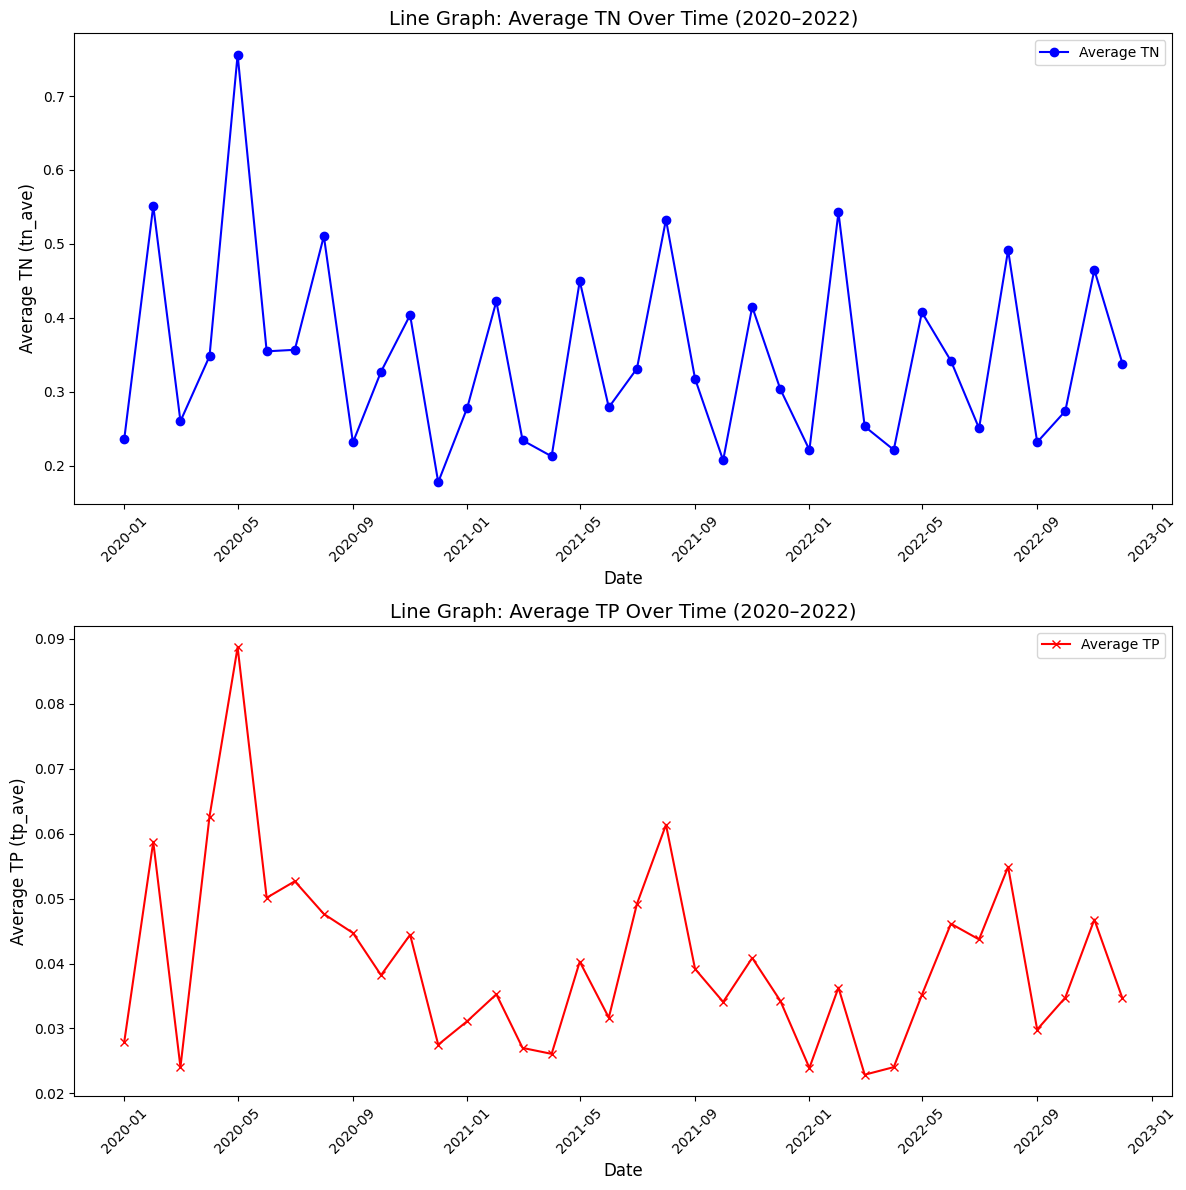

In [31]:
# Determine the last three years in the dataset
last_year = df_tntp_ave['date'].dt.year.max()
last_three_years = [last_year - 2, last_year - 1, last_year]

# Filter data for the last three years
df_filtered = df_tntp_ave[df_tntp_ave['date'].dt.year.isin(last_three_years)]

# Create a figure and subplots
fig, axes = plt.subplots(2, 1, figsize=(12, 12))

# Plotting "tn" for the last three years on the first subplot
axes[0].plot(df_filtered['date'], df_filtered['tn_ave'], marker='o', linestyle='-', color='blue', label='Average TN')
axes[0].set_title(f'Line Graph: Average TN Over Time ({last_three_years[0]}–{last_three_years[-1]})', fontsize=14)
axes[0].set_xlabel('Date', fontsize=12)
axes[0].set_ylabel('Average TN (tn_ave)', fontsize=12)
axes[0].legend()
axes[0].tick_params(axis='x', rotation=45)

# Plotting "tp" for the last three years on the second subplot
axes[1].plot(df_filtered['date'], df_filtered['tp_ave'], marker='x', linestyle='-', color='red', label='Average TP')
axes[1].set_title(f'Line Graph: Average TP Over Time ({last_three_years[0]}–{last_three_years[-1]})', fontsize=14)
axes[1].set_xlabel('Date', fontsize=12)
axes[1].set_ylabel('Average TP (tp_ave)', fontsize=12)
axes[1].legend()
axes[1].tick_params(axis='x', rotation=45)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


# Merge data frames and add time lag term

In [32]:
# Merge df_red, df_wtemp, df_cod_ave, and df_tntp_grouped on 'date'
merged_df = (
    df_red[['date', 'red_tide_days']]  # Select relevant columns from df_red
    .merge(df_wtemp[['date', 'wtemp_ave']], on='date', how='inner')  # Merge with df_wtemp
    .merge(df_cod_ave, on='date', how='inner')  # Merge with df_cod_ave
    .merge(df_tntp_ave, on='date', how='inner')  # Merge with df_tntp_grouped
)

# Extract the years from the index
merged_df["year"] = merged_df["date"].dt.year

merged_lag_df = merged_df.copy()
merged_lag_df['red_tide_days_lag1y'] = merged_lag_df['red_tide_days'].shift(12)
# Drop rows with NaN due to lagging
merged_lag_df = merged_lag_df.dropna()

# Display the resulting DataFrame
display(merged_df)
display(merged_lag_df)

null_values = merged_df.isnull().sum()
print(null_values)

null_lag_values = merged_lag_df.isnull().sum()
print(null_lag_values)

date  red_tide_days  wtemp_ave   cod_ave    tn_ave    tp_ave  year
0   2003-01-01              1  13.065556  2.878788  0.463750  0.035292  2003
1   2003-02-01              1  11.152222  3.157143  0.725143  0.055143  2003
2   2003-03-01              1  11.084444  2.515152  0.416667  0.033458  2003
3   2003-04-01             11  12.792222  3.296970  0.378333  0.033417  2003
4   2003-05-01             19  15.865556  3.697143  0.654857  0.058771  2003
..         ...            ...        ...       ...       ...       ...   ...
235 2022-08-01              8  24.371111  3.494286  0.491714  0.054886  2022
236 2022-09-01              6  25.240000  2.887879  0.231667  0.029833  2022
237 2022-10-01             15  23.644444  2.524242  0.273750  0.034750  2022
238 2022-11-01              0  21.101111  2.162857  0.464857  0.046771  2022
239 2022-12-01              1  17.555556  2.351515  0.337917  0.034625  2022

[240 rows x 7 columns]

date  red_tide_days  wtemp_ave   cod_ave    tn_ave    tp_ave  year  \
12  2004-01-01              0  13.065556  2.581818  0.433750  0.042000  2004   
13  2004-02-01             13  11.152222  2.885714  0.660286  0.043629  2004   
14  2004-03-01             31  11.084444  3.024242  0.393750  0.027708  2004   
15  2004-04-01             20  12.792222  2.866667  0.403333  0.032500  2004   
16  2004-05-01              2  15.865556  3.357143  0.710000  0.060543  2004   
..         ...            ...        ...       ...       ...       ...   ...   
235 2022-08-01              8  24.371111  3.494286  0.491714  0.054886  2022   
236 2022-09-01              6  25.240000  2.887879  0.231667  0.029833  2022   
237 2022-10-01             15  23.644444  2.524242  0.273750  0.034750  2022   
238 2022-11-01              0  21.101111  2.162857  0.464857  0.046771  2022   
239 2022-12-01              1  17.555556  2.351515  0.337917  0.034625  2022   

     red_tide_days_lag1y  
12                   1.0  
13                   1.0  
14                   1.0  
15                  11.0  
16                  19.0  
..                   ...  
235                 20.0  
236                 16.0  
237                 28.0  
238                  1.0  
239                  0.0  

[228 rows x 8 columns]

date             0
red_tide_days    0
wtemp_ave        0
cod_ave          0
tn_ave           0
tp_ave           0
year             0
dtype: int64
date                   0
red_tide_days          0
wtemp_ave              0
cod_ave                0
tn_ave                 0
tp_ave                 0
year                   0
red_tide_days_lag1y    0
dtype: int64


In [33]:
merged_df.describe().T

count                 mean                  min  \
date             240  2012-12-15 17:00:00  2003-01-01 00:00:00   
red_tide_days  240.0             9.879167                  0.0   
wtemp_ave      240.0            18.116481            11.084444   
cod_ave        240.0             2.863057             1.831429   
tn_ave         240.0             0.406763               0.1775   
tp_ave         240.0             0.043801             0.021208   
year           240.0               2012.5               2003.0   

                               25%                  50%                  75%  \
date           2007-12-24 06:00:00  2012-12-16 12:00:00  2017-12-08 18:00:00   
red_tide_days                  1.0                  8.0                 16.0   
wtemp_ave                12.997222            18.391667            22.634444   
cod_ave                   2.460606             2.835325             3.193896   
tn_ave                    0.306042             0.377083             0.486682   
tp_ave                    0.034615               0.0414             0.050786   
year                       2007.75               2012.5              2017.25   

                               max       std  
date           2022-12-01 00:00:00       NaN  
red_tide_days                 31.0  9.477014  
wtemp_ave                    25.24  5.054025  
cod_ave                   4.239394  0.511846  
tn_ave                    0.787143  0.131042  
tp_ave                    0.089143  0.013268  
year                        2022.0  5.778332

In [34]:
merged_lag_df.describe().T

count                           mean  \
date                   228  2013-06-16 08:25:15.789473792   
red_tide_days        228.0                       9.947368   
wtemp_ave            228.0                      18.116481   
cod_ave              228.0                       2.856598   
tn_ave               228.0                       0.402109   
tp_ave               228.0                       0.043394   
year                 228.0                         2013.0   
red_tide_days_lag1y  228.0                      10.105263   

                                     min                  25%  \
date                 2004-01-01 00:00:00  2008-09-23 12:00:00   
red_tide_days                        0.0                  1.0   
wtemp_ave                      11.084444            12.997222   
cod_ave                         1.831429             2.459848   
tn_ave                            0.1775             0.303229   
tp_ave                          0.021208             0.034562   
year                              2004.0               2008.0   
red_tide_days_lag1y                  0.0                  1.0   

                                     50%                  75%  \
date                 2013-06-16 00:00:00  2018-03-08 18:00:00   
red_tide_days                        8.5                 16.0   
wtemp_ave                      18.391667            22.634444   
cod_ave                         2.830303             3.179545   
tn_ave                          0.369375             0.485071   
tp_ave                          0.041296             0.050271   
year                              2013.0               2018.0   
red_tide_days_lag1y                  9.0                 17.0   

                                     max       std  
date                 2022-12-01 00:00:00       NaN  
red_tide_days                       31.0  9.423789  
wtemp_ave                          25.24  5.054582  
cod_ave                         4.239394  0.512859  
tn_ave                          0.787143  0.129418  
tp_ave                          0.088714  0.012882  
year                              2022.0  5.489277  
red_tide_days_lag1y                 31.0  9.557494

# Skewness

In [35]:
skewness = merged_df.drop(columns=['date', 'red_tide_days', 'year']).skew()
print('Skewness:\n', skewness)

Skewness:
 wtemp_ave   -0.065839
cod_ave      0.352465
tn_ave       0.788771
tp_ave       1.047975
dtype: float64


In [36]:
skewness_lag = merged_lag_df.drop(columns=['date', 'red_tide_days', 'year']).skew()
print('Skewness:\n', skewness_lag)

Skewness:
 wtemp_ave             -0.065861
cod_ave                0.387735
tn_ave                 0.814854
tp_ave                 0.993809
red_tide_days_lag1y    0.638624
dtype: float64


# Distribution

## Without time lag term

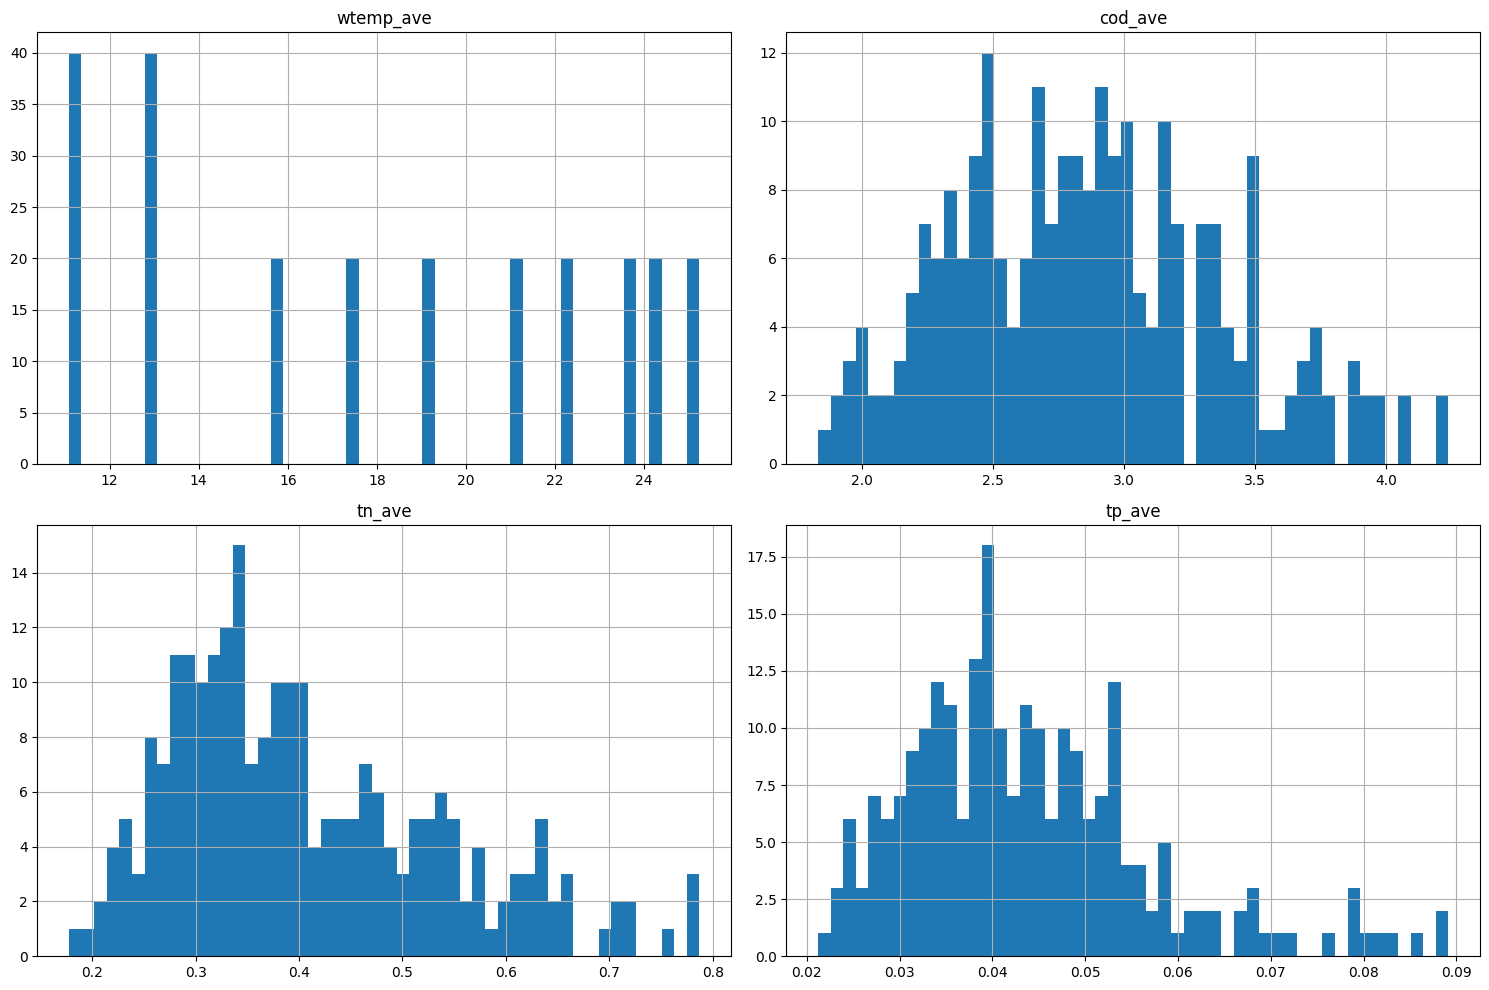

In [37]:
merged_df.drop(columns=['date', 'red_tide_days', 'year']).hist(figsize=(15, 10), layout=(2, 2), bins=50)

plt.tight_layout()
plt.show()

## With time lag term

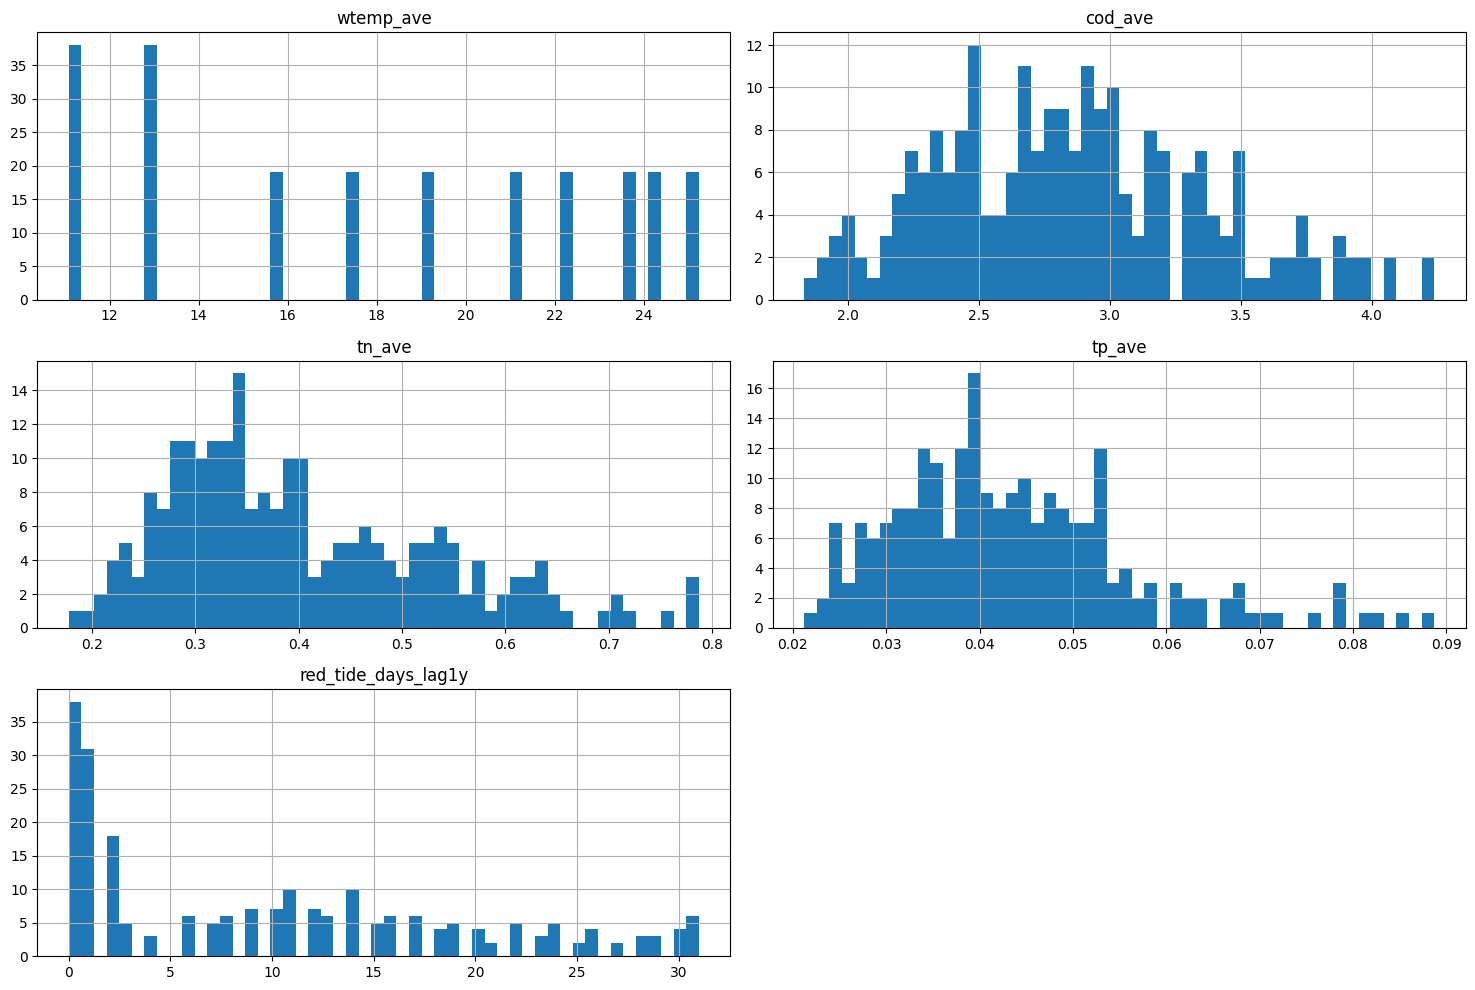

In [38]:
merged_lag_df.drop(columns=['date', 'red_tide_days', 'year']).hist(figsize=(15, 10), layout=(3, 2), bins=50)

plt.tight_layout()
plt.show()

# Correlation

## without time lag term

wtemp_ave    0.136300
cod_ave      0.438104
tn_ave       0.012176
tp_ave       0.197007
Name: red_tide_days, dtype: float64


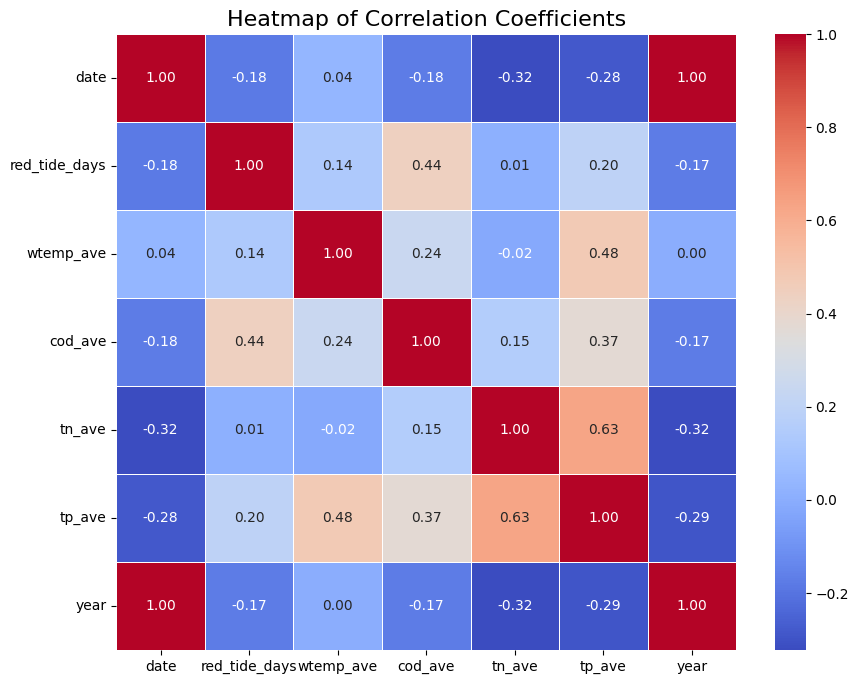

In [39]:
corr = merged_df.corr()
corr_red_tide = merged_df.corr()['red_tide_days'].drop(['date', 'red_tide_days', 'year'])
print(corr_red_tide)

# Create the heatmap
plt.figure(figsize=(10, 8))  # Adjust the figure size as needed
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5, cbar=True)

# Add title
plt.title("Heatmap of Correlation Coefficients", fontsize=16)
plt.show()

## With time lag term

wtemp_ave              0.125424
cod_ave                0.431158
tn_ave                 0.017379
tp_ave                 0.192891
red_tide_days_lag1y    0.406608
Name: red_tide_days, dtype: float64


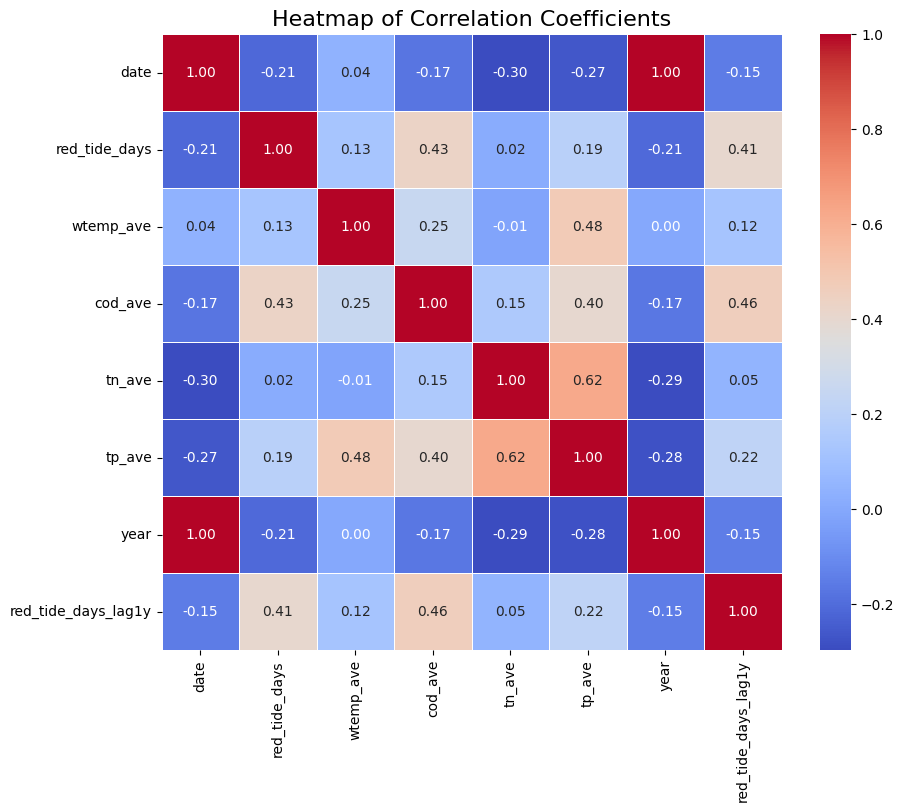

In [40]:
corr_lag = merged_lag_df.corr()
corr_red_tide_lag = merged_lag_df.corr()['red_tide_days'].drop(['date', 'red_tide_days', 'year'])
print(corr_red_tide_lag)

# Create the heatmap
plt.figure(figsize=(10, 8))  # Adjust the figure size as needed
sns.heatmap(corr_lag, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5, cbar=True)

# Add title
plt.title("Heatmap of Correlation Coefficients", fontsize=16)
plt.show()

# Box-Cox transformation

## Without time lag term

In [41]:
df_trans = merged_df.copy()

# Apply Box-Cox transformation (requires positive values)
df_trans['tn_ave_boxcox'], tn_lambda = boxcox(df_trans['tn_ave'])
df_trans['tp_ave_boxcox'], tp_lambda = boxcox(df_trans['tp_ave'])
df_trans = df_trans.drop(['tn_ave', 'tp_ave'], axis=1)
# Check the transformed data
display(df_trans.head())

date  red_tide_days  wtemp_ave   cod_ave  year  tn_ave_boxcox  \
0 2003-01-01              1  13.065556  2.878788  2003      -0.843387   
1 2003-02-01              1  11.152222  3.157143  2003      -0.334034   
2 2003-03-01              1  11.084444  2.515152  2003      -0.973654   
3 2003-04-01             11  12.792222  3.296970  2003      -1.093974   
4 2003-05-01             19  15.865556  3.697143  2003      -0.445465   

   tp_ave_boxcox  
0      -5.405317  
1      -4.376618  
2      -5.536700  
3      -5.539791  
4      -4.239482

## With time lag term

In [42]:
df_lag_trans = merged_lag_df.copy()

# Apply Box-Cox transformation (requires positive values)
df_lag_trans['tn_ave_boxcox'], tn_lambda = boxcox(df_lag_trans['tn_ave'])
df_lag_trans['tp_ave_boxcox'], tp_lambda = boxcox(df_lag_trans['tp_ave'])
df_lag_trans = df_lag_trans.drop(['tn_ave', 'tp_ave'], axis=1)
# Check the transformed data
display(df_lag_trans.head())

date  red_tide_days  wtemp_ave   cod_ave  year  red_tide_days_lag1y  \
12 2004-01-01              0  13.065556  2.581818  2004                  1.0   
13 2004-02-01             13  11.152222  2.885714  2004                  1.0   
14 2004-03-01             31  11.084444  3.024242  2004                  1.0   
15 2004-04-01             20  12.792222  2.866667  2004                 11.0   
16 2004-05-01              2  15.865556  3.357143  2004                 19.0   

    tn_ave_boxcox  tp_ave_boxcox  
12      -0.935791      -4.566948  
13      -0.438965      -4.491371  
14      -1.058300      -5.435448  
15      -1.027555      -5.093054  
16      -0.358643      -3.865754

# Skewness after the transformation

## Without time lag term

In [43]:
skewness_trans = df_trans.drop(columns=['date', 'red_tide_days', 'year']).skew()
print(skewness_trans)

wtemp_ave       -0.065839
cod_ave          0.352465
tn_ave_boxcox    0.015170
tp_ave_boxcox    0.005279
dtype: float64


## With time lag term

In [44]:
skewness_lag_trans = df_lag_trans.drop(columns=['date', 'red_tide_days', 'year']).skew()
print(skewness_lag_trans)

wtemp_ave             -0.065861
cod_ave                0.387735
red_tide_days_lag1y    0.638624
tn_ave_boxcox          0.016912
tp_ave_boxcox          0.004453
dtype: float64


# Distribution after the transformation

## Without time lag term

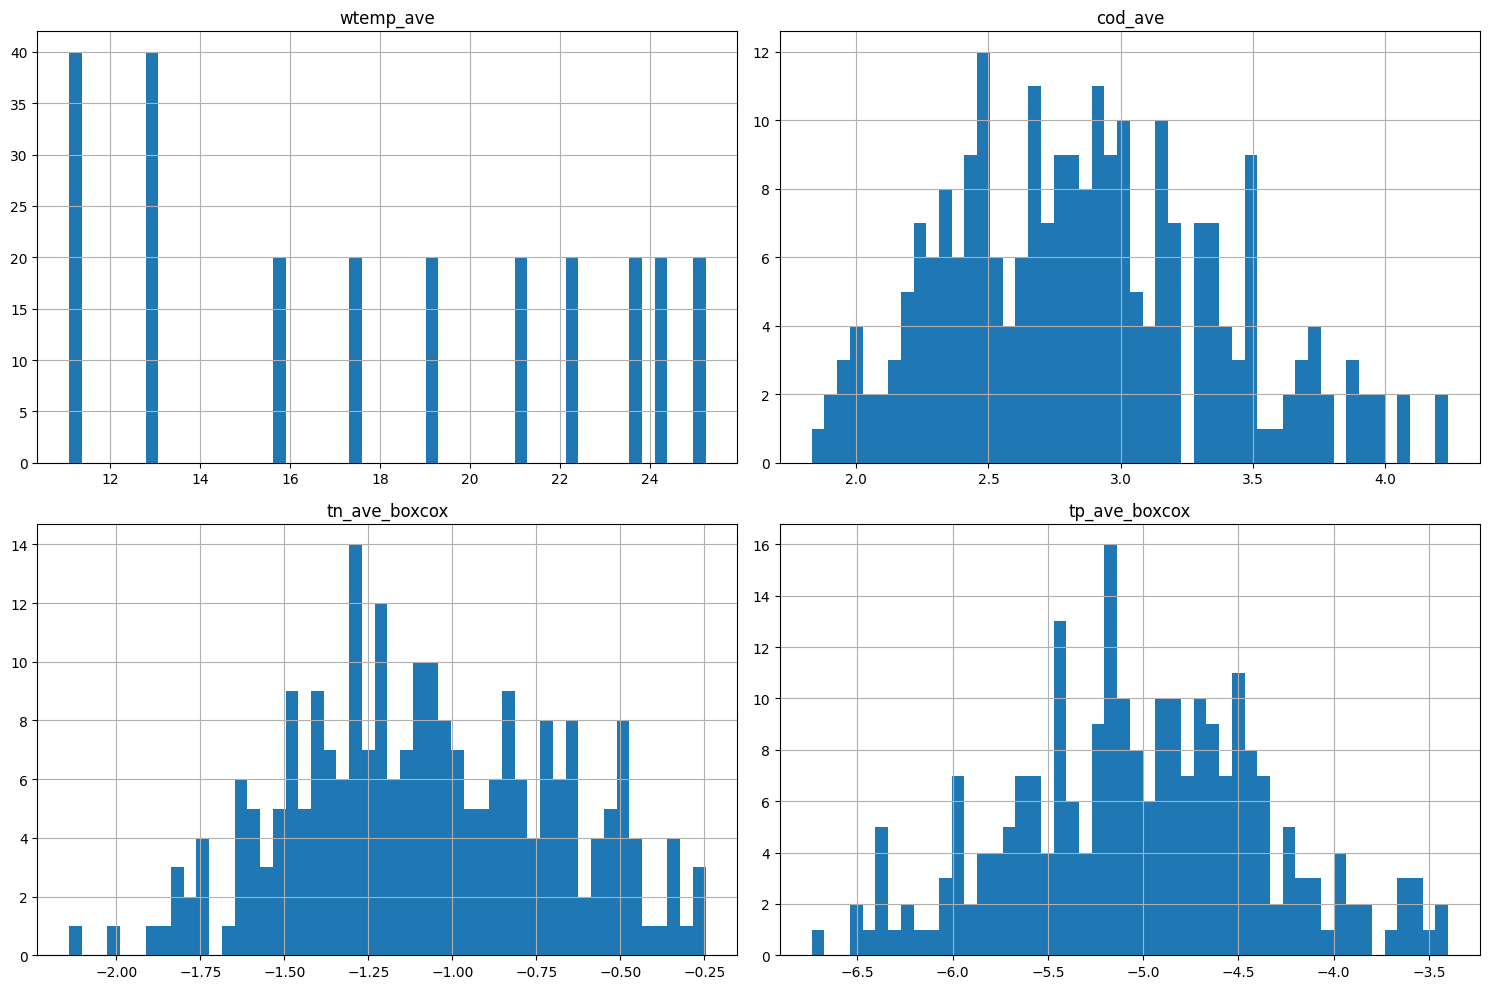

In [45]:
df_trans.drop(columns=['date', 'red_tide_days', 'year']).hist(figsize=(15, 10), layout=(2, 2), bins=50)

plt.tight_layout()
plt.show()

## With time lag term

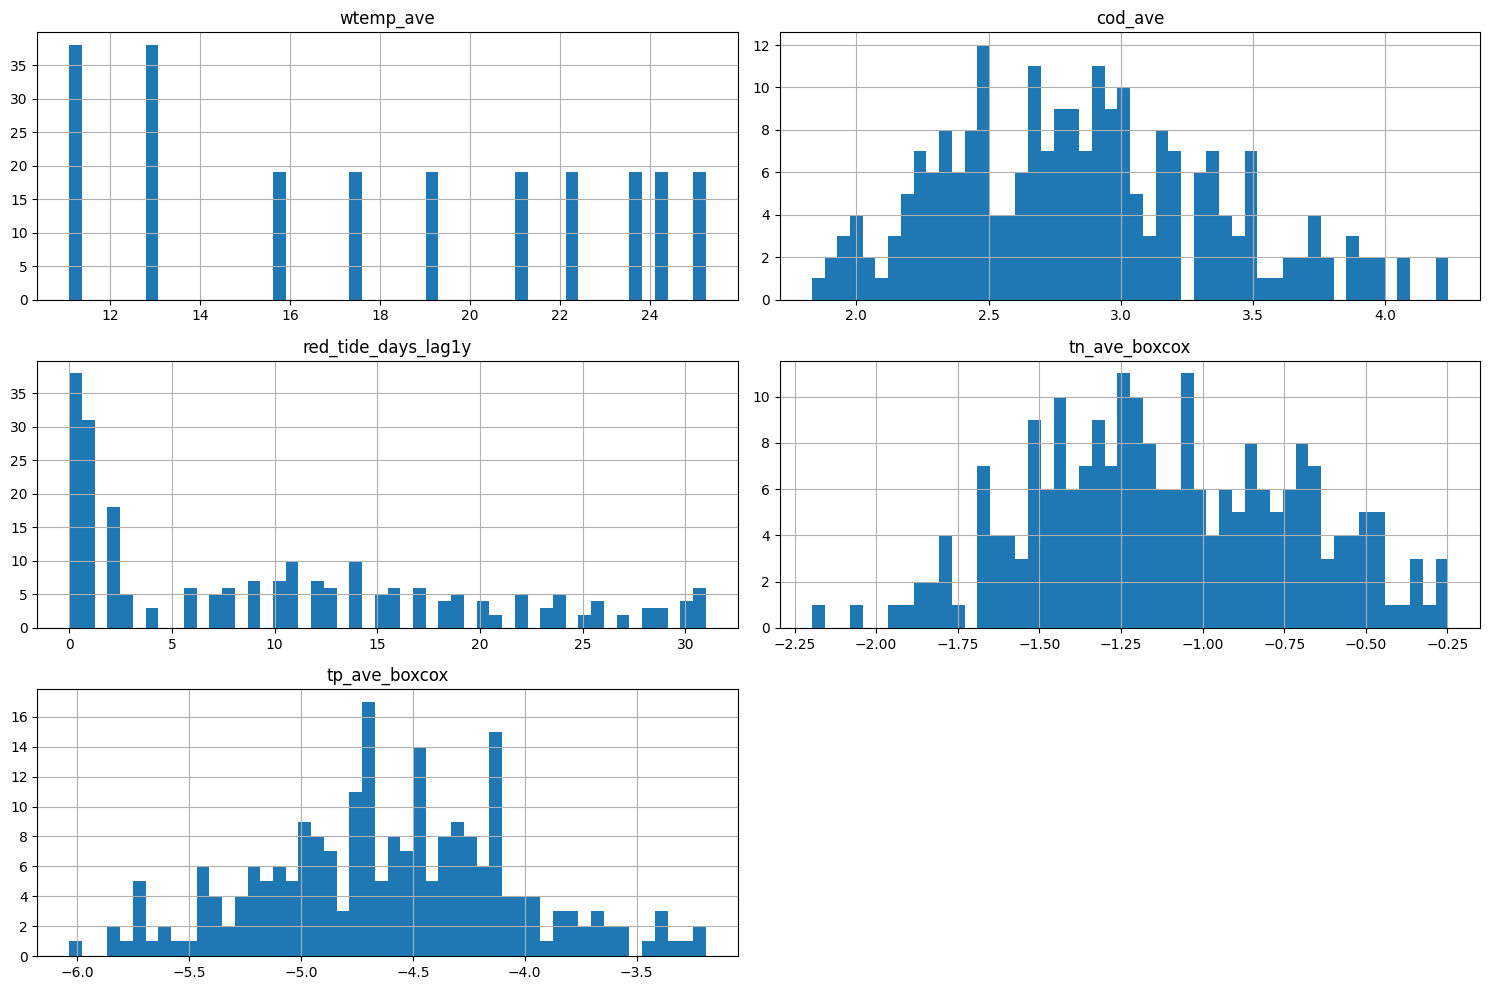

In [46]:
df_lag_trans.drop(columns=['date', 'red_tide_days', 'year']).hist(figsize=(15, 10), layout=(3, 2), bins=50)

plt.tight_layout()
plt.show()

# Correlation after the transformation

## Without time lag term

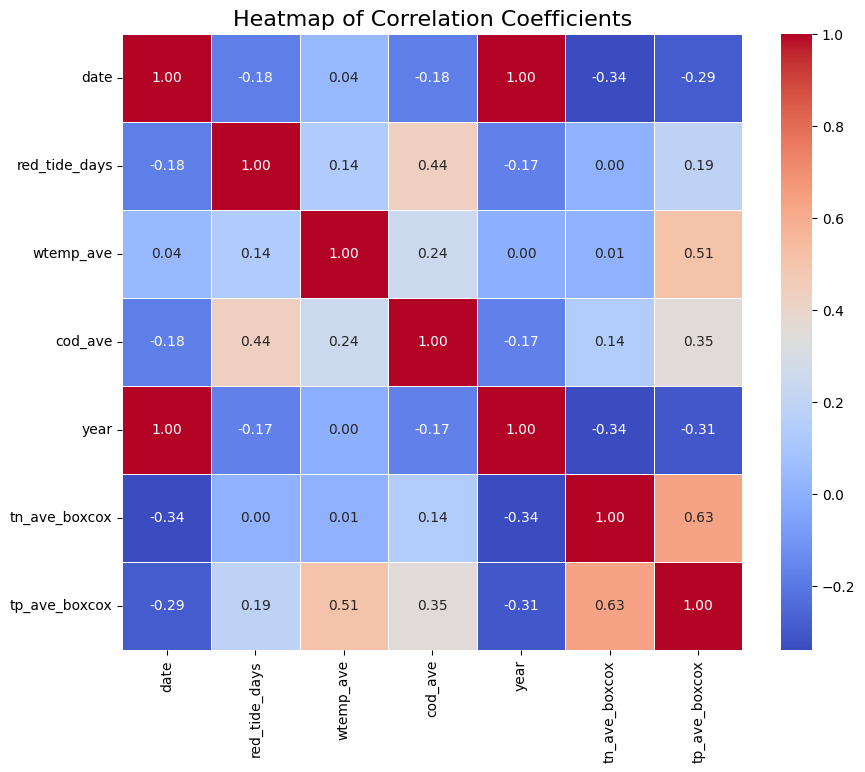

In [47]:
corr_trans = df_trans.corr()

# Create the heatmap
plt.figure(figsize=(10, 8))  # Adjust the figure size as needed
sns.heatmap(corr_trans, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5, cbar=True)

# Add title
plt.title("Heatmap of Correlation Coefficients", fontsize=16)
plt.show()

## With time lag term

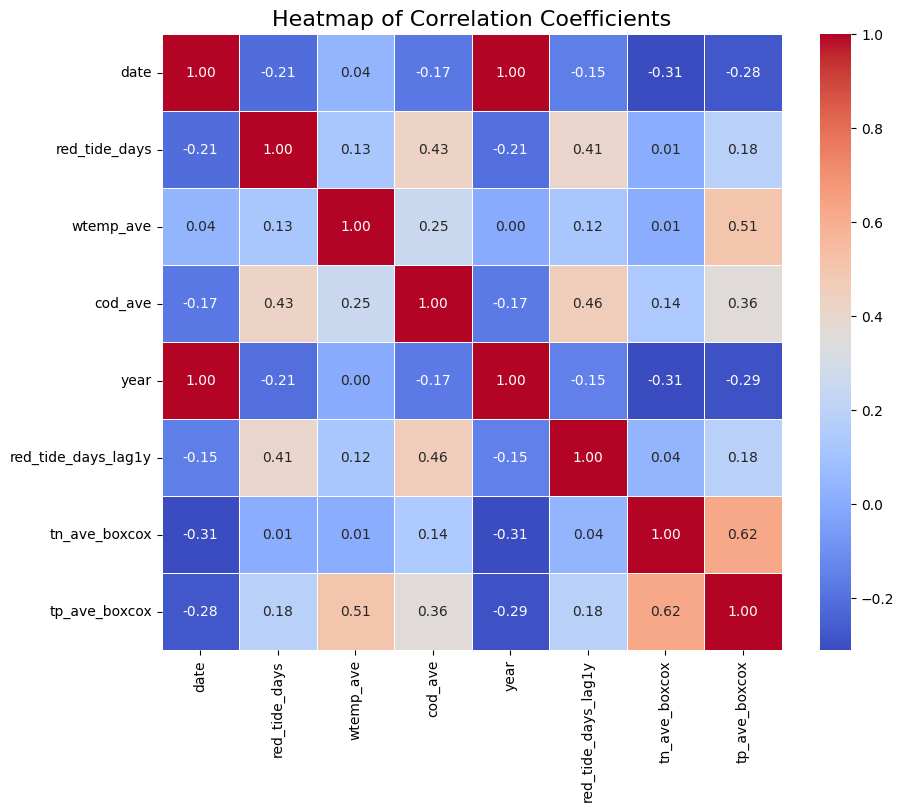

In [48]:
corr_lag_trans = df_lag_trans.corr()

# Create the heatmap
plt.figure(figsize=(10, 8))  # Adjust the figure size as needed
sns.heatmap(corr_lag_trans, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5, cbar=True)

# Add title
plt.title("Heatmap of Correlation Coefficients", fontsize=16)
plt.show()

# Scaling

## Without time lag term

In [49]:
features_to_scale = ['wtemp_ave', 'cod_ave', 'tn_ave_boxcox', 'tp_ave_boxcox']

# Initialize the scaler
scaler = StandardScaler()

# Scale the selected features
df_trans[features_to_scale] = scaler.fit_transform(df_trans[features_to_scale])

# Display the scaled data
display(df_trans.head())

#display(df_trans.describe().T)

date  red_tide_days  wtemp_ave   cod_ave  year  tn_ave_boxcox  \
0 2003-01-01              1  -1.001475  0.030797  2003       0.605113   
1 2003-02-01              1  -1.380843  0.575759  2003       1.912280   
2 2003-03-01              1  -1.394281 -0.681128  2003       0.270805   
3 2003-04-01             11  -1.055671  0.849511  2003      -0.037975   
4 2003-05-01             19  -0.446304  1.632968  2003       1.626313   

   tp_ave_boxcox  
0      -0.580868  
1       0.954550  
2      -0.776967  
3      -0.781581  
4       1.159236

## With time lag term

In [50]:
features_to_scale_lag = ['wtemp_ave', 'cod_ave', 'tn_ave_boxcox', 'tp_ave_boxcox', 'red_tide_days_lag1y']

# Initialize the scaler
scaler_lag = StandardScaler()

# Scale the selected features
df_lag_trans[features_to_scale_lag] = scaler_lag.fit_transform(df_lag_trans[features_to_scale_lag])

# Display the scaled data
display(df_lag_trans.head())

date  red_tide_days  wtemp_ave   cod_ave  year  red_tide_days_lag1y  \
12 2004-01-01              0  -1.001475 -0.536960  2004            -0.954779   
13 2004-02-01             13  -1.380843  0.056898  2004            -0.954779   
14 2004-03-01             31  -1.394281  0.327602  2004            -0.954779   
15 2004-04-01             20  -1.055671  0.019676  2004             0.093822   
16 2004-05-01              2  -0.446304  0.978138  2004             0.932703   

    tn_ave_boxcox  tp_ave_boxcox  
12       0.437822       0.060533  
13       1.681333       0.193860  
14       0.131192      -1.471599  
15       0.208145      -0.867578  
16       1.882371       1.297520

# Distribution after the scaling

## Without time lag term

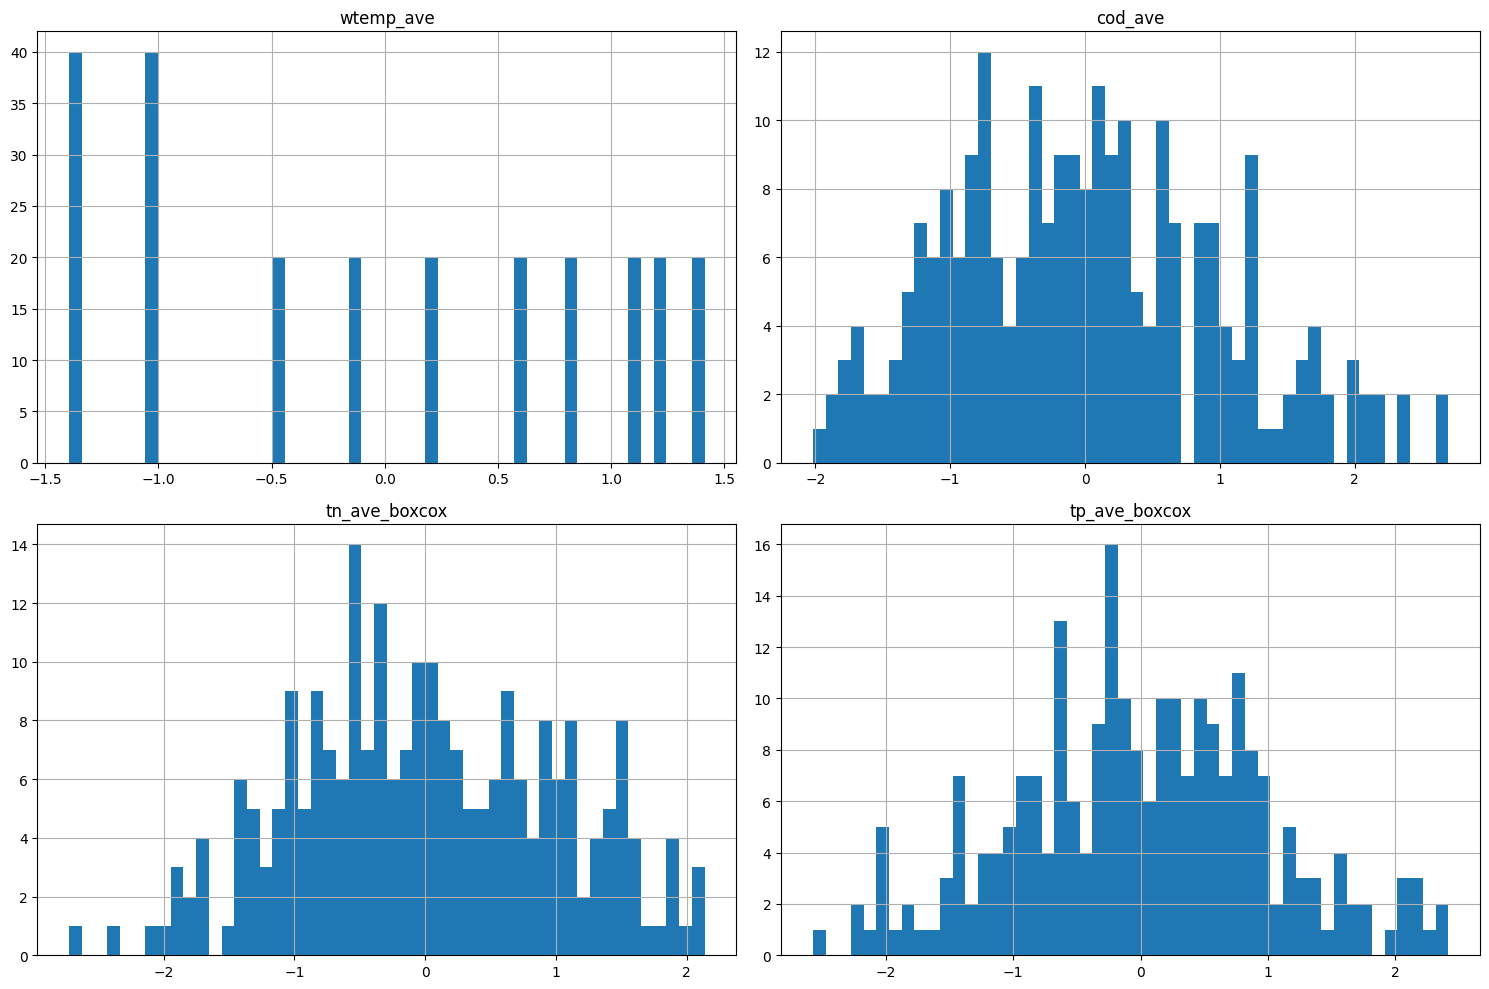

In [51]:
df_trans.drop(columns=['date', 'red_tide_days', 'year']).hist(figsize=(15, 10), layout=(2, 2), bins=50)

plt.tight_layout()
plt.show()

## With time lag term

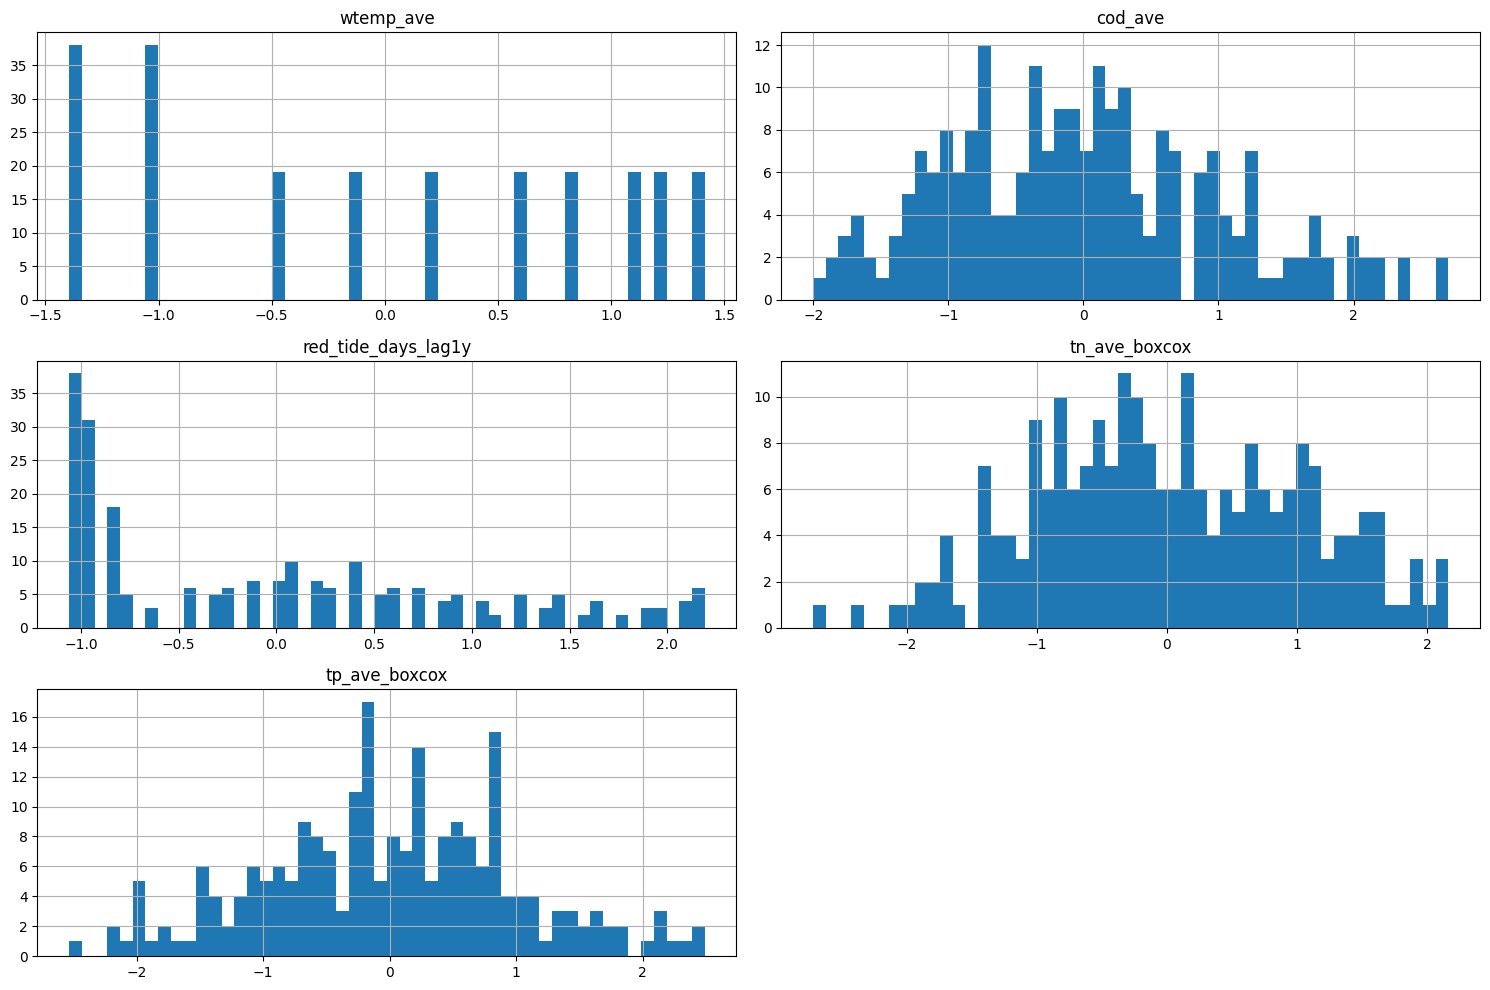

In [52]:
df_lag_trans.drop(columns=['date', 'red_tide_days', 'year']).hist(figsize=(15, 10), layout=(3, 2), bins=50)

plt.tight_layout()
plt.show()

# Preparing for data splitting and data frames for buiding each model

In [53]:
# Define train, validation, and test periods
unique_years = merged_df["year"].unique()
train_years = int(len(unique_years) * 0.70)  # First 70% of years for training
print("train_years: ", train_years)
val_years = int(len(unique_years) * 0.15)    # Next 15% for validation
print("val_years: ", val_years)
test_years = len(unique_years) - (train_years + val_years)  # Remaining years for testing
print("test_years: ", test_years)

# Identify cutoff years
train_end_year = unique_years[train_years - 1]  # Last year of training
print("train_end_year: ", train_end_year)
val_end_year = unique_years[train_years + val_years - 1]  # Last year of validation
print("val_end_year: ", val_end_year)

thresholds = list(range(1, 29))  # Thresholds from 1 to 28

df_logistic = merged_df.copy()
df_trans_logistic = df_trans.copy()

df_logistic_lag = merged_lag_df.copy()
df_trans_logistic_lag = df_lag_trans.copy()

df_majority = df_trans_logistic_lag.copy()
df_random = df_trans_logistic_lag.copy()

df_logistic_lag_forward = df_logistic_lag.copy()
df_trans_logistic_lag_forward = df_trans_logistic_lag.copy()

df_dt = df_trans.copy()
df_dt_lag = df_trans_logistic_lag.copy()

df_rf = df_trans.copy()
df_rf_lag = df_trans_logistic_lag.copy()

df_cv_logistic = df_trans_logistic_lag.copy()
df_cv_dt = df_trans_logistic_lag.copy()


train_years:  14
val_years:  3
test_years:  3
train_end_year:  2016
val_end_year:  2019


# Threshold evaluation

## Logistic regression model using raw data

In [54]:
# Placeholder for the results of each threshold
results_logstic = []

# Loop over each threshold value
for threshold in thresholds:
    # Create the binary column for red tide occurrence based on the threshold
    df_logistic['red_tide_occurred'] = (df_logistic['red_tide_days'] >= threshold).astype(int)
    
    # Split based on years
    train_df_logistic = df_logistic[df_logistic["year"] <= train_end_year]
    val_df_logistic = df_logistic[(df_logistic["year"] > train_end_year) & (df_logistic["year"] <= val_end_year)]
    test_df_logistic = df_logistic[df_logistic["year"] > val_end_year]

    # Split the data into features (X) and target (y)
    X_train = train_df_logistic[['wtemp_ave', 'cod_ave', 'tn_ave', 'tp_ave']]  # Features (can be adjusted based on your dataset)
    y_train = train_df_logistic['red_tide_occurred']  # Target variable
    X_val = val_df_logistic[['wtemp_ave', 'cod_ave', 'tn_ave', 'tp_ave']]  # Features (can be adjusted based on your dataset)
    y_val = val_df_logistic['red_tide_occurred']  # Target variable
    
    # Train a logistic regression model
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_val)
    
    if threshold == 14:
        # Compute confusion matrix
        tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()

        # Display the table
        conf_matrix_df = pd.DataFrame(
            [[tn, fp], [fn, tp]],
            columns=['Predicted Negative', 'Predicted Positive'],
            index=['Actual Negative', 'Actual Positive']
        )

        display(conf_matrix_df)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    
    # Store the results for the current threshold
    results_logstic.append({
        'threshold': threshold,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    })

# Convert results into a DataFrame
results_df_logistic = pd.DataFrame(results_logstic)

# Display the results DataFrame
display(results_df_logistic)


Predicted Negative  Predicted Positive
Actual Negative                  27                   0
Actual Positive                   9                   0

c:\Users\jsmeg\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\jsmeg\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\jsmeg\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

threshold  accuracy  precision    recall  f1_score
0           1  0.777778   0.777778  1.000000  0.875000
1           2  0.694444   0.687500  0.956522  0.800000
2           3  0.833333   0.869565  0.869565  0.869565
3           4  0.750000   0.772727  0.809524  0.790698
4           5  0.750000   0.727273  0.842105  0.780488
5           6  0.750000   0.727273  0.842105  0.780488
6           7  0.722222   0.736842  0.736842  0.736842
7           8  0.777778   0.823529  0.736842  0.777778
8           9  0.694444   0.833333  0.526316  0.645161
9          10  0.694444   0.700000  0.466667  0.560000
10         11  0.666667   0.714286  0.333333  0.454545
11         12  0.777778   0.833333  0.416667  0.555556
12         13  0.750000   0.750000  0.272727  0.400000
13         14  0.750000   0.000000  0.000000  0.000000
14         15  0.777778   0.000000  0.000000  0.000000
15         16  0.777778   0.000000  0.000000  0.000000
16         17  0.805556   0.000000  0.000000  0.000000
17         18  0.861111   0.000000  0.000000  0.000000
18         19  0.861111   0.000000  0.000000  0.000000
19         20  0.861111   0.000000  0.000000  0.000000
20         21  0.861111   0.000000  0.000000  0.000000
21         22  0.861111   0.000000  0.000000  0.000000
22         23  0.888889   0.000000  0.000000  0.000000
23         24  0.888889   0.000000  0.000000  0.000000
24         25  0.888889   0.000000  0.000000  0.000000
25         26  0.888889   0.000000  0.000000  0.000000
26         27  0.916667   0.000000  0.000000  0.000000
27         28  0.944444   0.000000  0.000000  0.000000

## Logistic regression model after the tramsformation and the scaling

In [55]:
# Placeholder for the results of each threshold
results_trans_logstic = []

# Loop over each threshold value
for threshold in thresholds:
    # Create the binary column for red tide occurrence based on the threshold
    df_trans_logistic['red_tide_occurred'] = (df_trans_logistic['red_tide_days'] >= threshold).astype(int)
    
    # Split based on years
    train_df_trans_logistic = df_trans_logistic[df_trans_logistic["year"] <= train_end_year]
    val_df_trans_logistic = df_trans_logistic[(df_trans_logistic["year"] > train_end_year) & (df_trans_logistic["year"] <= val_end_year)]
    test_df_trans_logistic = df_trans_logistic[df_trans_logistic["year"] > val_end_year]

    # Split the data into features (X) and target (y)
    X_train = train_df_trans_logistic[['wtemp_ave', 'cod_ave', 'tn_ave_boxcox', 'tp_ave_boxcox']]  # Features (can be adjusted based on your dataset)
    y_train = train_df_trans_logistic['red_tide_occurred']  # Target variable
    X_val = val_df_trans_logistic[['wtemp_ave', 'cod_ave', 'tn_ave_boxcox', 'tp_ave_boxcox']]  # Features (can be adjusted based on your dataset)
    y_val = val_df_trans_logistic['red_tide_occurred']  # Target variable
   
    # Train a logistic regression model
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_val)
    
    if threshold == 15:
        # Compute confusion matrix
        tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()

        # Display the table
        conf_matrix_df = pd.DataFrame(
            [[tn, fp], [fn, tp]],
            columns=['Predicted Negative', 'Predicted Positive'],
            index=['Actual Negative', 'Actual Positive']
        )

        display(conf_matrix_df)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    
    # Store the results for the current threshold
    results_trans_logstic.append({
        'threshold': threshold,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    })

# Convert results into a DataFrame
results_df_trans_logistic = pd.DataFrame(results_trans_logstic)

# Display the results DataFrame
display(results_df_trans_logistic)

Predicted Negative  Predicted Positive
Actual Negative                  28                   0
Actual Positive                   7                   1

c:\Users\jsmeg\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\jsmeg\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\jsmeg\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

threshold  accuracy  precision    recall  f1_score
0           1  0.777778   0.777778  1.000000  0.875000
1           2  0.861111   0.821429  1.000000  0.901961
2           3  0.861111   0.909091  0.869565  0.888889
3           4  0.750000   0.772727  0.809524  0.790698
4           5  0.694444   0.681818  0.789474  0.731707
5           6  0.694444   0.681818  0.789474  0.731707
6           7  0.694444   0.750000  0.631579  0.685714
7           8  0.666667   0.818182  0.473684  0.600000
8           9  0.694444   0.833333  0.526316  0.645161
9          10  0.722222   0.727273  0.533333  0.615385
10         11  0.722222   0.857143  0.400000  0.545455
11         12  0.750000   0.800000  0.333333  0.470588
12         13  0.722222   0.666667  0.181818  0.285714
13         14  0.777778   0.666667  0.222222  0.333333
14         15  0.805556   1.000000  0.125000  0.222222
15         16  0.777778   0.000000  0.000000  0.000000
16         17  0.805556   0.000000  0.000000  0.000000
17         18  0.861111   0.000000  0.000000  0.000000
18         19  0.861111   0.000000  0.000000  0.000000
19         20  0.861111   0.000000  0.000000  0.000000
20         21  0.861111   0.000000  0.000000  0.000000
21         22  0.861111   0.000000  0.000000  0.000000
22         23  0.888889   0.000000  0.000000  0.000000
23         24  0.888889   0.000000  0.000000  0.000000
24         25  0.888889   0.000000  0.000000  0.000000
25         26  0.888889   0.000000  0.000000  0.000000
26         27  0.916667   0.000000  0.000000  0.000000
27         28  0.944444   0.000000  0.000000  0.000000

## Visualization: Logistic regression model using raw data

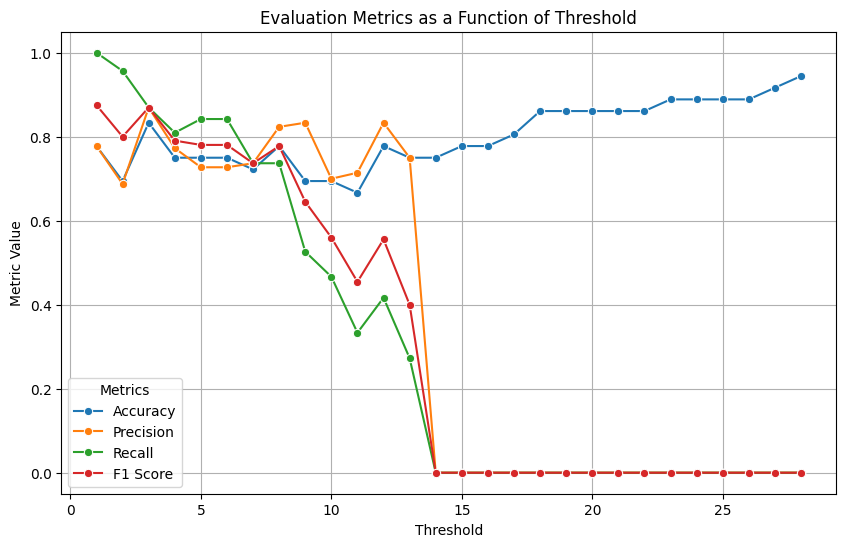

In [56]:
# Set the figure size for better visibility
plt.figure(figsize=(10, 6))

# Plot each metric as a function of threshold
sns.lineplot(data=results_df_logistic, x='threshold', y='accuracy', label='Accuracy', marker='o')
sns.lineplot(data=results_df_logistic, x='threshold', y='precision', label='Precision', marker='o')
sns.lineplot(data=results_df_logistic, x='threshold', y='recall', label='Recall', marker='o')
sns.lineplot(data=results_df_logistic, x='threshold', y='f1_score', label='F1 Score', marker='o')

# Adding titles and labels
plt.title('Evaluation Metrics as a Function of Threshold')
plt.xlabel('Threshold')
plt.ylabel('Metric Value')
plt.legend(title='Metrics')

# Show the plot
plt.grid(True)
plt.show()

## Visualization: Logistic regression model after the tramsformation and the scaling

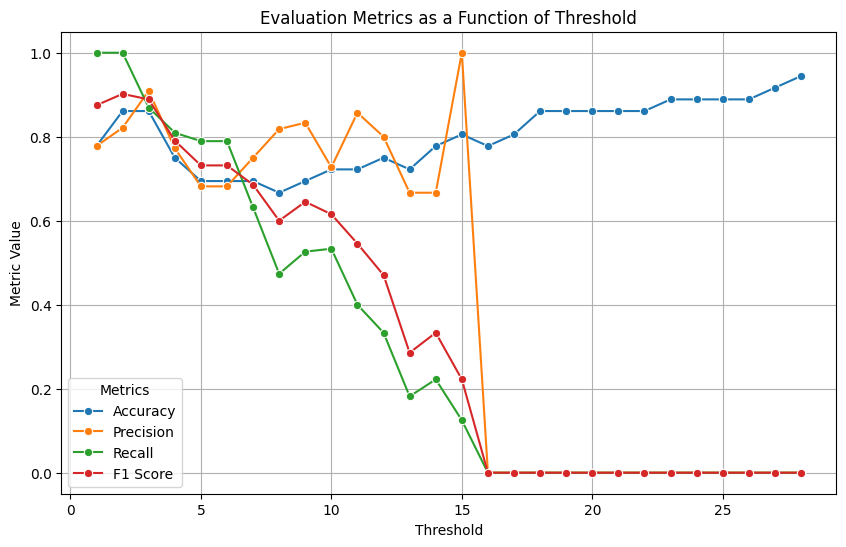

In [57]:
# Set the figure size for better visibility
plt.figure(figsize=(10, 6))

# Plot each metric as a function of threshold
sns.lineplot(data=results_df_trans_logistic, x='threshold', y='accuracy', label='Accuracy', marker='o')
sns.lineplot(data=results_df_trans_logistic, x='threshold', y='precision', label='Precision', marker='o')
sns.lineplot(data=results_df_trans_logistic, x='threshold', y='recall', label='Recall', marker='o')
sns.lineplot(data=results_df_trans_logistic, x='threshold', y='f1_score', label='F1 Score', marker='o')

# Adding titles and labels
plt.title('Evaluation Metrics as a Function of Threshold')
plt.xlabel('Threshold')
plt.ylabel('Metric Value')
plt.legend(title='Metrics')

# Show the plot
plt.grid(True)
plt.show()

## Logistic regression model with time lag term using raw data

In [58]:
results_logstic_lag = []

for threshold in thresholds:
    # Create the binary column for red tide occurrence based on the threshold
    df_logistic_lag['red_tide_occurred'] = (df_logistic_lag['red_tide_days'] >= threshold).astype(int)
    
    # Split based on years
    train_df_logistic_lag = df_logistic_lag[df_logistic_lag["year"] <= train_end_year]
    val_df_logistic_lag = df_logistic_lag[(df_logistic_lag["year"] > train_end_year) & (df_logistic_lag["year"] <= val_end_year)]
    test_df_logistic_lag = df_logistic_lag[df_logistic_lag["year"] > val_end_year]

    # Split the data into features and target
    X_train = train_df_logistic_lag.drop(columns=['date', 'red_tide_days', 'red_tide_occurred', 'year'])
    y_train = train_df_logistic_lag['red_tide_occurred']
    X_val = val_df_logistic_lag.drop(columns=['date', 'red_tide_days', 'red_tide_occurred', 'year'])
    y_val = val_df_logistic_lag['red_tide_occurred']

    # Logistic regression with threshold-based binary target
    threshold_model = LogisticRegression(max_iter=1000)
    threshold_model.fit(X_train, y_train)
    y_pred_test = threshold_model.predict(X_val)

    # Calculate metrics
    accuracy = accuracy_score(y_val, y_pred_test)
    precision = precision_score(y_val, y_pred_test, zero_division=0)
    recall = recall_score(y_val, y_pred_test, zero_division=0)
    f1 = f1_score(y_val, y_pred_test, zero_division=0)
    
    # Store results for the current threshold
    results_logstic_lag.append({
        'threshold': threshold,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    })

# Convert results to DataFrame for visualization
results_df_logistic_lag = pd.DataFrame(results_logstic_lag)


## Logistic regression model with time lag term after the tramsformation and the scaling

In [59]:
results_trans_logstic_lag = []
feature_contributions_all = []

for threshold in thresholds:
    # Create the binary column for red tide occurrence based on the threshold
    df_trans_logistic_lag['red_tide_occurred'] = (df_trans_logistic_lag['red_tide_days'] >= threshold).astype(int)
    
    # Split based on years
    train_df_trans_logistic_lag = df_trans_logistic_lag[df_trans_logistic_lag["year"] <= train_end_year]
    val_df_trans_logistic_lag = df_trans_logistic_lag[(df_trans_logistic_lag["year"] > train_end_year) & (df_trans_logistic_lag["year"] <= val_end_year)]
    test_df_trans_logistic_lag = df_trans_logistic_lag[df_trans_logistic_lag["year"] > val_end_year]

    # Split the data into features and target
    X_train = train_df_trans_logistic_lag.drop(columns=['date', 'red_tide_days', 'red_tide_occurred', 'year'])
    y_train = train_df_trans_logistic_lag['red_tide_occurred']
    X_val = val_df_trans_logistic_lag.drop(columns=['date', 'red_tide_days', 'red_tide_occurred', 'year'])
    y_val = val_df_trans_logistic_lag['red_tide_occurred']

    # Logistic regression with threshold-based binary target
    threshold_model = LogisticRegression(max_iter=1000)
    threshold_model.fit(X_train, y_train)
    
    # Predict on train and test sets
    y_pred_train = threshold_model.predict(X_train)
    y_pred_val = threshold_model.predict(X_val)

    # Calculate metrics for the train set
    train_accuracy = accuracy_score(y_train, y_pred_train)
    train_precision = precision_score(y_train, y_pred_train, zero_division=0)
    train_recall = recall_score(y_train, y_pred_train, zero_division=0)
    train_f1 = f1_score(y_train, y_pred_train, zero_division=0)

    # Calculate metrics for the test set
    val_accuracy = accuracy_score(y_val, y_pred_val)
    val_precision = precision_score(y_val, y_pred_val, zero_division=0)
    val_recall = recall_score(y_val, y_pred_val, zero_division=0)
    val_f1 = f1_score(y_val, y_pred_val, zero_division=0)

    # Retrieve feature contributions
    feature_names = X_train.columns
    coefficients = threshold_model.coef_[0]
    intercept = threshold_model.intercept_[0]
    
    # Summarize feature contributions
    feature_summary = pd.DataFrame({
        'threshold': threshold,
        'Feature': feature_names,
        'Coefficient': coefficients,
        'Absolute Importance': abs(coefficients)
    }).sort_values(by='Absolute Importance', ascending=False)

    # Store results for the current threshold
    results_trans_logstic_lag.append({
        'threshold': threshold,
        'train_accuracy': train_accuracy,
        'train_precision': train_precision,
        'train_recall': train_recall,
        'train_f1_score': train_f1,
        'test_accuracy': val_accuracy,
        'test_precision': val_precision,
        'test_recall': val_recall,
        'test_f1_score': val_f1,
        'intercept': intercept
    })
    
    # Add feature contributions to the separate list
    feature_contributions_all.append(feature_summary)

# Convert results to DataFrame for overall metrics
results_df_trans_logistic_lag = pd.DataFrame(results_trans_logstic_lag)

# Combine all feature contributions into one DataFrame for detailed analysis
feature_contributions_df = pd.concat(feature_contributions_all, ignore_index=True)

# Display feature contributions
print("\nFeature Contributions Across Thresholds:")
print(feature_contributions_df.head(30))

display(results_df_trans_logistic_lag)



Feature Contributions Across Thresholds:
    threshold              Feature  Coefficient  Absolute Importance
0           1              cod_ave     1.442885             1.442885
1           1  red_tide_days_lag1y     0.827395             0.827395
2           1        tn_ave_boxcox    -0.365402             0.365402
3           1        tp_ave_boxcox     0.297563             0.297563
4           1            wtemp_ave     0.214771             0.214771
5           2              cod_ave     1.028593             1.028593
6           2  red_tide_days_lag1y     0.895340             0.895340
7           2        tp_ave_boxcox     0.497896             0.497896
8           2        tn_ave_boxcox    -0.296602             0.296602
9           2            wtemp_ave    -0.013041             0.013041
10          3              cod_ave     0.896263             0.896263
11          3  red_tide_days_lag1y     0.809986             0.809986
12          3        tn_ave_boxcox    -0.250484             0

threshold  train_accuracy  train_precision  train_recall  train_f1_score  \
0           1        0.865385         0.892857      0.954198        0.922509   
1           2        0.833333         0.867769      0.913043        0.889831   
2           3        0.775641         0.815534      0.840000        0.827586   
3           4        0.762821         0.800000      0.824742        0.812183   
4           5        0.762821         0.792079      0.833333        0.812183   
5           6        0.762821         0.792079      0.833333        0.812183   
6           7        0.750000         0.768421      0.811111        0.789189   
7           8        0.762821         0.772727      0.800000        0.786127   
8           9        0.762821         0.765432      0.775000        0.770186   
9          10        0.756410         0.760000      0.740260        0.750000   
10         11        0.743590         0.728571      0.708333        0.718310   
11         12        0.660256         0.616667      0.552239        0.582677   
12         13        0.653846         0.568627      0.475410        0.517857   
13         14        0.685897         0.600000      0.465517        0.524272   
14         15        0.685897         0.535714      0.294118        0.379747   
15         16        0.705128         0.523810      0.234043        0.323529   
16         17        0.711538         0.444444      0.186047        0.262295   
17         18        0.756410         0.555556      0.128205        0.208333   
18         19        0.762821         0.444444      0.111111        0.177778   
19         20        0.794872         0.500000      0.062500        0.111111   
20         21        0.820513         1.000000      0.034483        0.066667   
21         22        0.826923         1.000000      0.035714        0.068966   
22         23        0.846154         0.000000      0.000000        0.000000   
23         24        0.865385         0.000000      0.000000        0.000000   
24         25        0.897436         0.000000      0.000000        0.000000   
25         26        0.910256         0.000000      0.000000        0.000000   
26         27        0.923077         0.000000      0.000000        0.000000   
27         28        0.929487         0.000000      0.000000        0.000000   

    test_accuracy  test_precision  test_recall  test_f1_score  intercept  
0        0.805556        0.800000     1.000000       0.888889   2.725401  
1        0.916667        0.916667     0.956522       0.936170   1.534668  
2        0.916667        1.000000     0.869565       0.930233   0.749694  
3        0.888889        0.947368     0.857143       0.900000   0.614322  
4        0.833333        0.842105     0.842105       0.842105   0.556379  
5        0.833333        0.842105     0.842105       0.842105   0.556379  
6        0.805556        0.833333     0.789474       0.810811   0.320273  
7        0.750000        0.857143     0.631579       0.727273   0.139664  
8        0.694444        0.833333     0.526316       0.645161  -0.019189  
9        0.666667        0.636364     0.466667       0.538462  -0.096333  
10       0.694444        0.700000     0.466667       0.560000  -0.282925  
11       0.694444        0.555556     0.416667       0.476190  -0.410979  
12       0.638889        0.250000     0.090909       0.133333  -0.597906  
13       0.638889        0.000000     0.000000       0.000000  -0.682359  
14       0.750000        0.000000     0.000000       0.000000  -0.903155  
15       0.750000        0.000000     0.000000       0.000000  -1.030327  
16       0.777778        0.000000     0.000000       0.000000  -1.152653  
17       0.833333        0.000000     0.000000       0.000000  -1.307911  
18       0.805556        0.000000     0.000000       0.000000  -1.416288  
19       0.833333        0.000000     0.000000       0.000000  -1.533376  
20       0.861111        0.000000     0.000000       0.000000  -1.662400  
21       0.861111        0.000000

## Visualization: Logistic regression model with time lag term using raw data

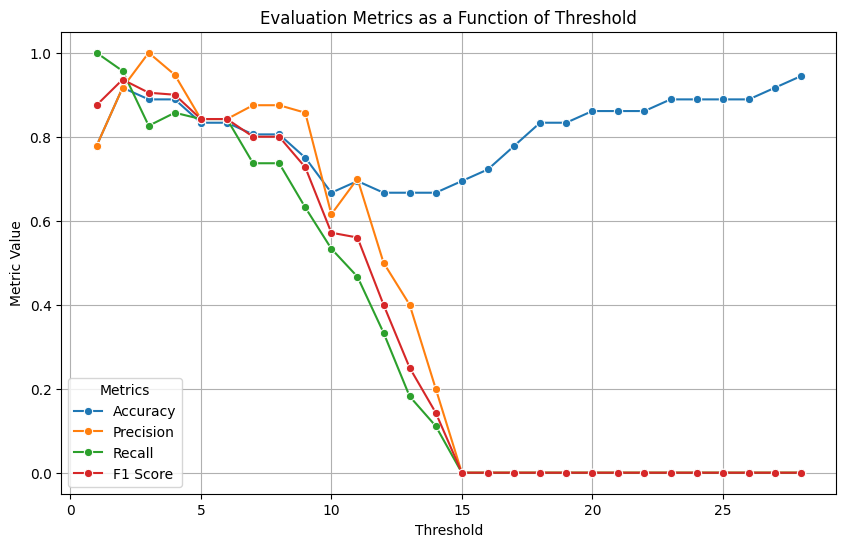

In [60]:
# Set the figure size for better visibility
plt.figure(figsize=(10, 6))

# Plot each metric as a function of threshold
sns.lineplot(data=results_df_logistic_lag, x='threshold', y='accuracy', label='Accuracy', marker='o')
sns.lineplot(data=results_df_logistic_lag, x='threshold', y='precision', label='Precision', marker='o')
sns.lineplot(data=results_df_logistic_lag, x='threshold', y='recall', label='Recall', marker='o')
sns.lineplot(data=results_df_logistic_lag, x='threshold', y='f1_score', label='F1 Score', marker='o')

# Adding titles and labels
plt.title('Evaluation Metrics as a Function of Threshold')
plt.xlabel('Threshold')
plt.ylabel('Metric Value')
plt.legend(title='Metrics')

# Show the plot
plt.grid(True)
plt.show()

## Visualization: Logistic regression model with time lag term after the tramsformation and the scaling

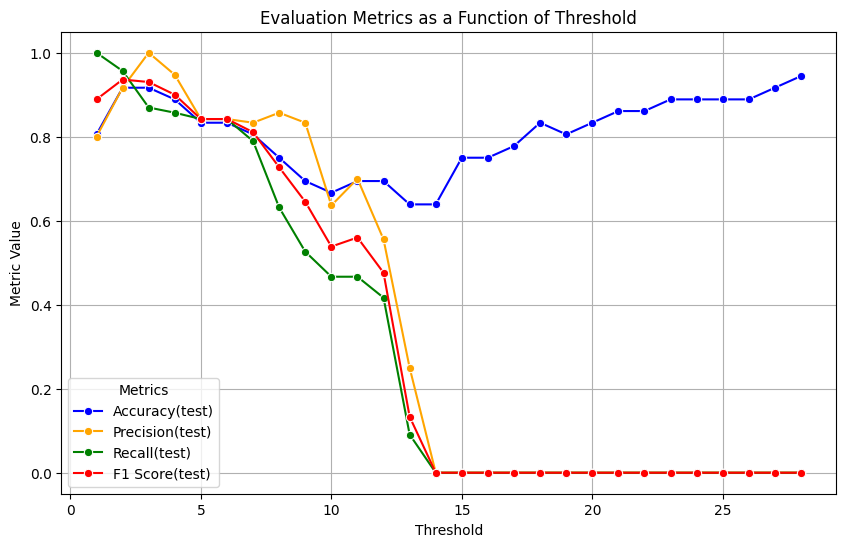

In [61]:
# Set the figure size for better visibility
plt.figure(figsize=(10, 6))

# Plot each metric as a function of threshold with specified colors
sns.lineplot(data=results_df_trans_logistic_lag, x='threshold', y='test_accuracy', label='Accuracy(test)', marker='o', color='blue')
#sns.lineplot(data=results_df_trans_logistic_lag, x='threshold', y='train_accuracy', label='Accuracy(train)', marker='s', color='blue')
sns.lineplot(data=results_df_trans_logistic_lag, x='threshold', y='test_precision', label='Precision(test)', marker='o', color='orange')
#sns.lineplot(data=results_df_trans_logistic_lag, x='threshold', y='train_precision', label='Precision(train)', marker='s', color='orange')
sns.lineplot(data=results_df_trans_logistic_lag, x='threshold', y='test_recall', label='Recall(test)', marker='o', color='green')
#sns.lineplot(data=results_df_trans_logistic_lag, x='threshold', y='train_recall', label='Recall(train)', marker='s', color='green')
sns.lineplot(data=results_df_trans_logistic_lag, x='threshold', y='test_f1_score', label='F1 Score(test)', marker='o', color='red')
#sns.lineplot(data=results_df_trans_logistic_lag, x='threshold', y='train_f1_score', label='F1 Score(train)', marker='s', color='red')

# Adding titles and labels
plt.title('Evaluation Metrics as a Function of Threshold')
plt.xlabel('Threshold')
plt.ylabel('Metric Value')
plt.legend(title='Metrics')

# Show the plot
plt.grid(True)
plt.show()

## Decision tree model

In [62]:
# Placeholder for the results of each threshold
results_tree = []

# Loop over each threshold value
for threshold in thresholds:
    # Create the binary column for red tide occurrence based on the threshold
    df_dt['red_tide_occurred'] = (df_dt['red_tide_days'] >= threshold).astype(int)
    
    # Split based on years
    train_df_dt = df_dt[df_dt["year"] <= train_end_year]
    val_df_dt = df_dt[(df_dt["year"] > train_end_year) & (df_dt["year"] <= val_end_year)]
    test_df_dt = df_dt[df_dt["year"] > val_end_year]

    # Split the data into features and target
    X_train = train_df_dt.drop(columns=['date', 'red_tide_days', 'red_tide_occurred', 'year'])
    y_train = train_df_dt['red_tide_occurred']
    X_val = val_df_dt.drop(columns=['date', 'red_tide_days', 'red_tide_occurred', 'year'])
    y_val = val_df_dt['red_tide_occurred']
    
    # Train a decision tree classifier
    tree_model = DecisionTreeClassifier(random_state=42)
    tree_model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = tree_model.predict(X_val)
    
    # Calculate evaluation metrics
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    
    # Store the results for the current threshold
    results_tree.append({
        'threshold': threshold,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    })

# Convert results into a DataFrame
results_df_tree = pd.DataFrame(results_tree)

# Display the results DataFrame
display(results_df_tree)


c:\Users\jsmeg\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\jsmeg\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\jsmeg\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

threshold  accuracy  precision    recall  f1_score
0           1  0.777778   0.857143  0.857143  0.857143
1           2  0.805556   0.807692  0.913043  0.857143
2           3  0.472222   0.625000  0.434783  0.512821
3           4  0.500000   0.600000  0.428571  0.500000
4           5  0.444444   0.466667  0.368421  0.411765
5           6  0.444444   0.466667  0.368421  0.411765
6           7  0.472222   0.500000  0.421053  0.457143
7           8  0.555556   0.636364  0.368421  0.466667
8           9  0.555556   0.714286  0.263158  0.384615
9          10  0.500000   0.333333  0.200000  0.250000
10         11  0.583333   0.500000  0.400000  0.444444
11         12  0.611111   0.416667  0.416667  0.416667
12         13  0.666667   0.428571  0.272727  0.333333
13         14  0.694444   0.375000  0.333333  0.352941
14         15  0.500000   0.083333  0.125000  0.100000
15         16  0.666667   0.333333  0.500000  0.400000
16         17  0.694444   0.300000  0.428571  0.352941
17         18  0.583333   0.083333  0.200000  0.117647
18         19  0.611111   0.000000  0.000000  0.000000
19         20  0.722222   0.142857  0.200000  0.166667
20         21  0.611111   0.000000  0.000000  0.000000
21         22  0.638889   0.000000  0.000000  0.000000
22         23  0.722222   0.000000  0.000000  0.000000
23         24  0.861111   0.000000  0.000000  0.000000
24         25  0.833333   0.000000  0.000000  0.000000
25         26  0.888889   0.000000  0.000000  0.000000
26         27  0.916667   0.000000  0.000000  0.000000
27         28  0.944444   0.000000  0.000000  0.000000

## Visualization: Decision tree model

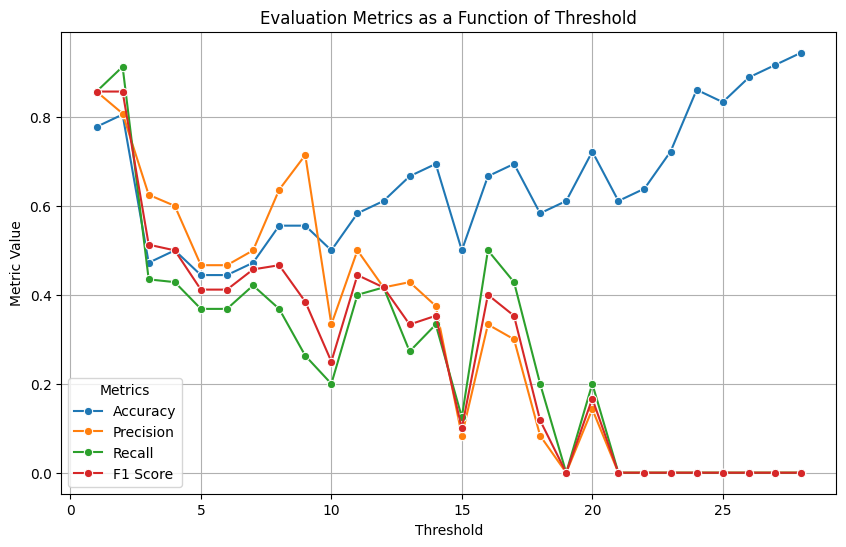

In [63]:
# Set the figure size for better visibility
plt.figure(figsize=(10, 6))

# Plot each metric as a function of threshold
sns.lineplot(data=results_df_tree, x='threshold', y='accuracy', label='Accuracy', marker='o')
sns.lineplot(data=results_df_tree, x='threshold', y='precision', label='Precision', marker='o')
sns.lineplot(data=results_df_tree, x='threshold', y='recall', label='Recall', marker='o')
sns.lineplot(data=results_df_tree, x='threshold', y='f1_score', label='F1 Score', marker='o')

# Adding titles and labels
plt.title('Evaluation Metrics as a Function of Threshold')
plt.xlabel('Threshold')
plt.ylabel('Metric Value')
plt.legend(title='Metrics')

# Show the plot
plt.grid(True)
plt.show()

## Decision tree model with time lag term

In [64]:
# Placeholder for the results of each threshold
results_tree_lag = []

# Loop over each threshold value
for threshold in thresholds:
    # Create the binary column for red tide occurrence based on the threshold
    df_dt_lag['red_tide_occurred'] = (df_dt_lag['red_tide_days'] >= threshold).astype(int)
    
    # Split based on years
    train_df_dt_lag = df_dt_lag[df_dt_lag["year"] <= train_end_year]
    val_df_dt_lag = df_dt_lag[(df_dt_lag["year"] > train_end_year) & (df_dt_lag["year"] <= val_end_year)]
    test_df_dt_lag = df_dt_lag[df_dt_lag["year"] > val_end_year]

    # Split the data into features and target
    X_train = train_df_dt_lag.drop(columns=['date', 'red_tide_days', 'red_tide_occurred', 'year'])
    y_train = train_df_dt_lag['red_tide_occurred']
    X_val = val_df_dt_lag.drop(columns=['date', 'red_tide_days', 'red_tide_occurred', 'year'])
    y_val = val_df_dt_lag['red_tide_occurred']
    
    # Train a decision tree classifier
    tree_model_lag = DecisionTreeClassifier(random_state=42)
    tree_model_lag.fit(X_train, y_train)
    
    # If threshold == 6, visualize the tree
    #if threshold == 6:
    #    plt.figure(figsize=(16, 10))
    #    plot_tree(
    #        tree_model_lag,
    #        feature_names=X_train.columns,
    #        class_names=['No Red Tide', 'Red Tide'],
    #        filled=True,
    #        rounded=True
    #    )
    #    plt.title(f"Decision Tree Visualization for Threshold = {threshold}")
    #    plt.show()

    # Make predictions
    y_pred = tree_model_lag.predict(X_val)
    
    # Calculate evaluation metrics
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    
    # Store the results for the current threshold
    results_tree_lag.append({
        'threshold': threshold,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    })

# Convert results into a DataFrame
results_df_tree_lag = pd.DataFrame(results_tree_lag)

# Display the results DataFrame
display(results_df_tree_lag)

threshold  accuracy  precision    recall  f1_score
0           1  0.722222   0.821429  0.821429  0.821429
1           2  0.722222   0.782609  0.782609  0.782609
2           3  0.444444   0.578947  0.478261  0.523810
3           4  0.527778   0.600000  0.571429  0.585366
4           5  0.500000   0.526316  0.526316  0.526316
5           6  0.500000   0.526316  0.526316  0.526316
6           7  0.611111   0.619048  0.684211  0.650000
7           8  0.583333   0.642857  0.473684  0.545455
8           9  0.500000   0.533333  0.421053  0.470588
9          10  0.527778   0.428571  0.400000  0.413793
10         11  0.555556   0.461538  0.400000  0.428571
11         12  0.638889   0.470588  0.666667  0.551724
12         13  0.750000   0.562500  0.818182  0.666667
13         14  0.722222   0.466667  0.777778  0.583333
14         15  0.638889   0.333333  0.625000  0.434783
15         16  0.638889   0.307692  0.500000  0.380952
16         17  0.666667   0.272727  0.428571  0.333333
17         18  0.555556   0.076923  0.200000  0.111111
18         19  0.638889   0.100000  0.200000  0.133333
19         20  0.722222   0.272727  0.600000  0.375000
20         21  0.666667   0.111111  0.200000  0.142857
21         22  0.583333   0.000000  0.000000  0.000000
22         23  0.722222   0.000000  0.000000  0.000000
23         24  0.722222   0.000000  0.000000  0.000000
24         25  0.833333   0.000000  0.000000  0.000000
25         26  0.833333   0.000000  0.000000  0.000000
26         27  0.888889   0.000000  0.000000  0.000000
27         28  0.916667   0.000000  0.000000  0.000000

## Visualization: Decision tree model with time lag term

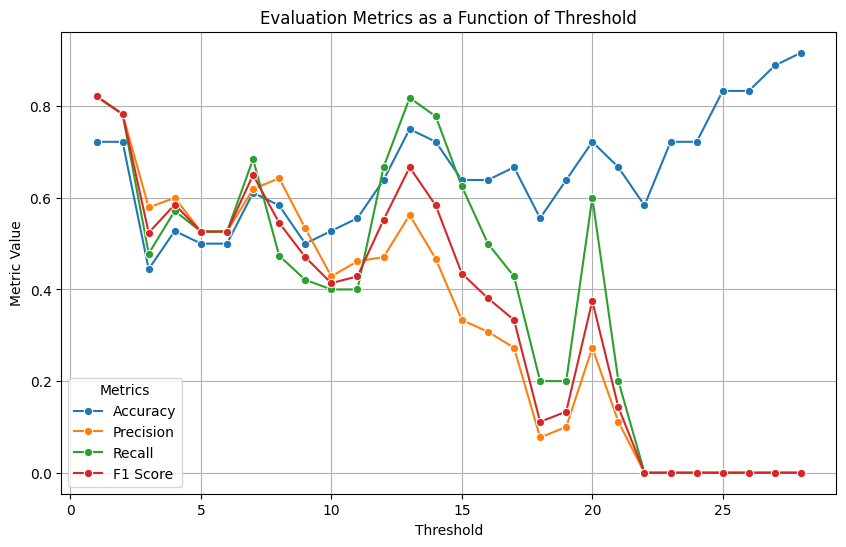

In [65]:
# Set the figure size for better visibility
plt.figure(figsize=(10, 6))

# Plot each metric as a function of threshold
sns.lineplot(data=results_df_tree_lag, x='threshold', y='accuracy', label='Accuracy', marker='o')
sns.lineplot(data=results_df_tree_lag, x='threshold', y='precision', label='Precision', marker='o')
sns.lineplot(data=results_df_tree_lag, x='threshold', y='recall', label='Recall', marker='o')
sns.lineplot(data=results_df_tree_lag, x='threshold', y='f1_score', label='F1 Score', marker='o')

# Adding titles and labels
plt.title('Evaluation Metrics as a Function of Threshold')
plt.xlabel('Threshold')
plt.ylabel('Metric Value')
plt.legend(title='Metrics')

# Show the plot
plt.grid(True)
plt.show()

## Random forest model

In [66]:
# Placeholder for the results of each threshold
results_rf = []

# Loop over each threshold value
for threshold in thresholds:
    # Create the binary column for red tide occurrence based on the threshold
    df_rf['red_tide_occurred'] = (df_rf['red_tide_days'] >= threshold).astype(int)
    
    # Split based on years
    train_df_rf = df_rf[df_rf["year"] <= train_end_year]
    val_df_rf = df_rf[(df_rf["year"] > train_end_year) & (df_rf["year"] <= val_end_year)]
    test_df_rf = df_rf[df_rf["year"] > val_end_year]

    # Split the data into features and target
    X_train = train_df_rf.drop(columns=['date', 'red_tide_days', 'red_tide_occurred', 'year'])
    y_train = train_df_rf['red_tide_occurred']
    X_val = val_df_rf.drop(columns=['date', 'red_tide_days', 'red_tide_occurred', 'year'])
    y_val = val_df_rf['red_tide_occurred']
    
    # Train a decision tree classifier
    rf_model = RandomForestClassifier(random_state=42)
    rf_model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = rf_model.predict(X_val)
    
    # Calculate evaluation metrics
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    
    # Store the results for the current threshold
    results_rf.append({
        'threshold': threshold,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    })

# Convert results into a DataFrame
results_df_rf = pd.DataFrame(results_rf)

# Display the results DataFrame
display(results_df_rf)

c:\Users\jsmeg\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\jsmeg\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\jsmeg\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

threshold  accuracy  precision    recall  f1_score
0           1  0.750000   0.806452  0.892857  0.847458
1           2  0.750000   0.750000  0.913043  0.823529
2           3  0.638889   0.750000  0.652174  0.697674
3           4  0.694444   0.750000  0.714286  0.731707
4           5  0.666667   0.684211  0.684211  0.684211
5           6  0.666667   0.684211  0.684211  0.684211
6           7  0.638889   0.666667  0.631579  0.648649
7           8  0.666667   0.769231  0.526316  0.625000
8           9  0.611111   0.777778  0.368421  0.500000
9          10  0.666667   0.615385  0.533333  0.571429
10         11  0.694444   0.700000  0.466667  0.560000
11         12  0.750000   0.666667  0.500000  0.571429
12         13  0.722222   0.600000  0.272727  0.375000
13         14  0.722222   0.400000  0.222222  0.285714
14         15  0.694444   0.200000  0.125000  0.153846
15         16  0.722222   0.250000  0.125000  0.166667
16         17  0.750000   0.250000  0.142857  0.181818
17         18  0.777778   0.000000  0.000000  0.000000
18         19  0.722222   0.000000  0.000000  0.000000
19         20  0.833333   0.000000  0.000000  0.000000
20         21  0.861111   0.000000  0.000000  0.000000
21         22  0.861111   0.000000  0.000000  0.000000
22         23  0.861111   0.000000  0.000000  0.000000
23         24  0.888889   0.000000  0.000000  0.000000
24         25  0.888889   0.000000  0.000000  0.000000
25         26  0.888889   0.000000  0.000000  0.000000
26         27  0.916667   0.000000  0.000000  0.000000
27         28  0.944444   0.000000  0.000000  0.000000

## Visualization: Random forest model

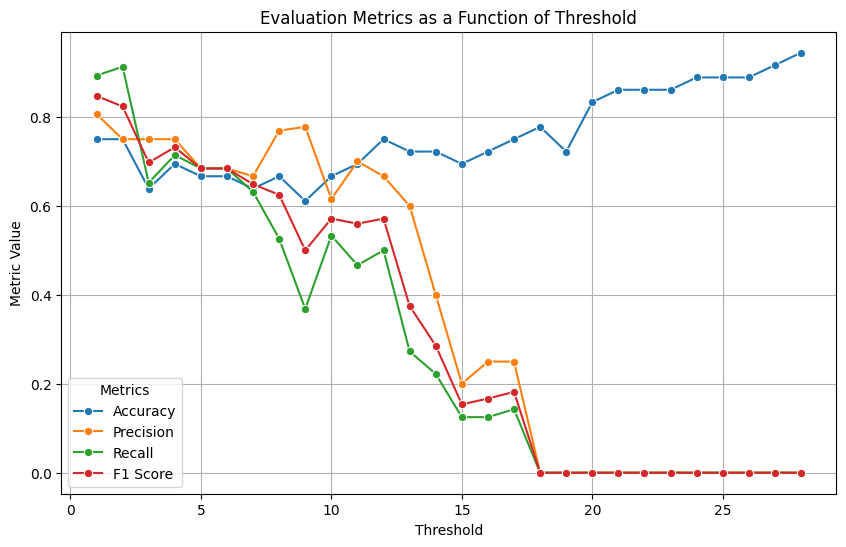

In [67]:
# Set the figure size for better visibility
plt.figure(figsize=(10, 6))

# Plot each metric as a function of threshold
sns.lineplot(data=results_df_rf, x='threshold', y='accuracy', label='Accuracy', marker='o')
sns.lineplot(data=results_df_rf, x='threshold', y='precision', label='Precision', marker='o')
sns.lineplot(data=results_df_rf, x='threshold', y='recall', label='Recall', marker='o')
sns.lineplot(data=results_df_rf, x='threshold', y='f1_score', label='F1 Score', marker='o')

# Adding titles and labels
plt.title('Evaluation Metrics as a Function of Threshold')
plt.xlabel('Threshold')
plt.ylabel('Metric Value')
plt.legend(title='Metrics')

# Show the plot
plt.grid(True)
plt.show()

## Random forest model with time lag term

In [68]:
# Placeholder for the results of each threshold
results_rf_lag = []

# Loop over each threshold value
for threshold in thresholds:
    # Create the binary column for red tide occurrence based on the threshold
    df_rf_lag['red_tide_occurred'] = (df_rf_lag['red_tide_days'] >= threshold).astype(int)
    
    # Split based on years
    train_df_rf_lag = df_rf_lag[df_rf_lag["year"] <= train_end_year]
    val_df_rf_lag = df_rf_lag[(df_rf_lag["year"] > train_end_year) & (df_rf_lag["year"] <= val_end_year)]
    test_df_rf_lag = df_rf_lag[df_rf_lag["year"] > val_end_year]

    # Split the data into features and target
    X_train = train_df_rf_lag.drop(columns=['date', 'red_tide_days', 'red_tide_occurred', 'year'])
    y_train = train_df_rf_lag['red_tide_occurred']
    X_val = val_df_rf_lag.drop(columns=['date', 'red_tide_days', 'red_tide_occurred', 'year'])
    y_val = val_df_rf_lag['red_tide_occurred']
    
    # Train a decision tree classifier
    rf_model_lag = RandomForestClassifier(random_state=42)
    rf_model_lag.fit(X_train, y_train)
    
    # Make predictions
    y_pred = rf_model_lag.predict(X_val)
    
    if threshold == 23:
        # Compute confusion matrix
        tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()

        # Display the table
        conf_matrix_df = pd.DataFrame(
            [[tn, fp], [fn, tp]],
            columns=['Predicted Negative', 'Predicted Positive'],
            index=['Actual Negative', 'Actual Positive']
        )

        display(conf_matrix_df)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    
    # Store the results for the current threshold
    results_rf_lag.append({
        'threshold': threshold,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    })

# Convert results into a DataFrame
results_df_rf_lag = pd.DataFrame(results_rf_lag)

# Display the results DataFrame
display(results_df_rf_lag)

Predicted Negative  Predicted Positive
Actual Negative                  32                   0
Actual Positive                   3                   1

c:\Users\jsmeg\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\jsmeg\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\jsmeg\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

threshold  accuracy  precision    recall  f1_score
0           1  0.777778   0.833333  0.892857  0.862069
1           2  0.888889   0.913043  0.913043  0.913043
2           3  0.888889   1.000000  0.826087  0.904762
3           4  0.888889   0.947368  0.857143  0.900000
4           5  0.805556   0.833333  0.789474  0.810811
5           6  0.805556   0.833333  0.789474  0.810811
6           7  0.805556   0.833333  0.789474  0.810811
7           8  0.777778   0.866667  0.684211  0.764706
8           9  0.694444   0.833333  0.526316  0.645161
9          10  0.722222   0.692308  0.600000  0.642857
10         11  0.777778   0.769231  0.666667  0.714286
11         12  0.805556   0.692308  0.750000  0.720000
12         13  0.777778   0.666667  0.545455  0.600000
13         14  0.722222   0.428571  0.333333  0.375000
14         15  0.694444   0.285714  0.250000  0.266667
15         16  0.694444   0.285714  0.250000  0.266667
16         17  0.722222   0.285714  0.285714  0.285714
17         18  0.750000   0.000000  0.000000  0.000000
18         19  0.777778   0.000000  0.000000  0.000000
19         20  0.833333   0.333333  0.200000  0.250000
20         21  0.861111   0.500000  0.200000  0.285714
21         22  0.833333   0.000000  0.000000  0.000000
22         23  0.916667   1.000000  0.250000  0.400000
23         24  0.888889   0.000000  0.000000  0.000000
24         25  0.888889   0.000000  0.000000  0.000000
25         26  0.888889   0.000000  0.000000  0.000000
26         27  0.944444   1.000000  0.333333  0.500000
27         28  0.972222   1.000000  0.500000  0.666667

## Visualization: Random forest model with time lag term

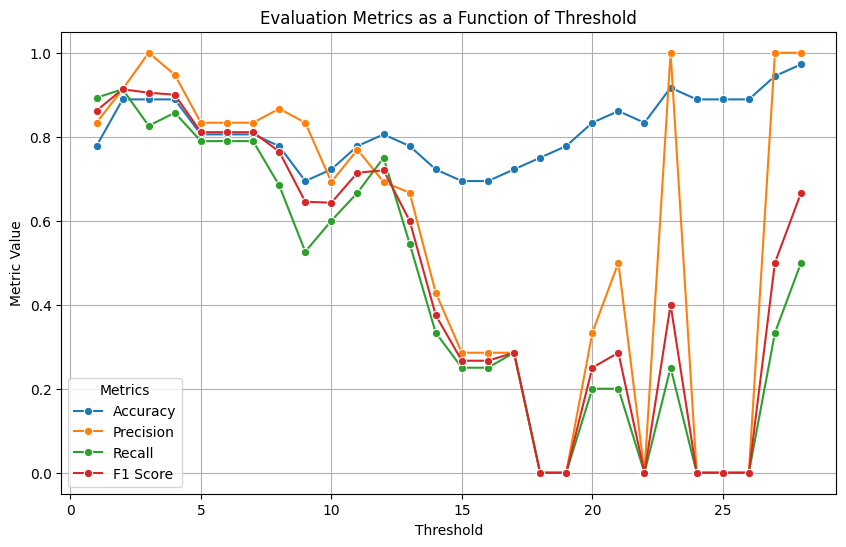

In [69]:
# Set the figure size for better visibility
plt.figure(figsize=(10, 6))

# Plot each metric as a function of threshold
sns.lineplot(data=results_df_rf_lag, x='threshold', y='accuracy', label='Accuracy', marker='o')
sns.lineplot(data=results_df_rf_lag, x='threshold', y='precision', label='Precision', marker='o')
sns.lineplot(data=results_df_rf_lag, x='threshold', y='recall', label='Recall', marker='o')
sns.lineplot(data=results_df_rf_lag, x='threshold', y='f1_score', label='F1 Score', marker='o')

# Adding titles and labels
plt.title('Evaluation Metrics as a Function of Threshold')
plt.xlabel('Threshold')
plt.ylabel('Metric Value')
plt.legend(title='Metrics')

# Show the plot
plt.grid(True)
plt.show()

# Tuning hyperparameters

## Logistic regression model

In [70]:
# Define hyperparameter grid
param_grid_logistic = {
    "C": [0.01, 0.1, 1, 10, 100],  # Regularization strength
    "solver": ["liblinear", "lbfgs"]  # Different solvers
}

# Number of splits for rolling window cross-validation
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

best_params_all = []
results_trans_logistic_lag_opt = []
feature_contributions_all = []

opt_thresholds = [1, 2, 3]

for threshold in opt_thresholds:
    # Create binary target variable
    df_trans_logistic_lag['red_tide_occurred'] = (df_trans_logistic_lag['red_tide_days'] >= threshold).astype(int)
    
    # Training & Validation Set Split
    train_df_trans_logistic_lag = df_trans_logistic_lag[df_trans_logistic_lag["year"] <= train_end_year]
    val_df_trans_logistic_lag = df_trans_logistic_lag[(df_trans_logistic_lag["year"] > train_end_year) & (df_trans_logistic_lag["year"] <= val_end_year)]

    X_train = train_df_trans_logistic_lag.drop(columns=['date', 'red_tide_days', 'red_tide_occurred', 'year'])
    y_train = train_df_trans_logistic_lag['red_tide_occurred']
    X_val = val_df_trans_logistic_lag.drop(columns=['date', 'red_tide_days', 'red_tide_occurred', 'year'])
    y_val = val_df_trans_logistic_lag['red_tide_occurred']

    # Convert to NumPy for efficiency
    X_train_np = X_train.to_numpy()
    y_train_np = y_train.to_numpy()

    best_score = -np.inf
    best_params = None

    # Step 1: Hyperparameter Tuning using Rolling Window CV
    for C in param_grid_logistic["C"]:
        for solver in param_grid_logistic["solver"]:
            scores = []

            for train_index, val_index in tscv.split(X_train_np):
                X_train_cv, X_val_cv = X_train_np[train_index], X_train_np[val_index]
                y_train_cv, y_val_cv = y_train_np[train_index], y_train_np[val_index]

                # Extract years and months from the date column for the training and validation indices
                train_dates = train_df_trans_logistic_lag.iloc[train_index]['date']
                val_dates = train_df_trans_logistic_lag.iloc[val_index]['date']

                train_start_date = train_dates.min()
                train_end_date = train_dates.max()
                val_start_date = val_dates.min()
                val_end_date = val_dates.max()

                # Print the start and end dates, as well as the number of data points
                #print(f"Training set from {train_start_date} to {train_end_date} with {len(train_dates)} data points")
                #print(f"Validation set from {val_start_date} to {val_end_date} with {len(val_dates)} data points")

                # Train logistic regression with current hyperparameters
                model = LogisticRegression(C=C, solver=solver, max_iter=1000)
                model.fit(X_train_cv, y_train_cv)

                # Validate on validation fold
                y_pred_val_cv = model.predict(X_val_cv)
                #val_precision = precision_score(y_val_cv, y_pred_val_cv, zero_division=0)
                #val_f1 = f1_score(y_val_cv, y_pred_val_cv, zero_division=0)
                val_accuracy = accuracy_score(y_val_cv, y_pred_val_cv)
                scores.append(val_accuracy)

            # Average score across folds
            avg_score = np.mean(scores)

            # Keep track of the best hyperparameters
            if avg_score > best_score:
                best_score = avg_score
                best_params = {"C": C, "solver": solver}

    best_params_all.append({"threshold": threshold, **best_params})

    # Step 2: Train Final Model on Full Training Set with Best Params
    final_model = LogisticRegression(C=best_params["C"], solver=best_params["solver"], max_iter=1000)
    final_model.fit(X_train, y_train)

    # Step 3: Evaluate on Validation Set
    y_pred_train = final_model.predict(X_train)
    y_pred_val = final_model.predict(X_val)

    # Compute Evaluation Metrics
    train_accuracy = accuracy_score(y_train, y_pred_train)
    train_precision = precision_score(y_train, y_pred_train, zero_division=0)
    train_recall = recall_score(y_train, y_pred_train, zero_division=0)
    train_f1 = f1_score(y_train, y_pred_train, zero_division=0)

    val_accuracy = accuracy_score(y_val, y_pred_val)
    val_precision = precision_score(y_val, y_pred_val, zero_division=0)
    val_recall = recall_score(y_val, y_pred_val, zero_division=0)
    val_f1 = f1_score(y_val, y_pred_val, zero_division=0)

    # Retrieve feature contributions
    feature_names = X_train.columns
    coefficients = final_model.coef_[0]
    intercept = final_model.intercept_[0]

    # Summarize feature contributions
    feature_summary = pd.DataFrame({
        'threshold': threshold,
        'Feature': feature_names,
        'Coefficient': coefficients,
        'Absolute Importance': abs(coefficients)
    }).sort_values(by='Absolute Importance', ascending=False)

    # Store results
    results_trans_logistic_lag_opt.append({
        'threshold': threshold,
        'best_C': best_params["C"],
        'best_solver': best_params["solver"],
        'train_accuracy': train_accuracy,
        'train_precision': train_precision,
        'train_recall': train_recall,
        'train_f1_score': train_f1,
        'val_accuracy': val_accuracy,
        'val_precision': val_precision,
        'val_recall': val_recall,
        'val_f1_score': val_f1,
        'intercept': intercept
    })

    # Add feature contributions
    feature_contributions_all.append(feature_summary)

# Convert results to DataFrame
results_df_trans_logistic_lag_opt = pd.DataFrame(results_trans_logistic_lag_opt)
feature_contributions_df = pd.concat(feature_contributions_all, ignore_index=True)

# Print best hyperparameters for each threshold
display(best_params_all)

# Print final evaluation metrics
display(results_df_trans_logistic_lag_opt)


[{'threshold': 1, 'C': 1, 'solver': 'liblinear'},
 {'threshold': 2, 'C': 0.1, 'solver': 'lbfgs'},
 {'threshold': 3, 'C': 0.01, 'solver': 'liblinear'}]

threshold  best_C best_solver  train_accuracy  train_precision  \
0          1    1.00   liblinear        0.865385         0.892857   
1          2    0.10       lbfgs        0.775641         0.803030   
2          3    0.01   liblinear        0.769231         0.833333   

   train_recall  train_f1_score  val_accuracy  val_precision  val_recall  \
0      0.954198        0.922509      0.777778       0.794118    0.964286   
1      0.921739        0.858300      0.888889       0.880000    0.956522   
2      0.800000        0.816327      0.805556       1.000000    0.695652   

   val_f1_score  intercept  
0      0.870968   2.330126  
1      0.916667   1.263243  
2      0.820513   0.147097

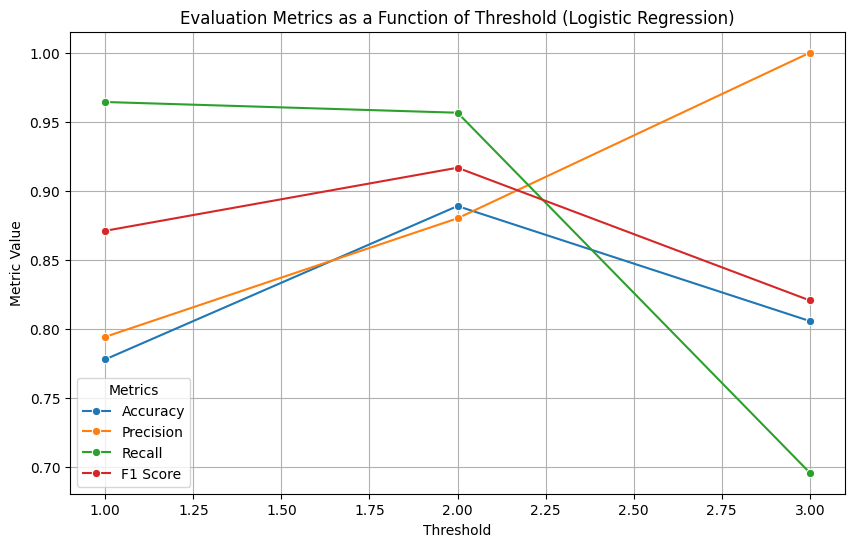

In [71]:
# Set the figure size for better visibility
plt.figure(figsize=(10, 6))

# Plot each metric as a function of threshold
sns.lineplot(data=results_df_trans_logistic_lag_opt, x='threshold', y='val_accuracy', label='Accuracy', marker='o')
sns.lineplot(data=results_df_trans_logistic_lag_opt, x='threshold', y='val_precision', label='Precision', marker='o')
sns.lineplot(data=results_df_trans_logistic_lag_opt, x='threshold', y='val_recall', label='Recall', marker='o')
sns.lineplot(data=results_df_trans_logistic_lag_opt, x='threshold', y='val_f1_score', label='F1 Score', marker='o')

# Adding titles and labels
plt.title('Evaluation Metrics as a Function of Threshold (Logistic Regression)')
plt.xlabel('Threshold')
plt.ylabel('Metric Value')
plt.legend(title='Metrics')

# Show the plot
plt.grid(True)
plt.show()


## Decision tree model

In [72]:
# Placeholder for results
results_tree_opt = []

# Define hyperparameter grid for tuning
param_grid_dt = {
    "max_depth": [3, 5, 10, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 5]
}

# Define rolling window cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Loop over each threshold
for threshold in opt_thresholds:
    df_dt['red_tide_occurred'] = (df_dt['red_tide_days'] >= threshold).astype(int)

    # Split data into train, validation, and test
    train_df_dt = df_dt[df_dt["year"] <= train_end_year]
    val_df_dt = df_dt[(df_dt["year"] > train_end_year) & (df_dt["year"] <= val_end_year)]

    X_train = train_df_dt.drop(columns=['date', 'red_tide_days', 'red_tide_occurred', 'year'])
    y_train = train_df_dt['red_tide_occurred']
    X_val = val_df_dt.drop(columns=['date', 'red_tide_days', 'red_tide_occurred', 'year'])
    y_val = val_df_dt['red_tide_occurred']

    # Perform rolling window cross-validation for hyperparameter tuning
    tree_model = DecisionTreeClassifier(random_state=42)
    grid_search = GridSearchCV(tree_model, param_grid_dt, cv=tscv, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # Get best model from tuning
    best_tree = grid_search.best_estimator_

    # Train best model on full training set
    best_tree.fit(X_train, y_train)

    # Predict on validation set
    y_pred_train = best_tree.predict(X_train)
    y_pred_val = best_tree.predict(X_val)

    # Calculate evaluation metrics
    train_accuracy = accuracy_score(y_train, y_pred_train)
    train_precision = precision_score(y_train, y_pred_train)
    train_recall = recall_score(y_train, y_pred_train)
    train_f1 = f1_score(y_train, y_pred_train)
    val_accuracy = accuracy_score(y_val, y_pred_val)
    val_precision = precision_score(y_val, y_pred_val)
    val_recall = recall_score(y_val, y_pred_val)
    val_f1 = f1_score(y_val, y_pred_val)

    # Store results
    results_tree_opt.append({
        'threshold': threshold,
        'train_accuracy': train_accuracy,
        'train_precision': train_precision,
        'train_recall': train_recall,
        'train_f1_score': train_f1,
        'val_accuracy': val_accuracy,
        'val_precision': val_precision,
        'val_recall': val_recall,
        'val_f1_score': val_f1,
        'best_params': grid_search.best_params_
    })

# Convert results to DataFrame
results_df_tree_opt = pd.DataFrame(results_tree_opt)

# Display results
display(results_df_tree_opt)


threshold  train_accuracy  train_precision  train_recall  train_f1_score  \
0          1        0.940476         0.978102      0.950355        0.964029   
1          2        0.892857         0.933333      0.918033        0.925620   
2          3        0.833333         0.853211      0.885714        0.869159   

   val_accuracy  val_precision  val_recall  val_f1_score  \
0      0.722222       0.846154    0.785714      0.814815   
1      0.500000       0.647059    0.478261      0.550000   
2      0.777778       0.857143    0.782609      0.818182   

                                         best_params  
0  {'max_depth': 5, 'min_samples_leaf': 1, 'min_s...  
1  {'max_depth': 10, 'min_samples_leaf': 5, 'min_...  
2  {'max_depth': 3, 'min_samples_leaf': 1, 'min_s...

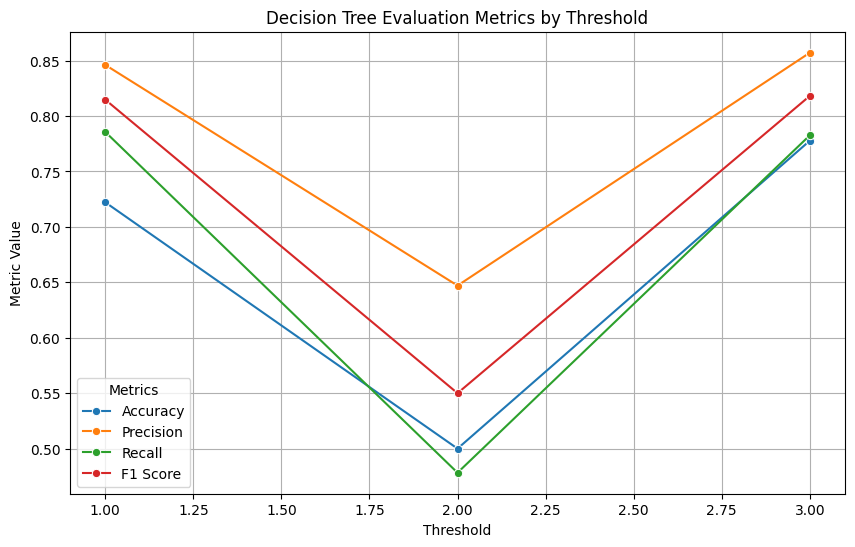

In [73]:
# --- Graphing the Results ---
plt.figure(figsize=(10, 6))

sns.lineplot(data=results_df_tree_opt, x='threshold', y='val_accuracy', label='Accuracy', marker='o')
sns.lineplot(data=results_df_tree_opt, x='threshold', y='val_precision', label='Precision', marker='o')
sns.lineplot(data=results_df_tree_opt, x='threshold', y='val_recall', label='Recall', marker='o')
sns.lineplot(data=results_df_tree_opt, x='threshold', y='val_f1_score', label='F1 Score', marker='o')

plt.title('Decision Tree Evaluation Metrics by Threshold')
plt.xlabel('Threshold')
plt.ylabel('Metric Value')
plt.legend(title='Metrics')
plt.grid(True)
plt.show()

## Decision tree model with time lag term

In [74]:
# Placeholder for the results
results_tree_lag_opt = []

# Define hyperparameter grid for tuning
param_grid = {
    "max_depth": [3, 5, 10, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 5]
}

# Define rolling window cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Loop over each threshold value
for threshold in opt_thresholds:
    df_dt_lag['red_tide_occurred'] = (df_dt_lag['red_tide_days'] >= threshold).astype(int)
    
    # Split data into train, validation, and test
    train_df_dt_lag = df_dt_lag[df_dt_lag["year"] <= train_end_year]
    val_df_dt_lag = df_dt_lag[(df_dt_lag["year"] > train_end_year) & (df_dt_lag["year"] <= val_end_year)]

    X_train = train_df_dt_lag.drop(columns=['date', 'red_tide_days', 'red_tide_occurred', 'year'])
    y_train = train_df_dt_lag['red_tide_occurred']
    X_val = val_df_dt_lag.drop(columns=['date', 'red_tide_days', 'red_tide_occurred', 'year'])
    y_val = val_df_dt_lag['red_tide_occurred']

    # Perform rolling window cross-validation for hyperparameter tuning
    tree_model_lag = DecisionTreeClassifier(random_state=42)
    grid_search = GridSearchCV(tree_model_lag, param_grid, cv=tscv, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # Get best model from tuning
    best_tree_lag = grid_search.best_estimator_

    # Train best model on full training set
    best_tree_lag.fit(X_train, y_train)

    # Make predictions on validation set
    y_pred_train = best_tree_lag.predict(X_train)
    y_pred_val = best_tree_lag.predict(X_val)

    # Calculate evaluation metrics
    train_accuracy = accuracy_score(y_train, y_pred_train)
    train_precision = precision_score(y_train, y_pred_train)
    train_recall = recall_score(y_train, y_pred_train)
    train_f1 = f1_score(y_train, y_pred_train)
    val_accuracy = accuracy_score(y_val, y_pred_val)
    val_precision = precision_score(y_val, y_pred_val)
    val_recall = recall_score(y_val, y_pred_val)
    val_f1 = f1_score(y_val, y_pred_val)

    # Store the results for the current threshold
    results_tree_lag_opt.append({
        'threshold': threshold,
        'train_accuracy': train_accuracy,
        'train_precision': train_precision,
        'train_recall': train_recall,
        'train_f1_score': train_f1,
        'val_accuracy': val_accuracy,
        'val_precision': val_precision,
        'val_recall': val_recall,
        'val_f1_score': val_f1,
        'best_params': grid_search.best_params_
    })

# Convert results to DataFrame
results_df_tree_lag_opt = pd.DataFrame(results_tree_lag_opt)

# Display the results DataFrame
display(results_df_tree_lag_opt)


threshold  train_accuracy  train_precision  train_recall  train_f1_score  \
0          1        1.000000         1.000000      1.000000        1.000000   
1          2        0.852564         0.950980      0.843478        0.894009   
2          3        0.897436         0.928571      0.910000        0.919192   

   val_accuracy  val_precision  val_recall  val_f1_score  \
0      0.722222       0.821429    0.821429      0.821429   
1      0.666667       0.823529    0.608696      0.700000   
2      0.583333       0.785714    0.478261      0.594595   

                                         best_params  
0  {'max_depth': None, 'min_samples_leaf': 1, 'mi...  
1  {'max_depth': 3, 'min_samples_leaf': 5, 'min_s...  
2  {'max_depth': 10, 'min_samples_leaf': 1, 'min_...

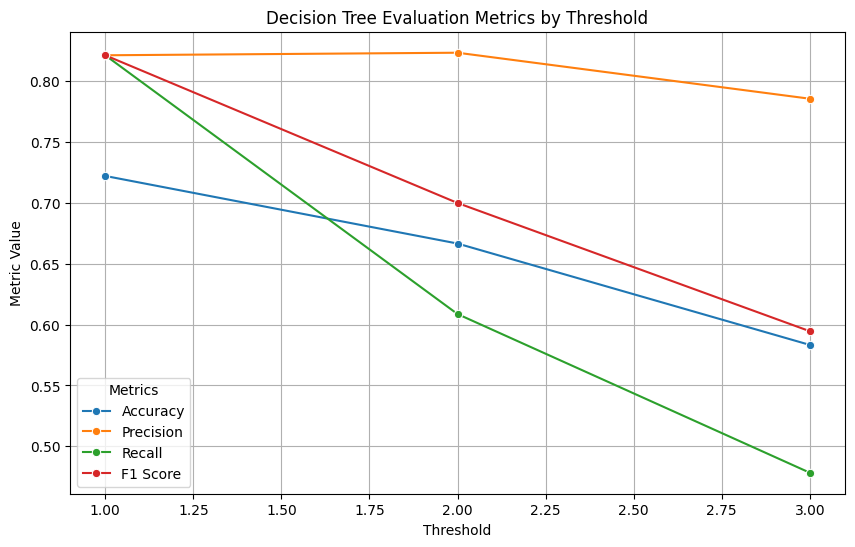

In [75]:
# --- Graphing the Results ---
plt.figure(figsize=(10, 6))

sns.lineplot(data=results_df_tree_lag_opt, x='threshold', y='val_accuracy', label='Accuracy', marker='o')
sns.lineplot(data=results_df_tree_lag_opt, x='threshold', y='val_precision', label='Precision', marker='o')
sns.lineplot(data=results_df_tree_lag_opt, x='threshold', y='val_recall', label='Recall', marker='o')
sns.lineplot(data=results_df_tree_lag_opt, x='threshold', y='val_f1_score', label='F1 Score', marker='o')

plt.title('Decision Tree Evaluation Metrics by Threshold')
plt.xlabel('Threshold')
plt.ylabel('Metric Value')
plt.legend(title='Metrics')
plt.grid(True)
plt.show()

## Random forest model

In [76]:
# Placeholder for the results
results_rf_lag_opt = []

# Hyperparameter grid
param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [3, 5, 10, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 5],
}

# Define rolling window cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Loop over each threshold value
for threshold in opt_thresholds:
    df_rf_lag['red_tide_occurred'] = (df_rf_lag['red_tide_days'] >= threshold).astype(int)
    
    # Split data into train, validation, and test
    train_df_rf_lag = df_rf_lag[df_rf_lag["year"] <= train_end_year]
    val_df_rf_lag = df_rf_lag[(df_rf_lag["year"] > train_end_year) & (df_rf_lag["year"] <= val_end_year)]

    X_train = train_df_rf_lag.drop(columns=['date', 'red_tide_days', 'red_tide_occurred', 'year'])
    y_train = train_df_rf_lag['red_tide_occurred']
    X_val = val_df_rf_lag.drop(columns=['date', 'red_tide_days', 'red_tide_occurred', 'year'])
    y_val = val_df_rf_lag['red_tide_occurred']

    # Perform rolling window cross-validation for hyperparameter tuning
    rf_model_lag = RandomForestClassifier(random_state=42)
    grid_search = GridSearchCV(rf_model_lag, param_grid, cv=tscv, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # Get best model from tuning
    best_rf_lag = grid_search.best_estimator_

    # Train best model on full training set
    best_rf_lag.fit(X_train, y_train)

    # Make predictions on validation set
    y_pred_train = best_rf_lag.predict(X_train)
    y_pred_val = best_rf_lag.predict(X_val)

    # Calculate evaluation metrics
    train_accuracy = accuracy_score(y_train, y_pred_train)
    train_precision = precision_score(y_train, y_pred_train)
    train_recall = recall_score(y_train, y_pred_train)
    train_f1 = f1_score(y_train, y_pred_train)
    val_accuracy = accuracy_score(y_val, y_pred_val)
    val_precision = precision_score(y_val, y_pred_val)
    val_recall = recall_score(y_val, y_pred_val)
    val_f1 = f1_score(y_val, y_pred_val)

    # Store the results for the current threshold
    results_rf_lag_opt.append({
        'threshold': threshold,
        'train_accuracy': train_accuracy,
        'train_precision': train_precision,
        'train_recall': train_recall,
        'train_f1_score': train_f1,
        'val_accuracy': val_accuracy,
        'val_precision': val_precision,
        'val_recall': val_recall,
        'val_f1_score': val_f1,
        'best_params': grid_search.best_params_
    })

# Convert results to DataFrame
results_df_rf_lag_opt = pd.DataFrame(results_rf_lag_opt)

# Display the results DataFrame
display(results_df_rf_lag_opt)

threshold  train_accuracy  train_precision  train_recall  train_f1_score  \
0          1        0.916667         0.927536      0.977099        0.951673   
1          2        0.871795         0.892562      0.939130        0.915254   
2          3        0.916667         0.930693      0.940000        0.935323   

   val_accuracy  val_precision  val_recall  val_f1_score  \
0      0.694444       0.757576    0.892857      0.819672   
1      0.861111       0.875000    0.913043      0.893617   
2      0.888889       1.000000    0.826087      0.904762   

                                         best_params  
0  {'max_depth': 3, 'min_samples_leaf': 1, 'min_s...  
1  {'max_depth': 3, 'min_samples_leaf': 1, 'min_s...  
2  {'max_depth': 5, 'min_samples_leaf': 1, 'min_s...

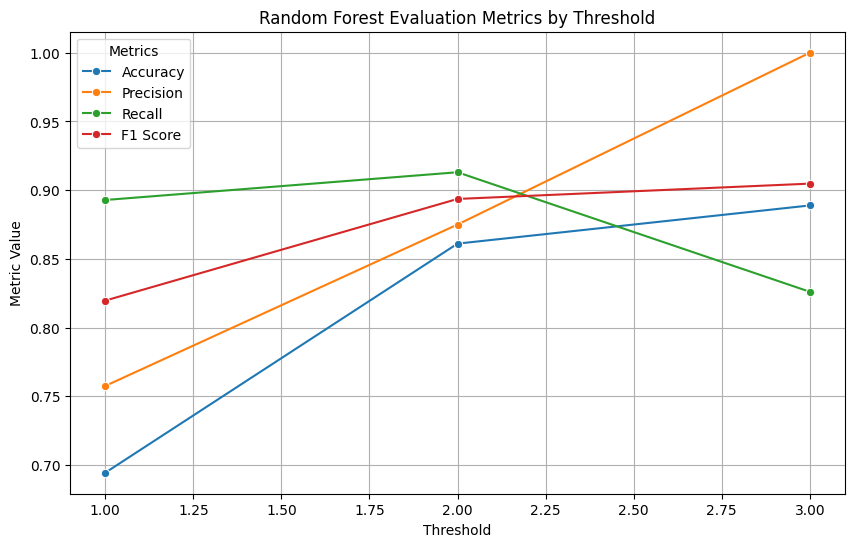

In [77]:
# --- Graphing the Results ---
plt.figure(figsize=(10, 6))

sns.lineplot(data=results_df_rf_lag_opt, x='threshold', y='val_accuracy', label='Accuracy', marker='o')
sns.lineplot(data=results_df_rf_lag_opt, x='threshold', y='val_precision', label='Precision', marker='o')
sns.lineplot(data=results_df_rf_lag_opt, x='threshold', y='val_recall', label='Recall', marker='o')
sns.lineplot(data=results_df_rf_lag_opt, x='threshold', y='val_f1_score', label='F1 Score', marker='o')

plt.title('Random Forest Evaluation Metrics by Threshold')
plt.xlabel('Threshold')
plt.ylabel('Metric Value')
plt.legend(title='Metrics')
plt.grid(True)
plt.show()

# Merge the test results

In [78]:
# Placeholder for the final evaluation results at different thresholds
final_results_thresholds = []

# Loop through each threshold (1, 2, 3)
for threshold in [1, 2, 3]:
    # Create the binary column for red tide occurrence based on the threshold
    df_trans_logistic_lag['red_tide_occurred'] = (df_trans_logistic_lag['red_tide_days'] >= threshold).astype(int)
    df_dt['red_tide_occurred'] = (df_dt['red_tide_days'] >= threshold).astype(int)
    df_dt_lag['red_tide_occurred'] = (df_dt_lag['red_tide_days'] >= threshold).astype(int)
    df_rf_lag['red_tide_occurred'] = (df_rf_lag['red_tide_days'] >= threshold).astype(int)

    # Split the data into training, validation, and test datasets
    train_df_logistic = df_trans_logistic_lag[df_trans_logistic_lag["year"] <= train_end_year]
    val_df_logistic = df_trans_logistic_lag[(df_trans_logistic_lag["year"] > train_end_year) & (df_trans_logistic_lag["year"] <= val_end_year)]
    test_df_logistic = df_trans_logistic_lag[df_trans_logistic_lag["year"] > val_end_year]
    
    train_df_dt = df_dt[df_dt["year"] <= train_end_year]
    val_df_dt = df_dt[(df_dt["year"] > train_end_year) & (df_dt["year"] <= val_end_year)]
    test_df_dt = df_dt[df_dt["year"] > val_end_year]

    train_df_rf_lag = df_rf_lag[df_rf_lag["year"] <= train_end_year]
    val_df_rf_lag = df_rf_lag[(df_rf_lag["year"] > train_end_year) & (df_rf_lag["year"] <= val_end_year)]
    test_df_rf_lag = df_rf_lag[df_rf_lag["year"] > val_end_year]
    
    X_train_logistic = train_df_logistic.drop(columns=['date', 'red_tide_days', 'red_tide_occurred', 'year'])
    y_train_logistic = train_df_logistic['red_tide_occurred']
    X_val_logistic = val_df_logistic.drop(columns=['date', 'red_tide_days', 'red_tide_occurred', 'year'])
    y_val_logistic = val_df_logistic['red_tide_occurred']
    X_test_logistic = test_df_logistic.drop(columns=['date', 'red_tide_days', 'red_tide_occurred', 'year'])
    y_test_logistic = test_df_logistic['red_tide_occurred']

    X_train_dt = train_df_dt.drop(columns=['date', 'red_tide_days', 'red_tide_occurred', 'year'])
    y_train_dt = train_df_dt['red_tide_occurred']
    X_val_dt = val_df_dt.drop(columns=['date', 'red_tide_days', 'red_tide_occurred', 'year'])
    y_val_dt = val_df_dt['red_tide_occurred']
    X_test_dt = test_df_dt.drop(columns=['date', 'red_tide_days', 'red_tide_occurred', 'year'])
    y_test_dt = test_df_dt['red_tide_occurred']

    X_train_rf_lag = train_df_rf_lag.drop(columns=['date', 'red_tide_days', 'red_tide_occurred', 'year'])
    y_train_rf_lag = train_df_rf_lag['red_tide_occurred']
    X_val_rf_lag = val_df_rf_lag.drop(columns=['date', 'red_tide_days', 'red_tide_occurred', 'year'])
    y_val_rf_lag = val_df_rf_lag['red_tide_occurred']
    X_test_rf_lag = test_df_rf_lag.drop(columns=['date', 'red_tide_days', 'red_tide_occurred', 'year'])
    y_test_rf_lag = test_df_rf_lag['red_tide_occurred']

    # --- Logistic Regression Model ---
    logistic_model = LogisticRegression(max_iter=1000, C=best_params_all[threshold - 1]['C'], solver='liblinear')
    logistic_model.fit(X_train_logistic, y_train_logistic)
    y_pred_logistic = logistic_model.predict(X_test_logistic)
    
    logistic_accuracy = accuracy_score(y_test_logistic, y_pred_logistic)
    logistic_precision = precision_score(y_test_logistic, y_pred_logistic)
    logistic_recall = recall_score(y_test_logistic, y_pred_logistic)
    logistic_f1 = f1_score(y_test_logistic, y_pred_logistic)

    # --- Decision Tree Model ---
    tree_model = DecisionTreeClassifier(random_state=42, 
                                        max_depth=results_df_tree_opt.loc[threshold - 1, 'best_params']['max_depth'], 
                                        min_samples_leaf=results_df_tree_opt.loc[threshold - 1, 'best_params']['min_samples_leaf'], 
                                        min_samples_split=results_df_tree_opt.loc[threshold - 1, 'best_params']['min_samples_split'])
    tree_model.fit(X_train_dt, y_train_dt)
    y_pred_tree = tree_model.predict(X_test_dt)
    
    tree_accuracy = accuracy_score(y_test_dt, y_pred_tree)
    tree_precision = precision_score(y_test_dt, y_pred_tree)
    tree_recall = recall_score(y_test_dt, y_pred_tree)
    tree_f1 = f1_score(y_test_dt, y_pred_tree)

    # --- Decision Tree with Lag Model ---
    tree_model_lag = DecisionTreeClassifier(random_state=42, 
                                            max_depth=results_df_tree_lag_opt.loc[threshold - 1, 'best_params']['max_depth'], 
                                            min_samples_leaf=results_df_tree_lag_opt.loc[threshold - 1, 'best_params']['min_samples_leaf'], 
                                            min_samples_split=results_df_tree_lag_opt.loc[threshold - 1, 'best_params']['min_samples_split'])
    tree_model_lag.fit(X_train_dt, y_train_dt)
    y_pred_tree_lag = tree_model_lag.predict(X_test_dt)
    
    tree_lag_accuracy = accuracy_score(y_test_dt, y_pred_tree_lag)
    tree_lag_precision = precision_score(y_test_dt, y_pred_tree_lag)
    tree_lag_recall = recall_score(y_test_dt, y_pred_tree_lag)
    tree_lag_f1 = f1_score(y_test_dt, y_pred_tree_lag)

    # --- Decision Random Forest with Lag Model ---
    rf_model_lag = RandomForestClassifier(random_state=42, 
                                          n_estimators=results_df_rf_lag_opt.loc[threshold - 1, 'best_params']['n_estimators'],
                                          max_depth=results_df_tree_lag_opt.loc[threshold - 1, 'best_params']['max_depth'],
                                          min_samples_leaf=results_df_tree_lag_opt.loc[threshold - 1, 'best_params']['min_samples_leaf'],
                                          min_samples_split=results_df_tree_lag_opt.loc[threshold - 1, 'best_params']['min_samples_split'])
    rf_model_lag.fit(X_train_rf_lag, y_train_rf_lag)
    y_pred_rf_lag = rf_model_lag.predict(X_test_rf_lag)
    
    rf_lag_accuracy = accuracy_score(y_test_rf_lag, y_pred_rf_lag)
    rf_lag_precision = precision_score(y_test_rf_lag, y_pred_rf_lag)
    rf_lag_recall = recall_score(y_test_rf_lag, y_pred_rf_lag)
    rf_lag_f1 = f1_score(y_test_rf_lag, y_pred_rf_lag)

    # Store the results for each threshold
    final_results_thresholds.append({
        'threshold': threshold,
        'model': 'Logistic Regression with Lag',
        'test_accuracy': logistic_accuracy,
        'test_precision': logistic_precision,
        'test_recall': logistic_recall,
        'test_f1_score': logistic_f1
    })
    final_results_thresholds.append({
        'threshold': threshold,
        'model': 'Decision Tree',
        'test_accuracy': tree_accuracy,
        'test_precision': tree_precision,
        'test_recall': tree_recall,
        'test_f1_score': tree_f1
    })
    final_results_thresholds.append({
        'threshold': threshold,
        'model': 'Decision Tree with Lag',
        'test_accuracy': tree_lag_accuracy,
        'test_precision': tree_lag_precision,
        'test_recall': tree_lag_recall,
        'test_f1_score': tree_lag_f1
    })
    final_results_thresholds.append({
        'threshold': threshold,
        'model': 'Random Forest with Lag',
        'test_accuracy': rf_lag_accuracy,
        'test_precision': rf_lag_precision,
        'test_recall': rf_lag_recall,
        'test_f1_score': rf_lag_f1
    })

# Convert results to a DataFrame
final_results_thresholds_df = pd.DataFrame(final_results_thresholds)

# Display the final results DataFrame
display(final_results_thresholds_df)


threshold                         model  test_accuracy  test_precision  \
0           1  Logistic Regression with Lag       0.777778        0.794118   
1           1                 Decision Tree       0.666667        0.785714   
2           1        Decision Tree with Lag       0.694444        0.814815   
3           1        Random Forest with Lag       0.722222        0.781250   
4           2  Logistic Regression with Lag       0.777778        0.750000   
5           2                 Decision Tree       0.666667        0.681818   
6           2        Decision Tree with Lag       0.750000        0.866667   
7           2        Random Forest with Lag       0.777778        0.750000   
8           3  Logistic Regression with Lag       0.888889        0.894737   
9           3                 Decision Tree       0.638889        0.625000   
10          3        Decision Tree with Lag       0.694444        0.681818   
11          3        Random Forest with Lag       0.722222        0.666667   

    test_recall  test_f1_score  
0      0.964286       0.870968  
1      0.785714       0.785714  
2      0.785714       0.800000  
3      0.892857       0.833333  
4      0.900000       0.818182  
5      0.750000       0.714286  
6      0.650000       0.742857  
7      0.900000       0.818182  
8      0.894737       0.894737  
9      0.789474       0.697674  
10     0.789474       0.731707  
11     0.947368       0.782609

## Visualization: Test matrics

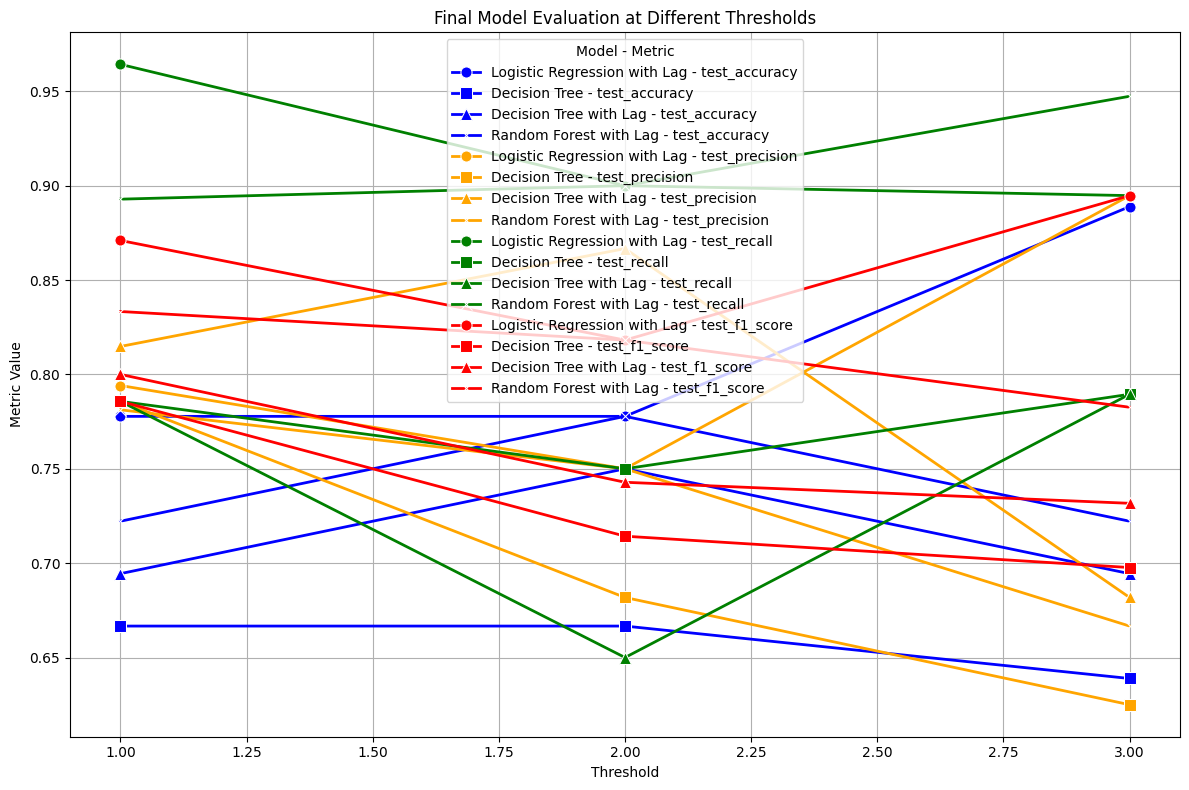

In [79]:
# --- Graphing the Final Results ---
plt.figure(figsize=(12, 8))

# Define custom colors for each metric
metric_colors = {
    'test_accuracy': 'blue',
    'test_precision': 'orange',
    'test_recall': 'green',
    'test_f1_score': 'red'
}

# Define custom markers for each model
model_markers = {
    'Logistic Regression with Lag': 'o',  # circle for Logistic Regression
    'Decision Tree': 's',  # square for Decision Tree
    'Decision Tree with Lag': '^',  # triangle for Decision Tree with Lag
    'Random Forest with Lag': 'x'
}

# Plot each metric for the final models at different thresholds with specified colors and markers
for metric in ['test_accuracy', 'test_precision', 'test_recall', 'test_f1_score']:
    for model in final_results_thresholds_df['model'].unique():
        # Filter the data for the current metric and model
        model_data = final_results_thresholds_df[(final_results_thresholds_df['model'] == model)]
        
        # Plot the data with specific color and marker
        sns.lineplot(data=model_data, x='threshold', y=metric, 
                     label=f'{model} - {metric}', 
                     color=metric_colors[metric], 
                     marker=model_markers[model], 
                     linewidth=2, markersize=8)

# Adding titles and labels
plt.title('Final Model Evaluation at Different Thresholds')
plt.xlabel('Threshold')
plt.ylabel('Metric Value')

# Customizing the legend
plt.legend(title='Model - Metric', loc='best')

# Show the plot
plt.grid(True)
plt.tight_layout()
plt.show()



## Visualization: Test precision

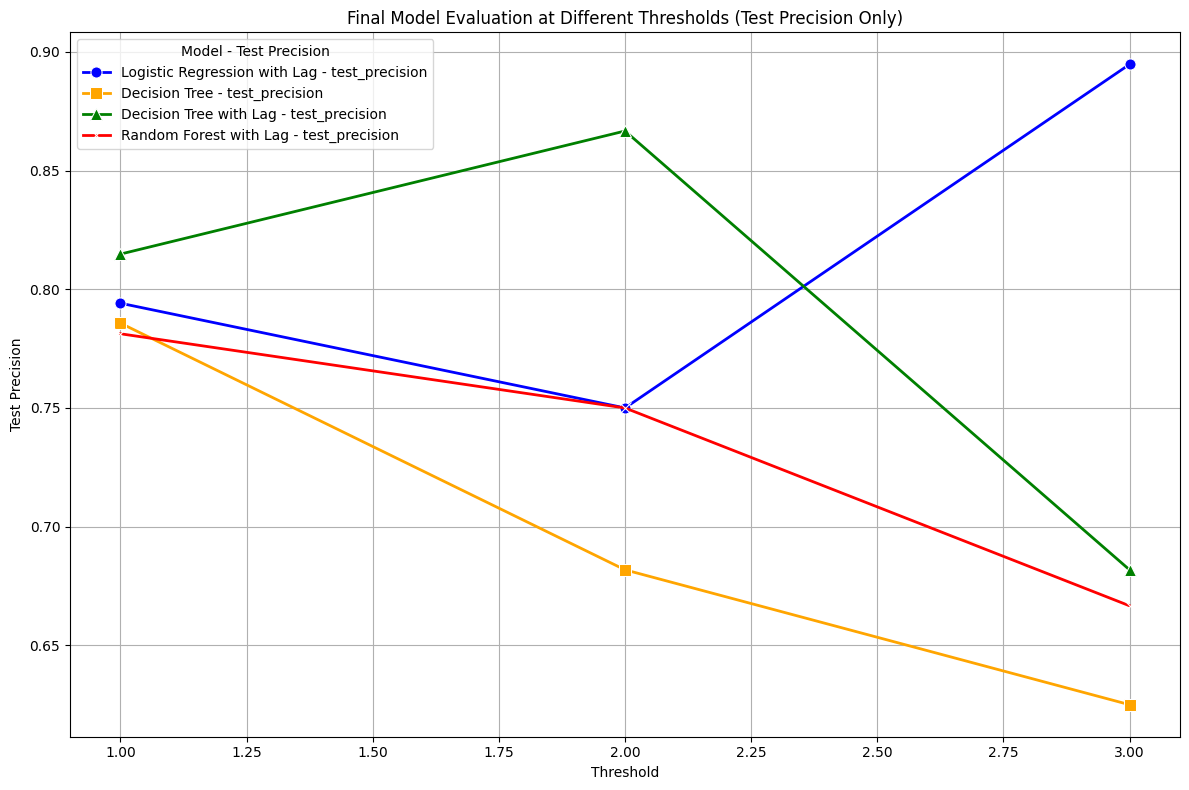

In [80]:
# --- Graphing the Final Results ---
plt.figure(figsize=(12, 8))

# Define custom colors for each model
model_colors = {
    'Logistic Regression with Lag': 'blue',
    'Decision Tree': 'orange',
    'Decision Tree with Lag': 'green',
    'Random Forest with Lag': 'red'
}

# Define custom markers for each model
model_markers = {
    'Logistic Regression with Lag': 'o',  # circle for Logistic Regression
    'Decision Tree': 's',  # square for Decision Tree
    'Decision Tree with Lag': '^',  # triangle for Decision Tree with Lag
    'Random Forest with Lag': 'x'
}

# Plot only test_precision for the final models at different thresholds with specified colors and markers
for model in final_results_thresholds_df['model'].unique():
    # Filter the data for the current model
    model_data = final_results_thresholds_df[(final_results_thresholds_df['model'] == model)]
    
    # Plot the data with specific color and marker
    sns.lineplot(data=model_data, x='threshold', y='test_precision', 
                 label=f'{model} - test_precision', 
                 color=model_colors[model], 
                 marker=model_markers[model], 
                 linewidth=2, markersize=8)

# Adding titles and labels
plt.title('Final Model Evaluation at Different Thresholds (Test Precision Only)')
plt.xlabel('Threshold')
plt.ylabel('Test Precision')

# Customizing the legend
plt.legend(title='Model - Test Precision', loc='best')

# Show the plot
plt.grid(True)
plt.tight_layout()
plt.show()



# Comparison with base models

## Majority model

In [81]:
# List to store results for the majority class classifier
results_majority = []

for threshold in opt_thresholds:
    # Create the binary column for red tide occurrence based on the threshold
    df_majority['red_tide_occurred'] = (df_majority['red_tide_days'] >= threshold).astype(int)
    
    # Split based on years
    train_df_majority = df_majority[df_majority["year"] <= train_end_year]
    val_df_majority = df_majority[(df_majority["year"] > train_end_year) & (df_majority["year"] <= val_end_year)]
    test_df_majority = df_majority[df_majority["year"] > val_end_year]

    # Split the data into features and target
    y_train = train_df_majority['red_tide_occurred']
    y_val = val_df_majority['red_tide_occurred']

    # Create placeholders for training and test sets
    X_train_placeholder = np.zeros((len(y_train), 1))  # DummyClassifier ignores X but expects input shape
    X_val_placeholder = np.zeros((len(y_val), 1))  # DummyClassifier ignores X but expects input shape
    
    # Initialize the majority class classifier
    baseline_model = DummyClassifier(strategy='most_frequent')
    baseline_model.fit(X_train_placeholder, y_train)  # Fit on training data
    
    # Predict on the test set
    y_baseline_pred = baseline_model.predict(X_val_placeholder)  # Predict on test data
    
    # Calculate performance metrics
    baseline_accuracy = accuracy_score(y_val, y_baseline_pred)
    baseline_precision = precision_score(y_val, y_baseline_pred, zero_division=0)
    baseline_recall = recall_score(y_val, y_baseline_pred, zero_division=0)
    baseline_f1 = f1_score(y_val, y_baseline_pred, zero_division=0)
    
    # Store results for the current threshold
    results_majority.append({
        'threshold': threshold,
        'accuracy': baseline_accuracy,
        'precision': baseline_precision,
        'recall': baseline_recall,
        'f1_score': baseline_f1
    })

# Convert results to DataFrame for visualization
results_df_majority = pd.DataFrame(results_majority)

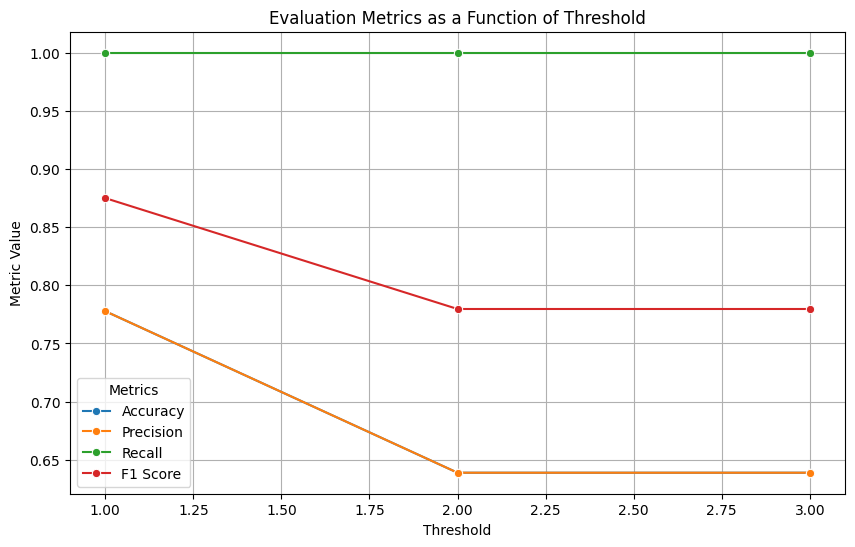

In [82]:
# Set the figure size for better visibility
plt.figure(figsize=(10, 6))

# Plot each metric as a function of threshold
sns.lineplot(data=results_df_majority, x='threshold', y='accuracy', label='Accuracy', marker='o')
sns.lineplot(data=results_df_majority, x='threshold', y='precision', label='Precision', marker='o')
sns.lineplot(data=results_df_majority, x='threshold', y='recall', label='Recall', marker='o')
sns.lineplot(data=results_df_majority, x='threshold', y='f1_score', label='F1 Score', marker='o')

# Adding titles and labels
plt.title('Evaluation Metrics as a Function of Threshold')
plt.xlabel('Threshold')
plt.ylabel('Metric Value')
plt.legend(title='Metrics')

# Show the plot
plt.grid(True)
plt.show()

## Random model

In [83]:
# List to store results for the random class classifier
results_random = []

for threshold in opt_thresholds:
    # Create the binary column for red tide occurrence based on the threshold
    df_random['red_tide_occurred'] = (df_random['red_tide_days'] >= threshold).astype(int)
    
    # Split based on years
    train_df_random = df_random[df_random["year"] <= train_end_year]
    val_df_random = df_random[(df_random["year"] > train_end_year) & (df_random["year"] <= val_end_year)]
    test_df_random = df_random[df_random["year"] > val_end_year]

    # Split the data into features and target
    y_train = train_df_random['red_tide_occurred']
    y_val = val_df_random['red_tide_occurred']

    # Create placeholders for training and test sets
    X_train_placeholder = np.zeros((len(y_train), 1))  # DummyClassifier ignores X but expects input shape
    X_val_placeholder = np.zeros((len(y_val), 1))  # DummyClassifier ignores X but expects input shape
    
    # Initialize the random class classifier
    random_model = DummyClassifier(strategy='uniform', random_state=42)  # Random predictions
    random_model.fit(X_train_placeholder, y_train)  # Fit on training data
    
    # Predict on the test set
    y_random_pred = random_model.predict(X_val_placeholder)  # Predict on test data
    
    # Calculate performance metrics
    random_accuracy = accuracy_score(y_val, y_random_pred)
    random_precision = precision_score(y_val, y_random_pred, zero_division=0)
    random_recall = recall_score(y_val, y_random_pred, zero_division=0)
    random_f1 = f1_score(y_val, y_random_pred, zero_division=0)
    
    # Store results for the current threshold
    results_random.append({
        'threshold': threshold,
        'accuracy': random_accuracy,
        'precision': random_precision,
        'recall': random_recall,
        'f1_score': random_f1
    })

# Convert results to DataFrame for visualization
results_df_random = pd.DataFrame(results_random)

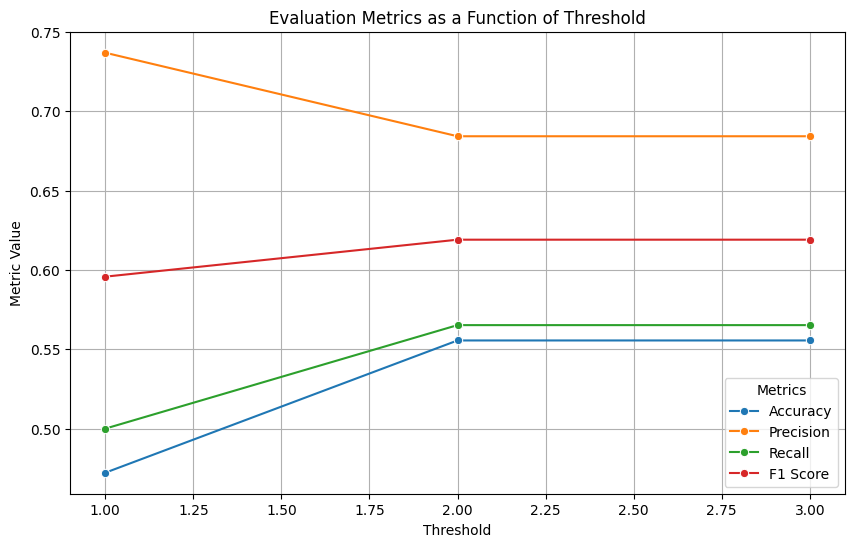

In [84]:
# Set the figure size for better visibility
plt.figure(figsize=(10, 6))

# Plot each metric as a function of threshold
sns.lineplot(data=results_df_random, x='threshold', y='accuracy', label='Accuracy', marker='o')
sns.lineplot(data=results_df_random, x='threshold', y='precision', label='Precision', marker='o')
sns.lineplot(data=results_df_random, x='threshold', y='recall', label='Recall', marker='o')
sns.lineplot(data=results_df_random, x='threshold', y='f1_score', label='F1 Score', marker='o')

# Adding titles and labels
plt.title('Evaluation Metrics as a Function of Threshold')
plt.xlabel('Threshold')
plt.ylabel('Metric Value')
plt.legend(title='Metrics')

# Show the plot
plt.grid(True)
plt.show()

# Model Evaluation

In [85]:
stability_range_df = final_results_thresholds_df.groupby('model').agg({
    'test_accuracy': lambda x: x.max() - x.min(),
    'test_precision': lambda x: x.max() - x.min(),
    'test_recall': lambda x: x.max() - x.min(),
    'test_f1_score': lambda x: x.max() - x.min()
}).reset_index()

print("Range of each metric per model:")
print(stability_range_df)


Range of each metric per model:
                          model  test_accuracy  test_precision  test_recall  \
0                 Decision Tree       0.027778        0.160714     0.039474   
1        Decision Tree with Lag       0.055556        0.184848     0.139474   
2  Logistic Regression with Lag       0.111111        0.144737     0.069549   
3        Random Forest with Lag       0.055556        0.114583     0.054511   

   test_f1_score  
0       0.088040  
1       0.068293  
2       0.076555  
3       0.050725  


In [86]:
stability_std_df = final_results_thresholds_df.groupby('model').agg({
    'test_accuracy': 'std',
    'test_precision': 'std',
    'test_recall': 'std',
    'test_f1_score': 'std'
}).reset_index()

print("Standard deviation of each metric per model:")
print(stability_std_df)


Standard deviation of each metric per model:
                          model  test_accuracy  test_precision  test_recall  \
0                 Decision Tree       0.016038        0.081498     0.021786   
1        Decision Tree with Lag       0.032075        0.095346     0.079462   
2  Logistic Regression with Lag       0.064150        0.074184     0.038724   
3        Random Forest with Lag       0.032075        0.059232     0.029626   

   test_f1_score  
0       0.046778  
1       0.036637  
2       0.039183  
3       0.026038  


In [87]:
stability_cv_df = final_results_thresholds_df.groupby('model').agg({
    'test_accuracy': lambda x: x.std() / x.mean(),
    'test_precision': lambda x: x.std() / x.mean(),
    'test_recall': lambda x: x.std() / x.mean(),
    'test_f1_score': lambda x: x.std() / x.mean()
}).reset_index()

print("Coefficient of Variation (CV) for each metric per model:")
print(stability_cv_df)


Coefficient of Variation (CV) for each metric per model:
                          model  test_accuracy  test_precision  test_recall  \
0                 Decision Tree       0.024395        0.116842     0.028109   
1        Decision Tree with Lag       0.044988        0.121034     0.107131   
2  Logistic Regression with Lag       0.078730        0.091252     0.042106   
3        Random Forest with Lag       0.043301        0.080847     0.032435   

   test_f1_score  
0       0.063855  
1       0.048321  
2       0.045493  
3       0.032092  


## Variation in evaluation metrics for models based by threshold values

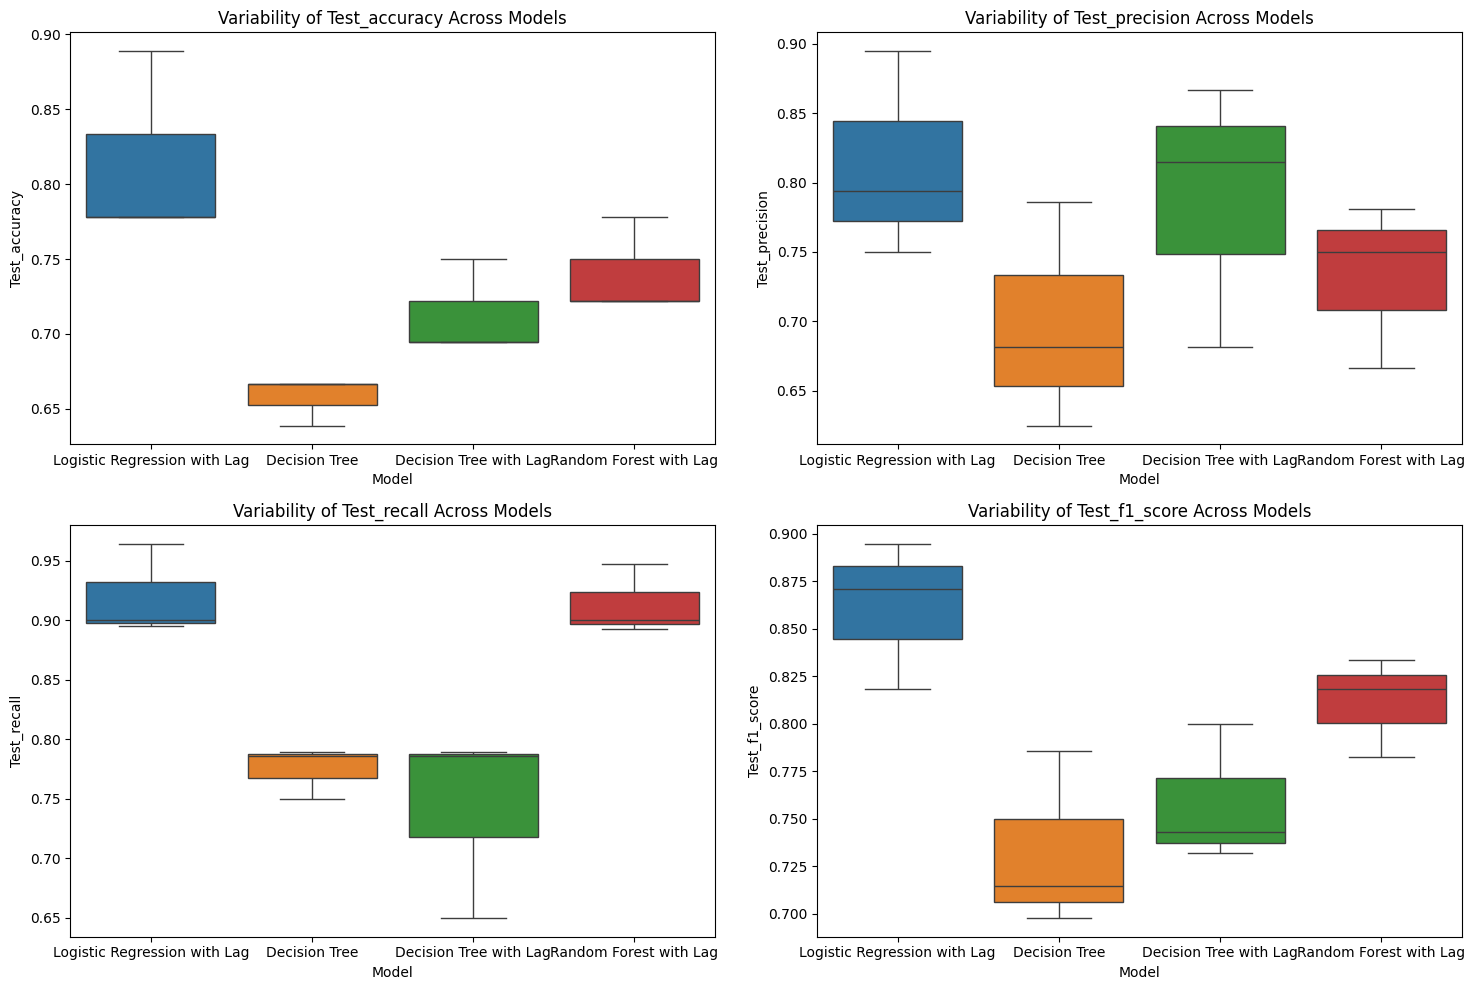

In [88]:
metrics = ['test_accuracy', 'test_precision', 'test_recall', 'test_f1_score']
plt.figure(figsize=(15, 10))

for i, metric in enumerate(metrics, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(data=final_results_thresholds_df, x='model', y=metric, hue="model", legend=False)
    plt.title(f'Variability of {metric.capitalize()} Across Models')
    plt.xlabel("Model")
    plt.ylabel(metric.capitalize())

plt.tight_layout()
plt.show()


## Variation in evaluation metrics for models by data set

In [89]:
#display(results_df_trans_logistic_lag_opt)
#display(results_df_tree_opt)
#display(results_df_tree_lag_opt)
#display(final_results_thresholds_df)

tvt_df_logistic = results_df_trans_logistic_lag_opt.copy()
tvt_df_dt = results_df_tree_opt.copy()
tvt_df_dt_lag = results_df_tree_lag_opt.copy()
tvt_df_rf_lag = results_df_rf_lag_opt.copy()

tvt_df_logistic["model"] = "Logistic Regression with Lag"
tvt_df_dt["model"] = "Decision Tree"
tvt_df_dt_lag["model"] = "Decision Tree with Lag"
tvt_df_rf_lag["model"] = "Random Forest with Lag"

tvt_df_logistic = tvt_df_logistic.drop(columns=["best_C", "best_solver", "intercept"])
tvt_df_dt = tvt_df_dt.drop(columns="best_params")
tvt_df_dt_lag = tvt_df_dt_lag.drop(columns="best_params")
tvt_df_rf_lag = tvt_df_rf_lag.drop(columns="best_params")

#display(tvt_df_logistic)
#display(tvt_df_dt)
#display(tvt_df_dt_lag)

# Concatenate the training DataFrames into a single DataFrame
tv_df = pd.concat([tvt_df_logistic, tvt_df_dt, tvt_df_dt_lag, tvt_df_rf_lag])

# Merge test and train DataFrames on 'threshold' and 'model'
tvt_df = final_results_thresholds_df.merge(tv_df, on=['threshold', 'model'], how='inner')

display(tvt_df)

threshold                         model  test_accuracy  test_precision  \
0           1  Logistic Regression with Lag       0.777778        0.794118   
1           1                 Decision Tree       0.666667        0.785714   
2           1        Decision Tree with Lag       0.694444        0.814815   
3           1        Random Forest with Lag       0.722222        0.781250   
4           2  Logistic Regression with Lag       0.777778        0.750000   
5           2                 Decision Tree       0.666667        0.681818   
6           2        Decision Tree with Lag       0.750000        0.866667   
7           2        Random Forest with Lag       0.777778        0.750000   
8           3  Logistic Regression with Lag       0.888889        0.894737   
9           3                 Decision Tree       0.638889        0.625000   
10          3        Decision Tree with Lag       0.694444        0.681818   
11          3        Random Forest with Lag       0.722222        0.666667   

    test_recall  test_f1_score  train_accuracy  train_precision  train_recall  \
0      0.964286       0.870968        0.865385         0.892857      0.954198   
1      0.785714       0.785714        0.940476         0.978102      0.950355   
2      0.785714       0.800000        1.000000         1.000000      1.000000   
3      0.892857       0.833333        0.916667         0.927536      0.977099   
4      0.900000       0.818182        0.775641         0.803030      0.921739   
5      0.750000       0.714286        0.892857         0.933333      0.918033   
6      0.650000       0.742857        0.852564         0.950980      0.843478   
7      0.900000       0.818182        0.871795         0.892562      0.939130   
8      0.894737       0.894737        0.769231         0.833333      0.800000   
9      0.789474       0.697674        0.833333         0.853211      0.885714   
10     0.789474       0.731707        0.897436         0.928571      0.910000   
11     0.947368       0.782609        0.916667         0.930693      0.940000   

    train_f1_score  val_accuracy  val_precision  val_recall  val_f1_score  
0         0.922509      0.777778       0.794118    0.964286      0.870968  
1         0.964029      0.722222       0.846154    0.785714      0.814815  
2         1.000000      0.722222       0.821429    0.821429      0.821429  
3         0.951673      0.694444       0.757576    0.892857      0.819672  
4         0.858300      0.888889       0.880000    0.956522      0.916667  
5         0.925620      0.500000       0.647059    0.478261      0.550000  
6         0.894009      0.666667       0.823529    0.608696      0.700000  
7         0.915254      0.861111       0.875000    0.913043      0.893617  
8         0.816327      0.805556       1.000000    0.695652      0.820513  
9         0.869159      0.777778       0.857143    0.782609      0.818182  
10        0.919192      0.583333       0.785714    0.478261      0.594595  
11        0.935323      0.888889       1.000000    0.826087      0.904762

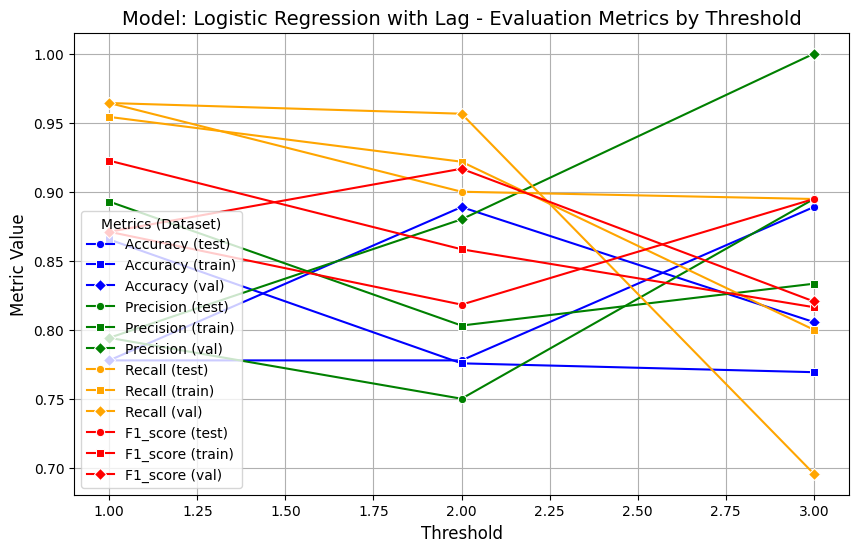

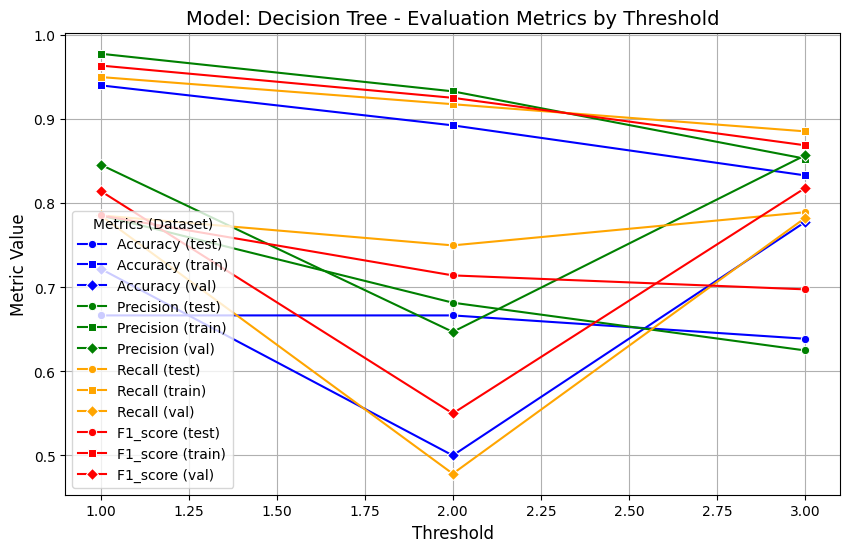

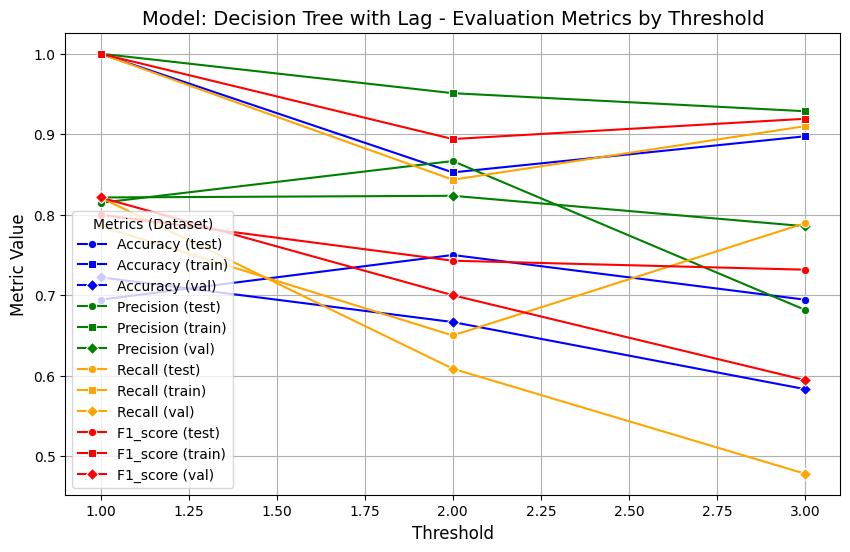

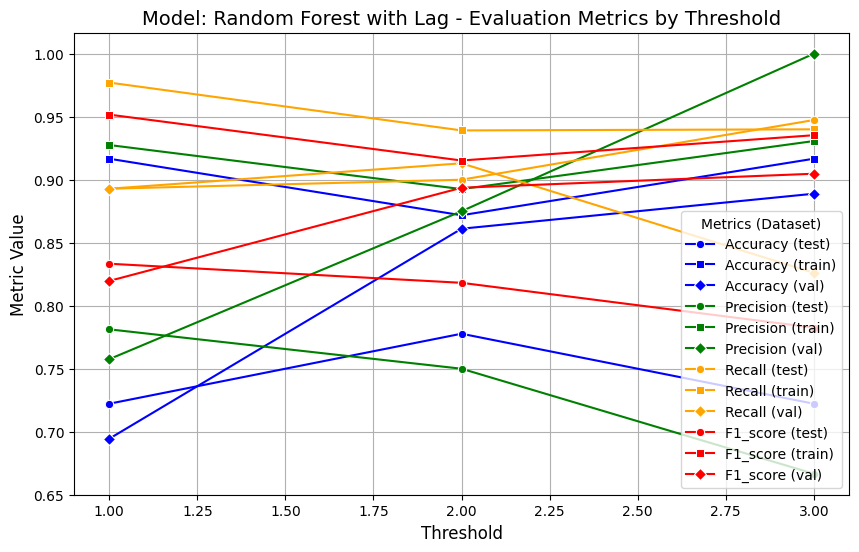

In [90]:
# Melt the DataFrame into long format
melted_df_line = tvt_df.melt(id_vars=['threshold', 'model'], 
                      value_vars=['test_accuracy', 'test_precision', 'test_recall', 'test_f1_score',
                                  'train_accuracy', 'train_precision', 'train_recall', 'train_f1_score',
                                  'val_accuracy', 'val_precision', 'val_recall', 'val_f1_score'],
                      var_name="metric_type", value_name="value")

# Extract dataset type (test/train/validation) and metric name
melted_df_line['dataset'] = melted_df_line['metric_type'].str.extract(r'^(test|train|val)')
melted_df_line['metric'] = melted_df_line['metric_type'].str.extract(r'_(accuracy|precision|recall|f1_score)')

# Define colors and markers for clear differentiation
metric_colors = {"accuracy": "blue", "precision": "green", "recall": "orange", "f1_score": "red"}
dataset_markers = {"test": "o", "train": "s", "val": "D"}  # Different markers

# Iterate over each model to create separate plots
for model in melted_df_line['model'].unique():
    model_df = melted_df_line[melted_df_line['model'] == model]  # Filter data for current model

    plt.figure(figsize=(10, 6))
    plt.title(f"Model: {model} - Evaluation Metrics by Threshold", fontsize=14)

    # Plot each metric separately with dataset distinction
    for metric, color in metric_colors.items():
        for dataset, marker in dataset_markers.items():
            subset = model_df[(model_df['metric'] == metric) & (model_df['dataset'] == dataset)]
            sns.lineplot(data=subset, x="threshold", y="value", marker=marker, label=f"{metric.capitalize()} ({dataset})", color=color)

    plt.xlabel("Threshold", fontsize=12)
    plt.ylabel("Metric Value", fontsize=12)
    plt.legend(title="Metrics (Dataset)")
    plt.grid(True)
    plt.show()


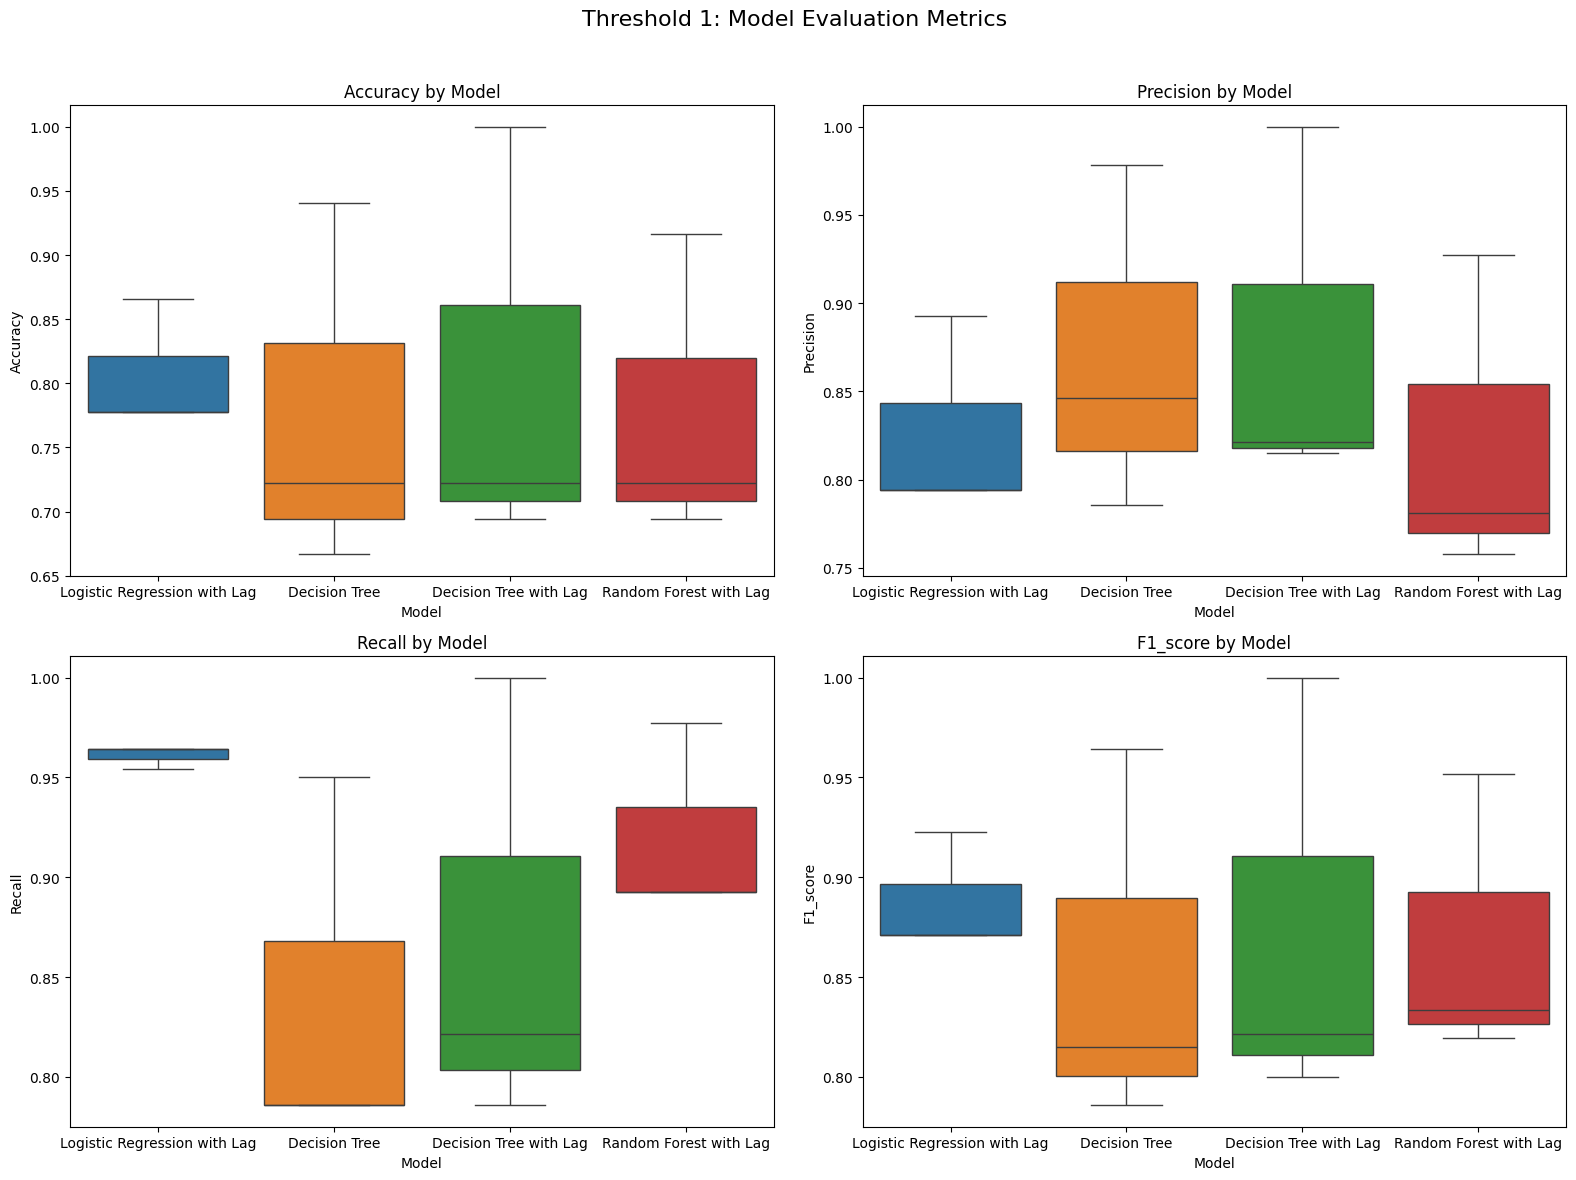

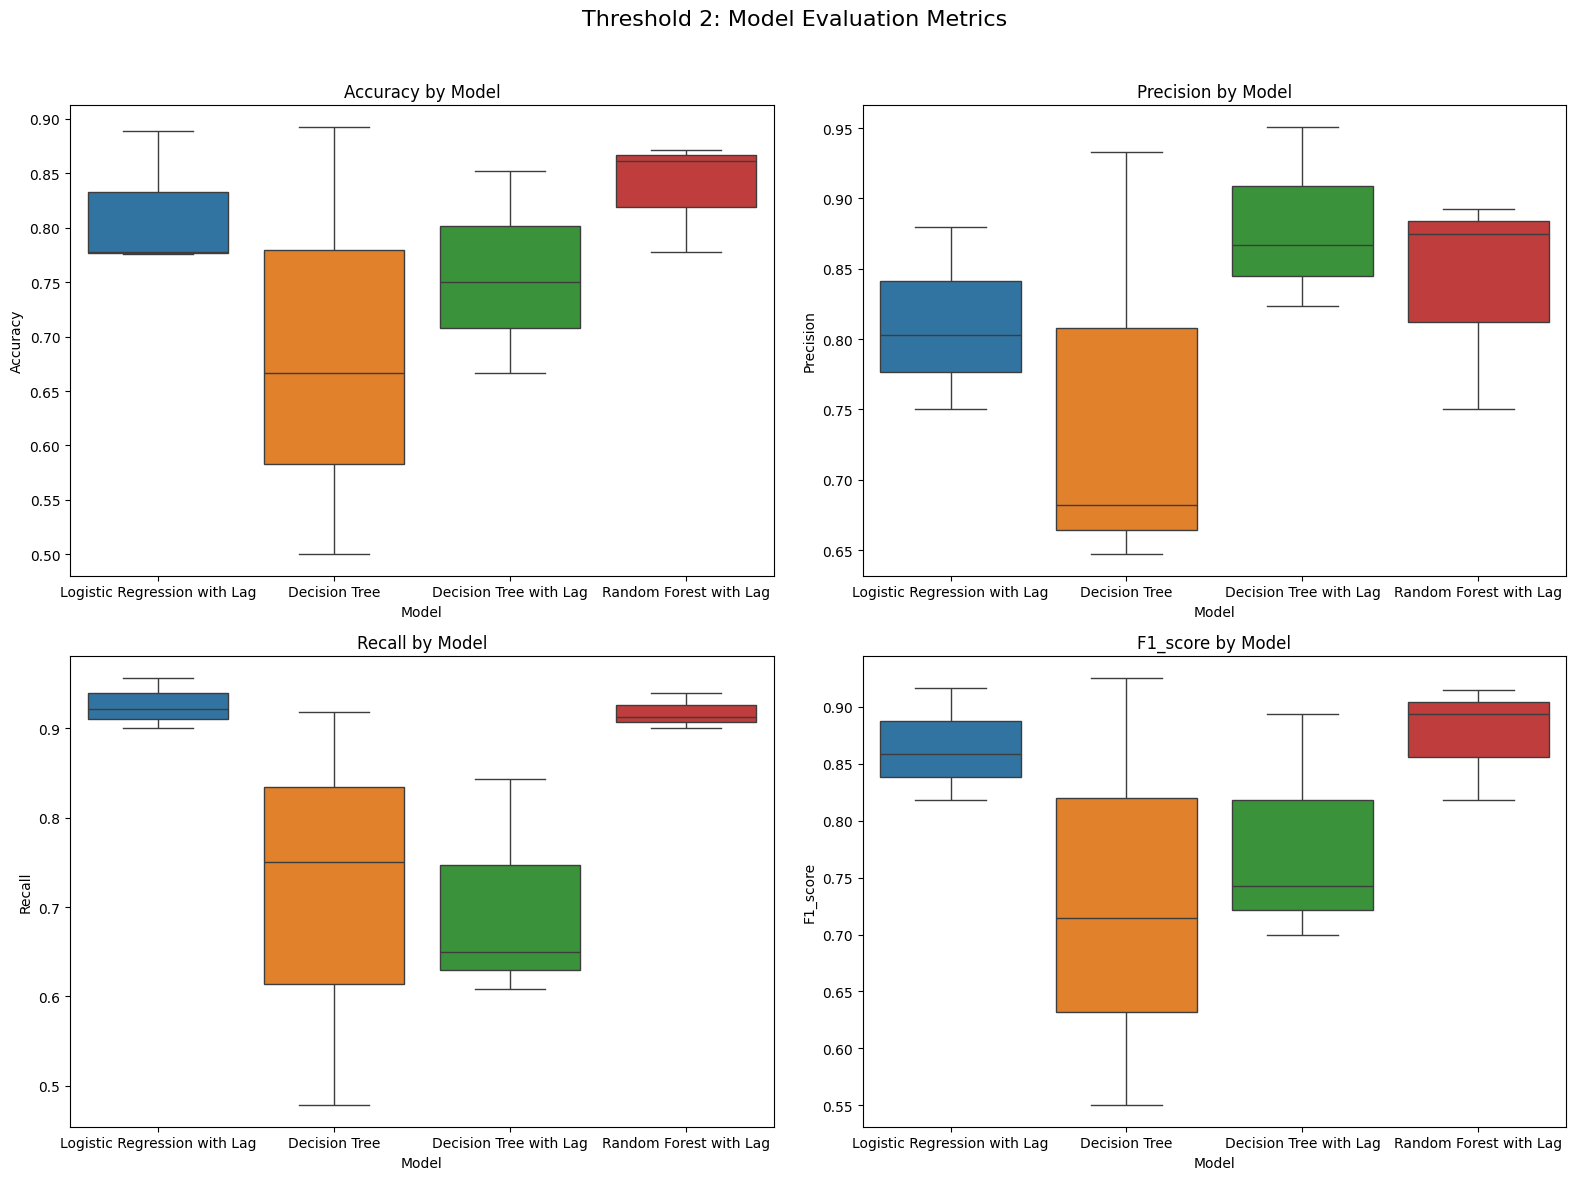

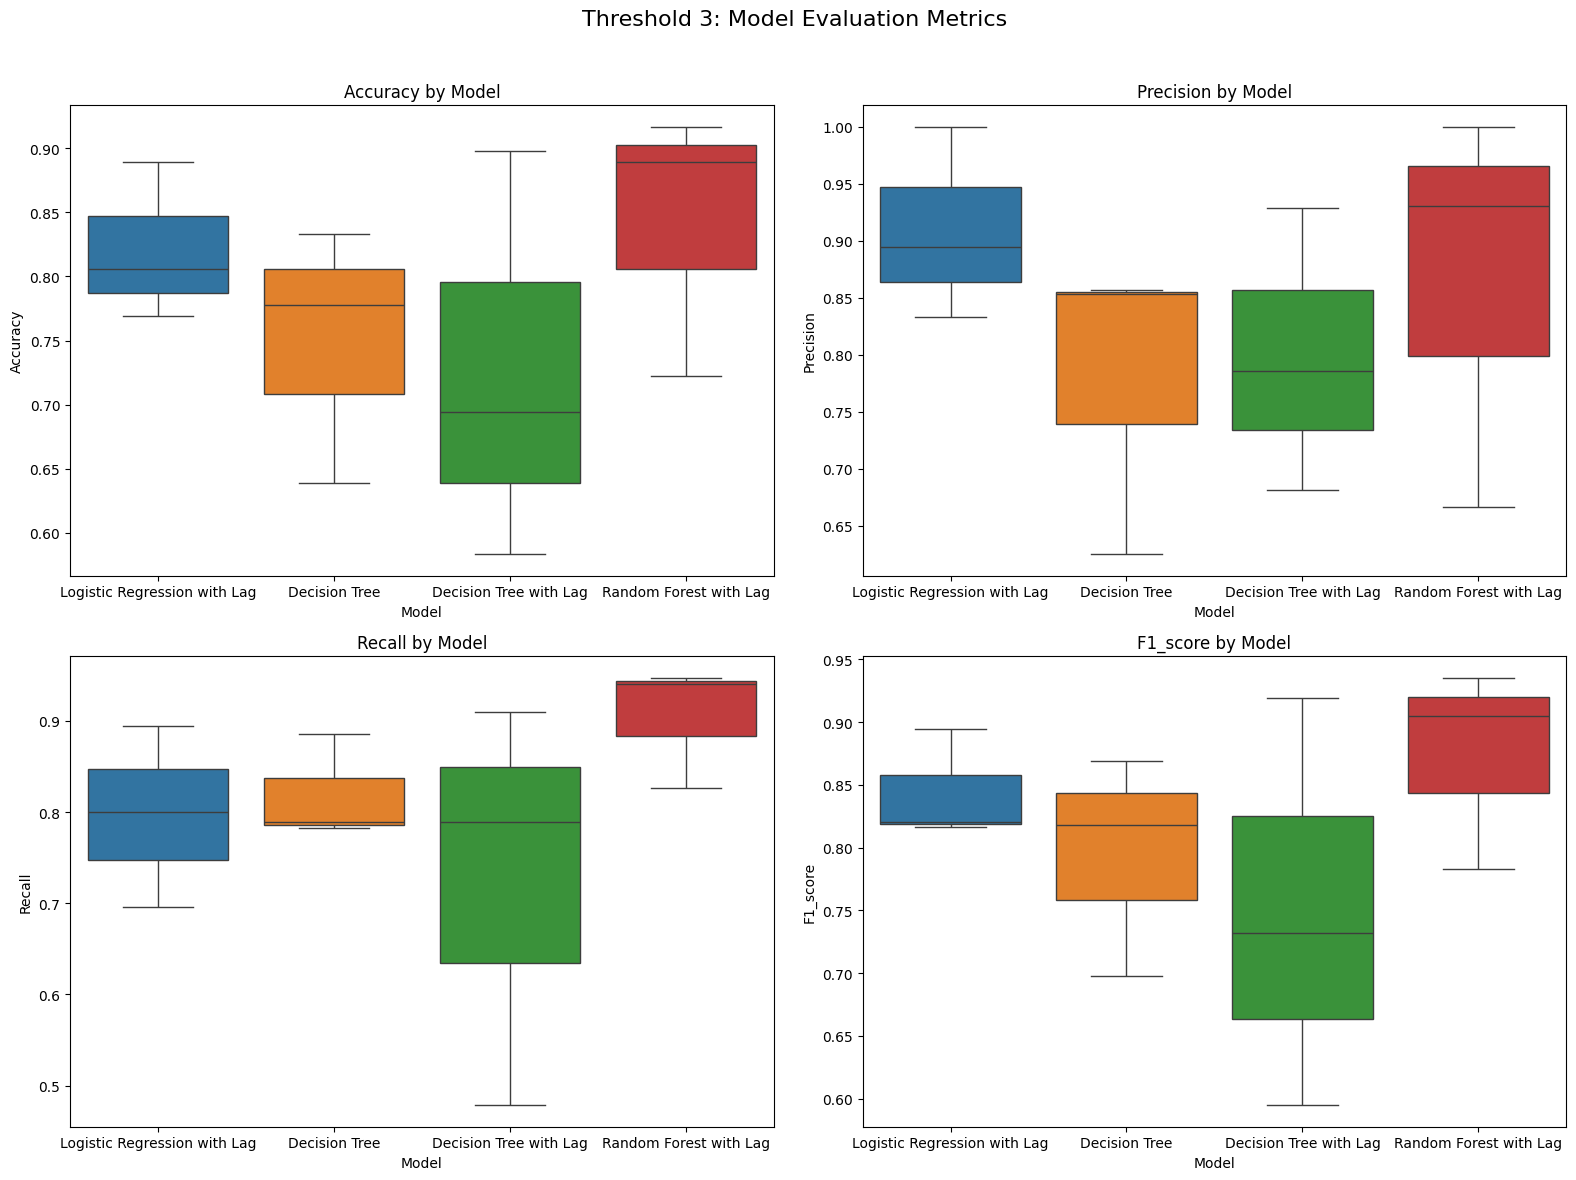

In [91]:
# Melt the DataFrame into a long format for easier plotting
melted_df_box = tvt_df.melt(id_vars=['threshold', 'model'], 
                      value_vars=['test_accuracy', 'test_precision', 'test_recall', 'test_f1_score',
                                  'train_accuracy', 'train_precision', 'train_recall', 'train_f1_score',
                                  'val_accuracy', 'val_precision', 'val_recall', 'val_f1_score'],
                      var_name="metric_type", value_name="value")

# Extract metric type (accuracy, precision, recall, f1_score)
melted_df_box['metric'] = melted_df_box['metric_type'].str.extract(r'_(accuracy|precision|recall|f1_score)')

# Iterate over each threshold to create separate plots
for threshold in sorted(melted_df_box['threshold'].unique()):
    threshold_df = melted_df_box[melted_df_box['threshold'] == threshold]  # Filter data for the current threshold

    # Create a figure with 2 rows, 2 columns for 4 evaluation metrics
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle(f"Threshold {threshold}: Model Evaluation Metrics", fontsize=16)

    # Iterate over each evaluation metric and create a box plot
    for ax, metric in zip(axes.flatten(), ['accuracy', 'precision', 'recall', 'f1_score']):
        sns.boxplot(data=threshold_df[threshold_df['metric'] == metric], 
                    x='model', y='value', ax=ax, hue='model')
        ax.set_title(f"{metric.capitalize()} by Model")
        ax.set_xlabel("Model")
        ax.set_ylabel(metric.capitalize())

    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit title
    plt.show()

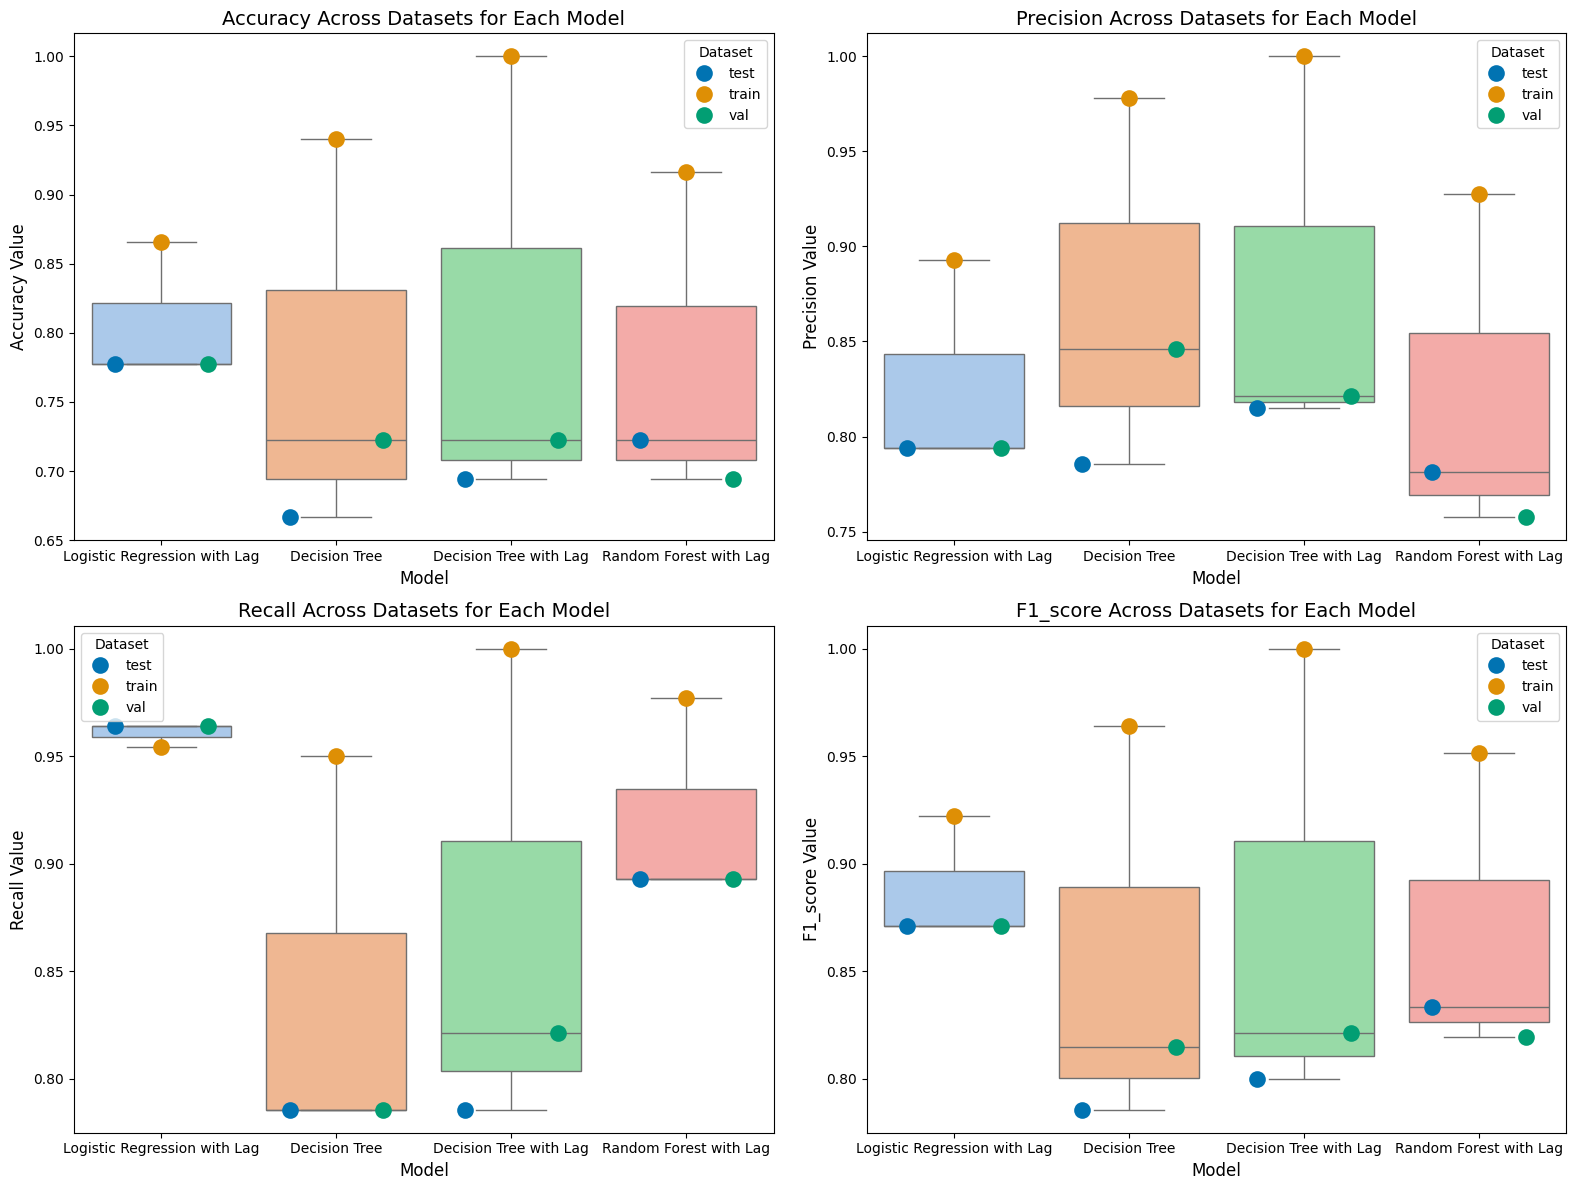

In [92]:
# Melt the DataFrame into a long format for easier plotting
melted_df_bar = tvt_df[tvt_df['threshold'] == 1].melt(id_vars=['model'], 
                    value_vars=['test_accuracy', 'test_precision', 'test_recall', 'test_f1_score',
                                'train_accuracy', 'train_precision', 'train_recall', 'train_f1_score',
                                'val_accuracy', 'val_precision', 'val_recall', 'val_f1_score'],
                    var_name="metric_type", value_name="value")

# Add a column for dataset type (test, train, validation)
melted_df_bar['dataset'] = melted_df_bar['metric_type'].str.extract(r'(test|train|val)')

# Add a column for the specific metric (accuracy, precision, recall, F1 score)
melted_df_bar['metric'] = melted_df_bar['metric_type'].str.extract(r'_(accuracy|precision|recall|f1_score)')

# Create a figure with 2 rows, 2 columns for the 4 evaluation metrics
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# List of metrics to plot
metrics = ['accuracy', 'precision', 'recall', 'f1_score']

# Marker styles for different datasets
marker_styles = {'test': 'o', 'train': 's', 'val': '^'}

# Loop through each metric and create a plot in each subplot
for ax, metric in zip(axes.flatten(), metrics):
    # Filter the data for the current metric
    metric_df = melted_df_bar[melted_df_bar['metric'] == metric]
    
    sns.boxplot(data=metric_df, x='model', y='value', ax=ax, hue='model', palette='pastel')

    # Add individual points using a stripplot (jittered)
    sns.stripplot(data=metric_df, x='model', y='value', hue='dataset', ax=ax, dodge=True, jitter=True, palette='colorblind', size=12)
    
    # Add titles and labels
    ax.set_title(f'{metric.capitalize()} Across Datasets for Each Model', fontsize=14)
    ax.set_xlabel('Model', fontsize=12)
    ax.set_ylabel(f'{metric.capitalize()} Value', fontsize=12)
    #ax.tick_params(axis='x', rotation=45)
    ax.legend(title='Dataset')

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()
